# ForecastingEvents
Does it Happen and When - Binary Classification and Regression.

### Scenario

A retail shop has deployed electronic tags on each of their items (aka assets) and installed infrastructure at the receiving area of their store. The recieving area is where trailers pull up to the dock door to unload assets. 

__Deployment Setup__
+ Each item has 1 pixel attached
+ Two zones are installed with "bridges", with multiple bridges installed at each zone to maximize coverage.
    + `GMReceiving`
        + the bridges installed next to the receiving door
    + `FastSorter`
        + fast sorter machine located inside the store and close to the trailer receiving door
        + items get unloaded one by one into the store through fast sorter machine

__How data are generated__
+ The pixels are energized by hardware called “bridges”. 
+ Once energized, the pixels transmit data back to the "bridges".
+ Data is then transmitted to the "gateway".
+ "Gateways" send the data onto the "cloud".  

You have a limited dataset with the raw data from some pixels, along with labels for which pallet the pixels ended up on. You also have bridge and gateway ID’s where the signals were received.

### Task
Using the provided Train and Validation datasets, please create a model or heuristics to **determine which and when each item gets unloaded from the trailer parked at the receiving door of the store**

+ Develop the model/heuristic based on the train data and evaluate on the validation data. 

+ Upon design completion, prepare the final code such that it can run on a hidden test set, which will follow the exact same format as the validation set, except without the "unload_timestamp" column. If you generate a trained model, please ensure you include the model weights.

The prediction output should be a predictions dataframe that contains 3 columns: 
+ "pixel_id"
+ "unload_timestamp_pred"
+ "unload_pred" 
If `unload_pred` is 0 (not unloaded), the `unload_timestamp_pred` should be an empty string.
If `unload_pred` is 1 (unloaded), the `unload_timestamp_pred` should contain a 13-digit timestamp.

The final section of this notebook has cells that should not be modified.  This is designed to evaluate your model/heuristic performance on the hidden test set.

## Imports

In [1]:
# Please install any necessary commands to install any non-stardard libraries that may be needed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feel free to add any additional imports to this cell.
import datetime
# Data Preprocessing
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import dill
import pickle
#ML
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, classification_report, mean_squared_error, r2_score
import statsmodels.api as sm # Linear Regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import PolynomialFeatures # Nonlinear fit with several x's
from sklearn.svm import SVC # SVM classifier

In [3]:
#Read in provided training and validation files

training = 'ds_interview_unload_train.csv'
train_df = pd.read_csv(training, dtype={'unload_timestamp':str}) # specify data type to avoid loss of precision
# Could not specify int due to presence of null values, so convert str -> int
train_df['unload_timestamp'] = [i if pd.isna(i) else int(i) for i in train_df['unload_timestamp']]
valid = 'ds_interview_unload_val.csv'
val_df = pd.read_csv(valid)
train_df.head()

,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
0,T2213,1683904711881,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,65,83,24.5,0,1910.6328,1.683906e+12
1,T2213,1683905449804,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,210,84,24.5,0,1898.6328,1.683906e+12
2,T2213,1683905664965,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,76,76,24.5,1,1899.6328,1.683906e+12
3,T2213,1683905696647,test_1,GW0CDC7EDB200C,3D9B5E166F18,FastSorter,103,55,24.5,0,1922.3789,1.683906e+12
4,T2213,1683904625580,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,253,69,24.5,7,1897.6328,1.683906e+12


In [4]:
# Verify precision of `timestamp` after reading CSV
train_df['timestamp'].unique()

array([1683904711881, 1683905449804, 1683905664965, ..., 1683908984274,
       1683908988879, 1683908983359], dtype=int64)

In [5]:
# Verify precision of `unload_timestamp` after reading CSV
train_df['unload_timestamp'].unique()

array([1.68390568e+12, 1.68390566e+12, 1.68390566e+12, 1.68390566e+12,
       1.68390566e+12, 1.68390568e+12, 1.68390568e+12, 1.68390564e+12,
       1.68390564e+12, 1.68390564e+12, 1.68390564e+12, 1.68390565e+12,
       1.68390569e+12, 1.68390569e+12,            nan, 1.68390542e+12,
       1.68390542e+12, 1.68390542e+12, 1.68390542e+12, 1.68390543e+12,
       1.68390543e+12, 1.68390544e+12, 1.68390544e+12, 1.68390544e+12,
       1.68390545e+12, 1.68390545e+12, 1.68390546e+12, 1.68390546e+12,
       1.68390546e+12, 1.68390546e+12, 1.68390546e+12, 1.68390546e+12,
       1.68390541e+12, 1.68390541e+12, 1.68390540e+12, 1.68390540e+12,
       1.68390540e+12, 1.68390541e+12, 1.68390541e+12, 1.68390541e+12,
       1.68390542e+12, 1.68390541e+12, 1.68390541e+12, 1.68390886e+12,
       1.68390883e+12, 1.68390883e+12, 1.68390883e+12, 1.68390885e+12,
       1.68390884e+12, 1.68390884e+12, 1.68390884e+12, 1.68390885e+12,
       1.68390885e+12, 1.68390886e+12, 1.68390881e+12, 1.68390882e+12,
      

## Dataset Overview

+ `pixel_id`:  the unique id for the individual tag on each asset. 1 tag per asset.
+ `timestamp`: 13 digit unix timestamp of the packet data
+ `test`
    + There are 2 round of the data collection in the train. Therefore, this column has value `test_1` and `test_2` in the train set as round number. This column is here for documentation purpose.
    + This column will not exist in the validation or test set.
+ `gatewayId`:  The unique gateway which received this data from the bridges.
+ `bridgeId`: The unique bridge that received this data from the pixel.
+ `zone_name`: which zone the bridge belongs to
+ `packet_counter`: 
    + This is a counter of how many packets have been transmitted by this specific pixel.
    + The counter increases incrementally by 1 for each attempt made by the pixel. However, it is not guaranteed that bridge will receive every packet each pixel tries to transmit. 
    + Additionally, the displayed value resets after 255, so the counter is really true_counter % 256.
    + Ideally, the more energized environment, the faster we can get packet. 
+ `signal_strength`: a reading of how strong the signal was between the pixel and the bridge. **Lower = Stronger Signal**. Note: this signal is HIGHLY sensitive to changes in the environment, and can suffer from reflections and line-of-sight interruptions.
+ `temperature`: this is the sensor reading of temperature in degrees Celsius. (Accurate to +/- 0.5 degrees) 
+ `nfpkt` (number of filtered packets):  Occasionally a bridge will receive multiple identical packets from a given pixel, which it will deduplicate prior to sending the data onto the gateway.  This column shows the count of removed packets.
+ `internal_oscillation`: 
    + The pixels must perform internal calibration to overcome environmental factors in order to transmit on the proper channels.
    + This value can be thought of as a measurement of the environmental impact on the tag which it must compensate for prior to transmitting its data. 
+ `unload_timestamp`:
    + when each asset get unloaded in 13 digit unix time
    + if the asset did not get unloaded, the column will be null.

## Exploratory Data Anaylsis

In [6]:
#Please do EDA here.
#create as many cells as necessry

In [7]:
print(f"Training dataset contains {train_df.shape[1]} descriptors and {train_df.shape[0]} records.")
print("Variables:", list(train_df.columns))

Training dataset contains 12 descriptors and 8289 records.
Variables: ['pixel_id', 'timestamp', 'test', 'gatewayId', 'bridgeId', 'zone_name', 'packet_counter', 'signal_strength', 'temperature', 'nfpkt', 'interal_oscillation', 'unload_timestamp']


### pixel_id

In [8]:
pixel_ids = train_df['pixel_id'].unique()
pixel_ns = [int(x[1:]) for x in pixel_ids]
pixel_n_prev = pixel_ns[0] - 1 # a previous pixel ID for comparison with the current one
print("First pixel number is", pixel_ns[0])
print("Skipped pixel numbers:")
for pixel_n in pixel_ns:
    if pixel_n != pixel_n_prev + 1:
        if pixel_n - 1 == pixel_n_prev + 1:
            print(f"{pixel_n_prev + 1}")
        else:
            print(f"{pixel_n_prev + 1}-{pixel_n - 1}")
    pixel_n_prev = pixel_n
print("Last pixel number is", pixel_ns[-1])

First pixel number is 2213
Skipped pixel numbers:
2255
2303
Last pixel number is 2377


In [9]:
print("Summary for the number of records per pixel:")
cnt = train_df['pixel_id'].value_counts(sort=False)
cnt.describe()

Summary for the number of records per pixel:


count    163.000000
mean      50.852761
std       18.530999
min        6.000000
25%       40.000000
50%       50.000000
75%       62.000000
max      101.000000
Name: pixel_id, dtype: float64

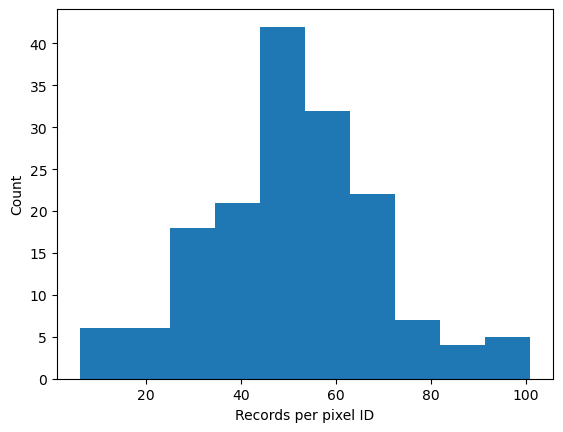

In [10]:
plt.hist(cnt)
plt.xlabel("Records per pixel ID")
plt.ylabel("Count");

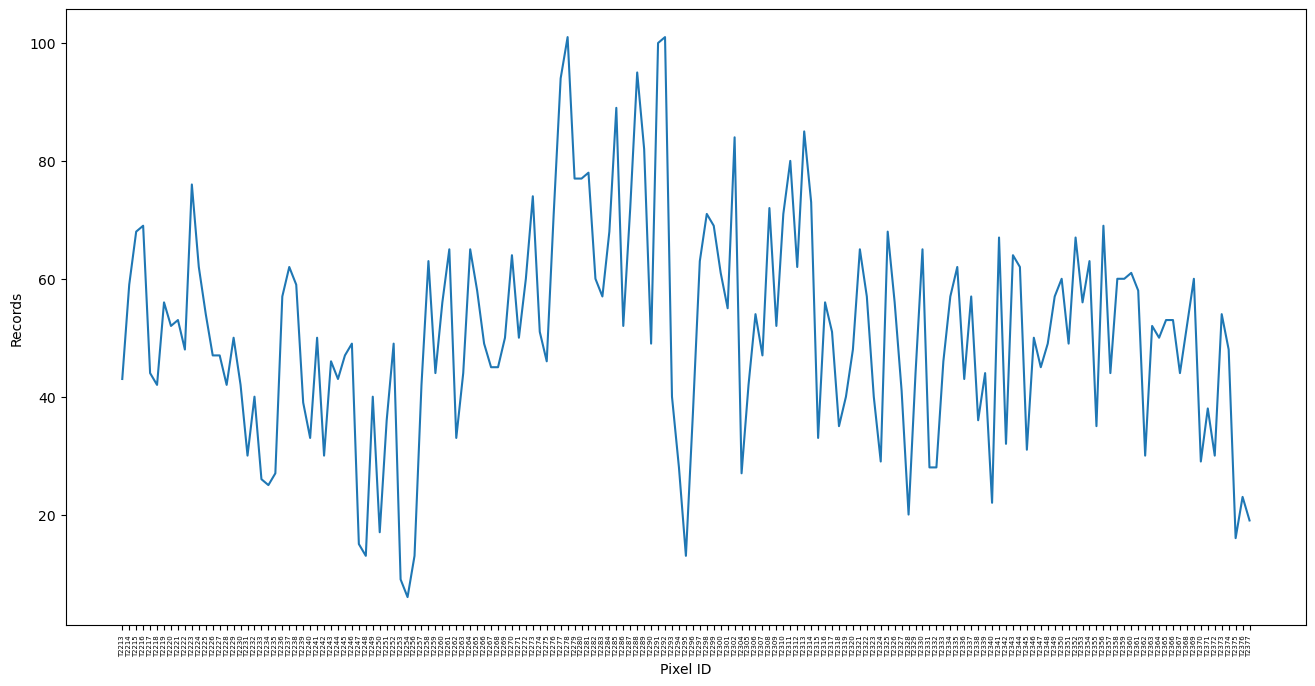

In [11]:
cnt = train_df['pixel_id'].value_counts(sort=False)
plt.figure(figsize=(16,8))
plt.plot(cnt.index, cnt.values)
plt.xlabel("Pixel ID")
plt.ylabel("Records")
plt.xticks(rotation=90, fontsize=5);

### timestamp, test

In [12]:
train_df_test1 = train_df.loc[train_df['test'] == 'test_1']
train_df_test2 = train_df.loc[train_df['test'] == 'test_2']

In [13]:
# Earliest and latest time for test_1 and test_2 across all assets
time_earliest_test1 = np.min(train_df_test1['timestamp'])
time_earliest_test2 = np.min(train_df_test2['timestamp'])
print(f"Second test started {(time_earliest_test2 - time_earliest_test1)/(1000*3600):.5f} hr after the first test")
time_latest_test1 = np.max(train_df_test1['timestamp'])
time_latest_test2 = np.max(train_df_test2['timestamp'])
print(f"Second test ended {(time_latest_test2 - time_latest_test1)/(1000*3600):.5f} hr after the first")

Second test started 0.99993 hr after the first test
Second test ended 0.91663 hr after the first


Is this a coincidence that the second test started almost exactly 1 hr after the start of the first test?
Let us try for a few different assets.

In [14]:
# Time difference values for a given asset
pixel_id = pixel_ids[162] # Choose index 0..162, try for different assets
print("Asset:", pixel_id)
pixel_df = train_df.loc[train_df['pixel_id'] == pixel_id, ['timestamp','test','unload_timestamp']]
pixel_df_test1 = pixel_df.loc[pixel_df['test'] == 'test_1', ['timestamp','unload_timestamp']]
pixel_df_test2 = pixel_df.loc[pixel_df['test'] == 'test_2', ['timestamp','unload_timestamp']]
time_min1 = np.min(pixel_df_test1['timestamp'])
time_min2 = np.min(pixel_df_test2['timestamp'])
print(f"Difference in earliest times is {(time_min2 - time_min1)/(1000*3600)} hr")
time_max1 = np.max(pixel_df_test1['timestamp'])
time_max2 = np.max(pixel_df_test2['timestamp'])
print(f"Difference in latest times is {(time_max2 - time_max1)/(1000*3600)} hr")

Asset: T2377
Difference in earliest times is 1.088503611111111 hr
Difference in latest times is 0.9764016666666666 hr


Indeed, the difference between the starting times and that between the end times is close to 1 hr. Let us plot a histogram for all assets. But before we can do that, we need to see if test 2 has assets that are not in test 1.

In [15]:
pixel_ids_test1 = train_df_test1['pixel_id'].unique()
pixel_ids_test2 = train_df_test2['pixel_id'].unique()
(np.union1d(pixel_ids_test1, pixel_ids_test2) == pixel_ids_test1).sum()

163

Since the union of pixel IDs from both tests coincides with pixel IDs from test 1, there are no new pixel IDs in test 2. Therefore, it is safe to use the list of assets from test 2.

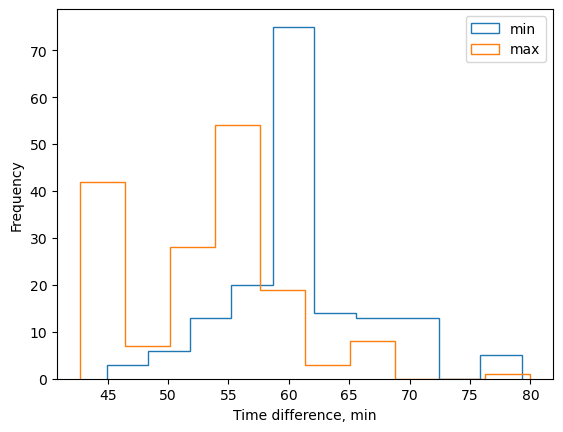

In [16]:
t_min_diff = []
t_max_diff = []
for pixel_id in pixel_ids_test2:
    pixel_df_test1 = train_df_test1.loc[train_df_test1['pixel_id'] == pixel_id, 'timestamp']
    pixel_df_test2 = train_df_test2.loc[train_df_test2['pixel_id'] == pixel_id, 'timestamp']
    t1_min = np.min(pixel_df_test1)
    t2_min = np.min(pixel_df_test2)
    t1_max = np.max(pixel_df_test1)
    t2_max = np.max(pixel_df_test2)
    t_min_diff.append(1e-3*(t2_min - t1_min)/60)
    t_max_diff.append(1e-3*(t2_max - t1_max)/60)
plt.hist(t_min_diff, label="min", histtype='step')
plt.hist(t_max_diff, label="max", histtype='step')
plt.xlabel("Time difference, min")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Due to a sharp peak of the starting time differences across assets between tests 1 and 2 at 60 min, it is likely that test 2 started exactly 1 hr after test 1. Somewhat smaller mode of the end time differences around 57 min could be due to a faster operation during test 2. Therefore, all timestamps for test 2 will be decreased by 1 hr and pixel IDs will be renamed as if these were new assets.

In [17]:
def ms2datetime(time_ms):
    '''Convert 13-digit timestamp from ms to date and time.
    Input: time_ms - 13-digit timestamp, ms.
    Output: date and time, '%Y-%m-%d %H:%M:%S.%f'.'''
    #return datetime.datetime.fromtimestamp(time_earliest_test1/1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    return datetime.datetime.fromtimestamp(time_ms/1000).isoformat(sep=' ', timespec='milliseconds')

In [18]:
print("Test 1: ", end='')
time_latest_test1 = np.max(train_df_test1['timestamp'])
print(ms2datetime(time_earliest_test1), end='') # 13-digit UNIX timestamp from ns to ms
print(" -", ms2datetime(time_latest_test1))

print("Test 2: ", end='')
time_latest_test2 = np.max(train_df_test2['timestamp'])
print(ms2datetime(time_earliest_test2), end='')
print(" -", ms2datetime(time_latest_test2))

Test 1: 2023-05-12 11:17:00.419 - 2023-05-12 11:44:59.938
Test 2: 2023-05-12 12:17:00.157 - 2023-05-12 12:39:59.799


In [19]:
print("Earliest signal:")
train_df.loc[train_df['timestamp']==time_earliest_test1]

Earliest signal:


,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
4131,T2350,1683904620419,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,204,83,23.0,0,1448.4227,1.683905e+12


In [20]:
print("Latest signal:")
train_df.loc[train_df['timestamp']==time_latest_test2]

Latest signal:


,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
5783,T2281,1683909599799,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,44,73,24.0,6,1765.8821,NaN
5798,T2281,1683909599799,test_2,GW0CDC7EDB200C,F2862879ADE1,GMReceiving,44,72,24.0,6,1765.8821,NaN


In [21]:
print("All events for the asset with the earliest timestamp:")
train_df_test1.loc[train_df_test1['pixel_id']=='T2350'].sort_values(by='timestamp')

All events for the asset with the earliest timestamp:


,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
4131,T2350,1683904620419,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,204,83,23.0,0,1448.4227,1.683905e+12
4137,T2350,1683904815184,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,216,78,23.0,0,1441.4227,1.683905e+12
4138,T2350,1683904841692,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,217,72,23.0,0,1441.4227,1.683905e+12
4139,T2350,1683904951847,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,222,77,23.0,0,1442.4227,1.683905e+12
4132,T2350,1683905027634,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,225,82,23.5,0,1440.2726,1.683905e+12
4140,T2350,1683905205752,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,233,81,23.5,0,1433.2726,1.683905e+12
4141,T2350,1683905254894,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,236,78,23.5,0,1432.2726,1.683905e+12
4142,T2350,1683905428900,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,1,72,24.5,0,2028.9795,1.683905e+12
4143,T2350,1683905443422,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,5,66,24.5,0,2011.2333,1.683905e+12
4133,T2350,1683905452072,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,10,74,24.5,0,2022.3834,1.683905e+12


In [22]:
print("All events for the asset with the latest timestamp:")
train_df_test2.loc[train_df_test2['pixel_id']=='T2281'].sort_values(by='timestamp')

All events for the asset with the latest timestamp:


,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
5749,T2281,1683908231937,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,222,75,24.0,5,1775.0322,NaN
5750,T2281,1683908266141,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,239,76,24.0,3,1749.8821,NaN
5751,T2281,1683908281582,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,248,74,24.0,2,1755.8821,NaN
5752,T2281,1683908398189,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,54,73,24.0,5,1766.0322,NaN
5753,T2281,1683908413290,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,63,74,24.0,4,1757.8821,NaN
5754,T2281,1683908430384,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,71,75,24.5,1,1757.8821,NaN
5755,T2281,1683908482986,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,101,78,24.5,1,1762.8821,NaN
5756,T2281,1683908504505,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,114,77,24.5,6,1766.0322,NaN
5757,T2281,1683908519051,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,123,75,24.5,1,1765.0322,NaN
5758,T2281,1683908535328,test_2,GW0CDC7EDB200C,575345CE2154,GMReceiving,132,73,24.5,4,1775.0322,NaN


### gatewayId

In [23]:
print(train_df['gatewayId'].unique())

['GW0CDC7EDB200C' 'GW0CDC7EDB0708']


There are two gateways.

In [24]:
train_df['gatewayId'].value_counts()

GW0CDC7EDB200C    8156
GW0CDC7EDB0708     133
Name: gatewayId, dtype: int64

Second gateway has much less number of records.

In [25]:
gateway2_df = train_df.loc[train_df['gatewayId'] == 'GW0CDC7EDB0708']
print("Pixel IDs for the 2nd gateway:")
print(gateway2_df['pixel_id'].unique())

Pixel IDs for the 2nd gateway:
['T2216' 'T2220' 'T2221' 'T2222' 'T2225' 'T2230' 'T2231' 'T2232' 'T2239'
 'T2242' 'T2251' 'T2266' 'T2267' 'T2269' 'T2279' 'T2282' 'T2314' 'T2316'
 'T2322' 'T2330' 'T2342' 'T2376' 'T2213' 'T2217' 'T2224' 'T2226' 'T2229'
 'T2237' 'T2246' 'T2258' 'T2264' 'T2270' 'T2271' 'T2273' 'T2274' 'T2276'
 'T2277' 'T2278' 'T2280' 'T2281' 'T2283' 'T2284' 'T2285' 'T2286' 'T2287'
 'T2288' 'T2289' 'T2291' 'T2292' 'T2293' 'T2295' 'T2298' 'T2302' 'T2306'
 'T2308' 'T2310' 'T2311' 'T2313' 'T2319' 'T2320' 'T2321' 'T2325' 'T2327'
 'T2331' 'T2334' 'T2343' 'T2344' 'T2346' 'T2354' 'T2360' 'T2361' 'T2364'
 'T2366' 'T2367' 'T2369' 'T2372']


Assets can be sensed by both gateways in both zones:

In [26]:
gateway2_df = train_df.loc[(train_df['pixel_id'] == 'T2372') & (train_df['gatewayId'] == 'GW0CDC7EDB0708')]
gateway2_df

,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
8208,T2372,1683908973297,test_2,GW0CDC7EDB0708,3D9B5E166F18,FastSorter,231,70,24.0,0,2235.8384,1.683909e+12
8221,T2372,1683908973297,test_2,GW0CDC7EDB0708,D088ED75B4E3,GMReceiving,231,68,24.0,0,2235.8384,1.683909e+12


In [27]:
# All records for another gatewayId
gateway2_df = train_df.loc[(train_df['pixel_id'] == 'T2372') & (train_df['gatewayId'] != 'GW0CDC7EDB0708')]
gateway2_df

,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
4663,T2372,1683905403098,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,105,79,25.0,0,2956.1038,1.683905e+12
4664,T2372,1683905416956,test_1,GW0CDC7EDB200C,3D9B5E166F18,FastSorter,120,77,25.0,0,2928.9536,1.683905e+12
4665,T2372,1683904755960,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,239,78,24.0,0,2923.9536,1.683905e+12
4666,T2372,1683905060400,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,15,81,24.0,0,2916.9536,1.683905e+12
4667,T2372,1683905174678,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,29,75,24.0,0,2917.8035,1.683905e+12
4668,T2372,1683905190050,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,31,80,24.0,1,2917.8035,1.683905e+12
4669,T2372,1683905276943,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,61,71,24.0,2,2957.1038,1.683905e+12
4670,T2372,1683905369687,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,93,78,24.5,2,2962.1038,1.683905e+12
4671,T2372,1683905391023,test_1,GW0CDC7EDB200C,575345CE2154,GMReceiving,100,72,25.0,1,2958.1038,1.683905e+12
4672,T2372,1683905423568,test_1,GW0CDC7EDB200C,61DDE8F31239,FastSorter,129,69,25.0,0,2938.9536,1.683905e+12


### bridgeId

In [28]:
bridgeIds = train_df['bridgeId'].unique()
print("Bridge IDs:", bridgeIds)
for bridge in bridgeIds:
    gatewayIds = train_df.loc[train_df['bridgeId']==bridge, 'gatewayId'].unique()
    if len(gatewayIds) == 1:
        print(f"Bridge ID '{bridge}' communicated with gateway '{gatewayIds[0]}'.")
print("All other bridges communicated with both gateways.")

Bridge IDs: ['2B9CA06C53B2' '3D9B5E166F18' '575345CE2154' '61DDE8F31239'
 '671E77344434' '6EE5945E8B73' '93D44D27CAB1' 'F2862879ADE1'
 'D088ED75B4E3']
Bridge ID 'F2862879ADE1' communicated with gateway 'GW0CDC7EDB200C'.
All other bridges communicated with both gateways.


In [29]:
pd.pivot_table(data = train_df[['gatewayId','bridgeId']], index=['bridgeId','gatewayId'])

Empty DataFrame
Columns: []
Index: [(2B9CA06C53B2, GW0CDC7EDB0708), (2B9CA06C53B2, GW0CDC7EDB200C), (3D9B5E166F18, GW0CDC7EDB0708), (3D9B5E166F18, GW0CDC7EDB200C), (575345CE2154, GW0CDC7EDB0708), (575345CE2154, GW0CDC7EDB200C), (61DDE8F31239, GW0CDC7EDB0708), (61DDE8F31239, GW0CDC7EDB200C), (671E77344434, GW0CDC7EDB0708), (671E77344434, GW0CDC7EDB200C), (6EE5945E8B73, GW0CDC7EDB0708), (6EE5945E8B73, GW0CDC7EDB200C), (93D44D27CAB1, GW0CDC7EDB0708), (93D44D27CAB1, GW0CDC7EDB200C), (D088ED75B4E3, GW0CDC7EDB0708), (D088ED75B4E3, GW0CDC7EDB200C), (F2862879ADE1, GW0CDC7EDB200C)]

### zone_name

In [30]:
pd.pivot_table(data = train_df[['gatewayId','zone_name']], index=['zone_name','gatewayId'])

Empty DataFrame
Columns: []
Index: [(FastSorter, GW0CDC7EDB0708), (FastSorter, GW0CDC7EDB200C), (GMReceiving, GW0CDC7EDB0708), (GMReceiving, GW0CDC7EDB200C)]

Each zone name can have both gateways.

In [31]:
pd.pivot_table(data = train_df[['bridgeId','zone_name']], index=['zone_name','bridgeId'])

Empty DataFrame
Columns: []
Index: [(FastSorter, 2B9CA06C53B2), (FastSorter, 3D9B5E166F18), (FastSorter, 61DDE8F31239), (FastSorter, 671E77344434), (FastSorter, 6EE5945E8B73), (FastSorter, 93D44D27CAB1), (GMReceiving, 575345CE2154), (GMReceiving, D088ED75B4E3), (GMReceiving, F2862879ADE1)]

Each bridge corresponds to one zone.

In [32]:
train_df['bridgeId'].unique()

array(['2B9CA06C53B2', '3D9B5E166F18', '575345CE2154', '61DDE8F31239',
       '671E77344434', '6EE5945E8B73', '93D44D27CAB1', 'F2862879ADE1',
       'D088ED75B4E3'], dtype=object)

Do all assets reach the FastSorter zone?

In [33]:
print("Number of assets passing through the two zones:")
print("GMReceiving:", len(train_df.loc[train_df['zone_name']=='GMReceiving', 'pixel_id'].unique()))
print("FastSorter:", len(train_df.loc[train_df['zone_name']=='FastSorter', 'pixel_id'].unique()))

Number of assets passing through the two zones:
GMReceiving: 163
FastSorter: 163


Yes, all 163 assets passed through both zones.

### packet_counter

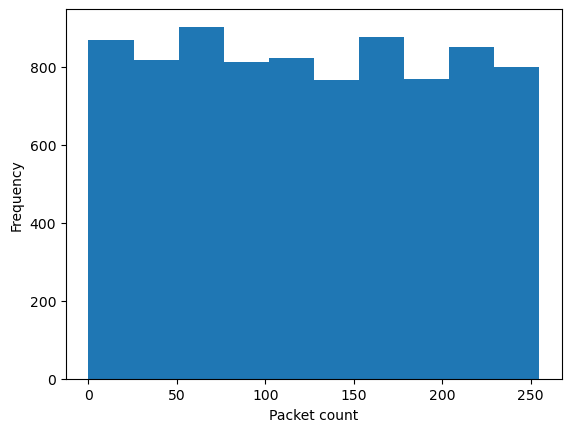

In [34]:
plt.hist(train_df['packet_counter'])
plt.xlabel('Packet count')
plt.ylabel('Frequency');

This variable is almost uniformly distributed and also suffers from rounding by 256, and as such it is likely useless.

### signal_strength

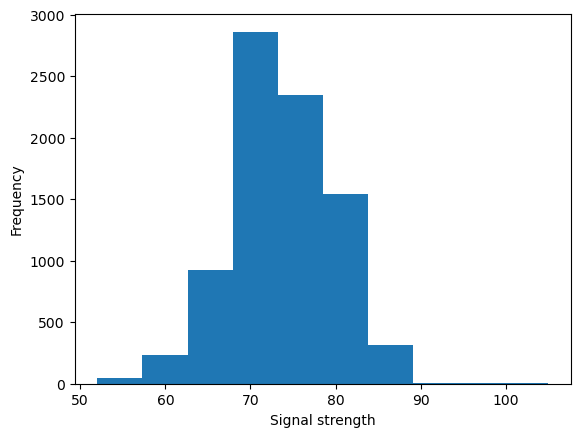

In [35]:
plt.hist(train_df['signal_strength'])
plt.xlabel('Signal strength')
plt.ylabel('Frequency');

A basic spatial information about bridges can be extracted from the signal strengths: the higher 'signal_strength' values mean weaker signal, and thus further away from the assets. 

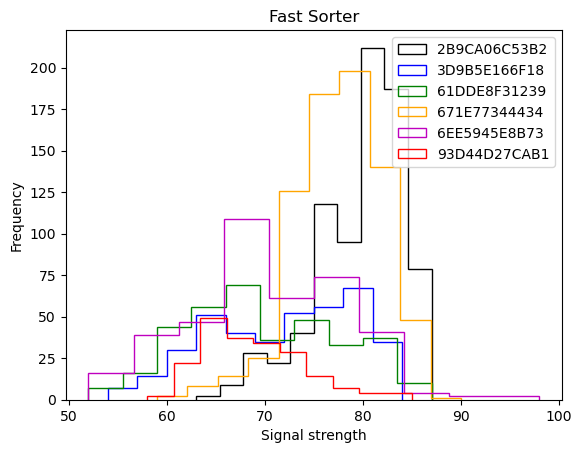

In [36]:
colors = ['k','b','g','orange','m','r']
bridgeIds_sorter = train_df.loc[train_df['zone_name']=='FastSorter', 'bridgeId'].unique()
for i in range(len(bridgeIds_sorter)):
    plt.hist(train_df.loc[train_df['bridgeId']==bridgeIds_sorter[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_sorter[i])
plt.title('Fast Sorter')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

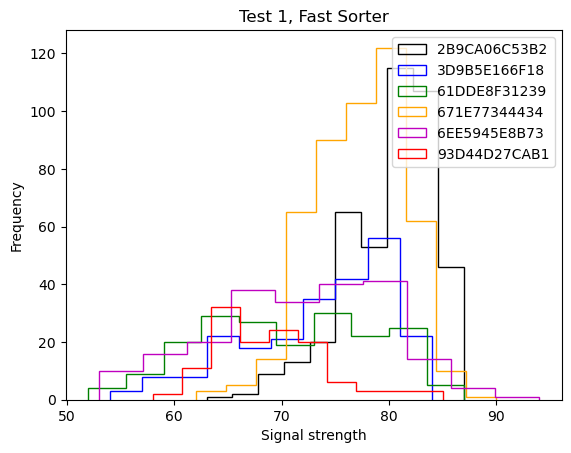

In [37]:
colors = ['k','b','g','orange','m','r']
bridgeIds_sorter = train_df_test1.loc[train_df_test1['zone_name']=='FastSorter', 'bridgeId'].unique()
for i in range(len(bridgeIds_sorter)):
    plt.hist(train_df_test1.loc[train_df_test1['bridgeId']==bridgeIds_sorter[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_sorter[i])
plt.title('Test 1, Fast Sorter')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

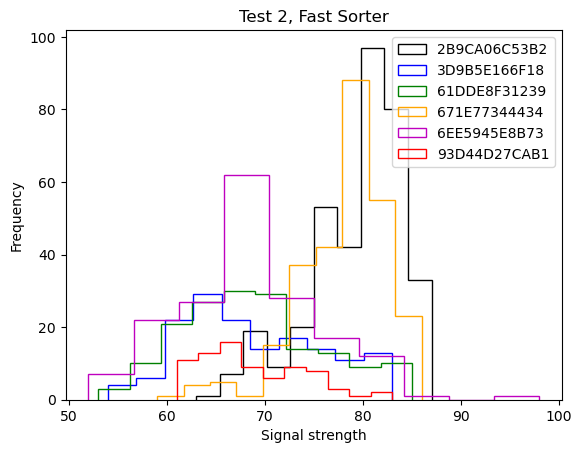

In [38]:
colors = ['k','b','g','orange','m','r']
bridgeIds_sorter = train_df_test2.loc[train_df_test2['zone_name']=='FastSorter', 'bridgeId'].unique()
for i in range(len(bridgeIds_sorter)):
    plt.hist(train_df_test2.loc[train_df_test2['bridgeId']==bridgeIds_sorter[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_sorter[i])
plt.title('Test 2, Fast Sorter')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

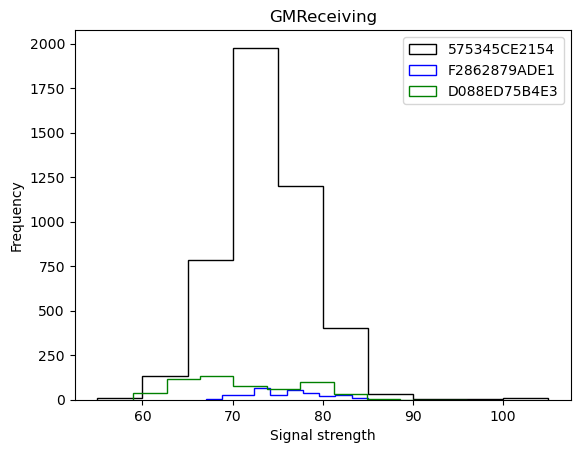

In [39]:
colors = ['k','b','g','orange','m','r']
bridgeIds_receiv = train_df.loc[train_df['zone_name']=='GMReceiving', 'bridgeId'].unique()
for i in range(len(bridgeIds_receiv)):
    plt.hist(train_df.loc[train_df['bridgeId']==bridgeIds_receiv[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_receiv[i])
plt.title('GMReceiving')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

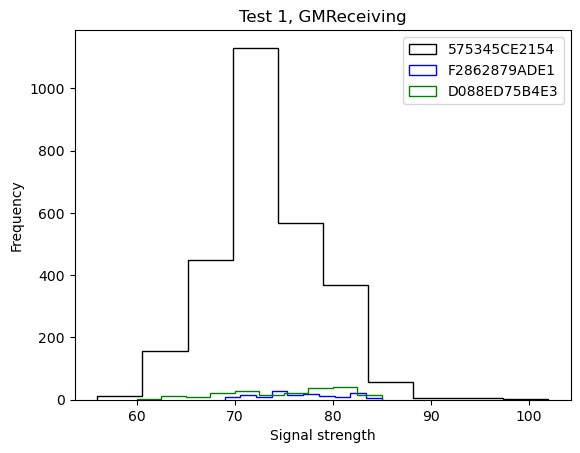

In [40]:
colors = ['k','b','g','orange','m','r']
bridgeIds_receiv = train_df_test1.loc[train_df_test1['zone_name']=='GMReceiving', 'bridgeId'].unique()
for i in range(len(bridgeIds_receiv)):
    plt.hist(train_df_test1.loc[train_df_test1['bridgeId']==bridgeIds_receiv[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_receiv[i])
plt.title('Test 1, GMReceiving')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

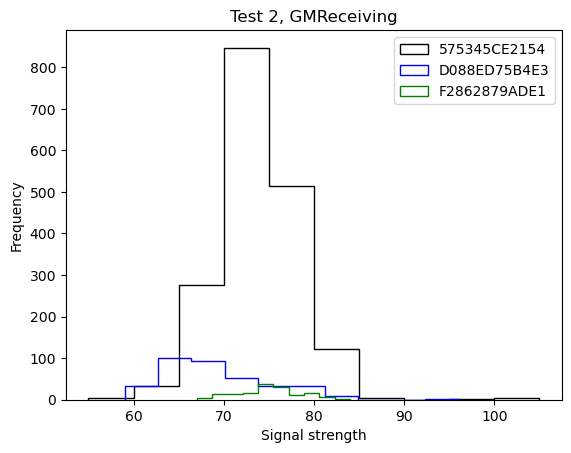

In [41]:
colors = ['k','b','g','orange','m','r']
bridgeIds_receiv = train_df_test2.loc[train_df_test2['zone_name']=='GMReceiving', 'bridgeId'].unique()
for i in range(len(bridgeIds_receiv)):
    plt.hist(train_df_test2.loc[train_df_test2['bridgeId']==bridgeIds_receiv[i], 'signal_strength'], color=colors[i], histtype='step', label=bridgeIds_receiv[i])
plt.title('Test 2, GMReceiving')
plt.xlabel('Signal strength')
plt.ylabel('Frequency')
plt.legend();

In [42]:
bridgeIds

array(['2B9CA06C53B2', '3D9B5E166F18', '575345CE2154', '61DDE8F31239',
       '671E77344434', '6EE5945E8B73', '93D44D27CAB1', 'F2862879ADE1',
       'D088ED75B4E3'], dtype=object)

One of the bridges strongly dominates in the number of records. In test 2, bridges 'F2862879ADE1' and especially 'D088ED75B4E3' had stronger signals (lover signal strength values).

### temperature

In [43]:
train_df['temperature'].value_counts()

23.5    1696
24.0    1639
24.5    1286
23.0    1118
25.0     798
25.5     522
26.0     391
22.5     381
26.5     284
22.0     118
27.0      34
21.5      15
28.5       7
Name: temperature, dtype: int64

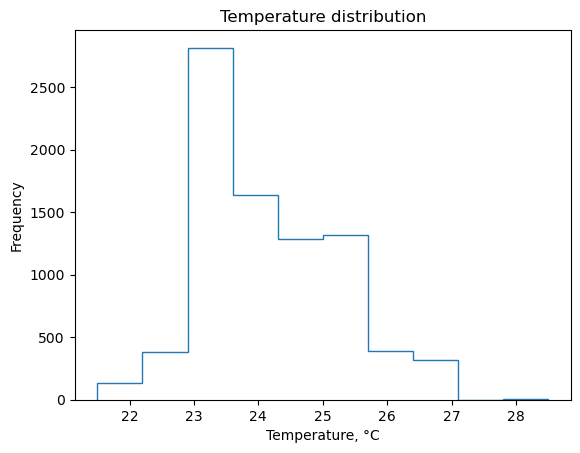

In [44]:
plt.title('Temperature distribution')
plt.hist(train_df['temperature'], histtype='step')
plt.xlabel('Temperature, °C')
plt.ylabel('Frequency');

Let us see if there is a difference in temperature between the two tests.

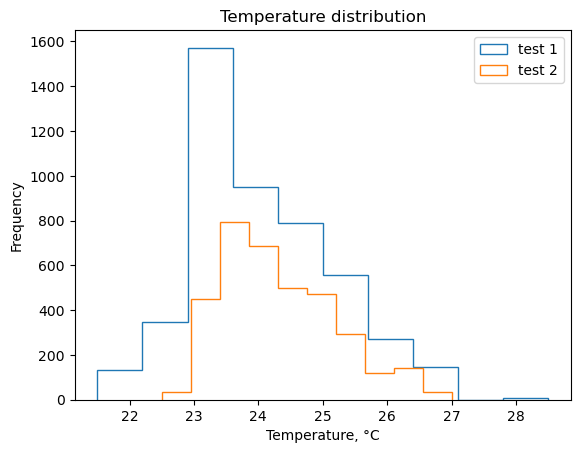

In [45]:
plt.title('Temperature distribution')
plt.hist(train_df_test1['temperature'], histtype='step', label='test 1')
plt.hist(train_df_test2['temperature'], histtype='step', label='test 2')
plt.xlabel('Temperature, °C')
plt.legend()
plt.ylabel('Frequency');

Test 2 has less variation in temperature, but the distributions are similar.
Let us see if there is a difference in temperature between the two zones.

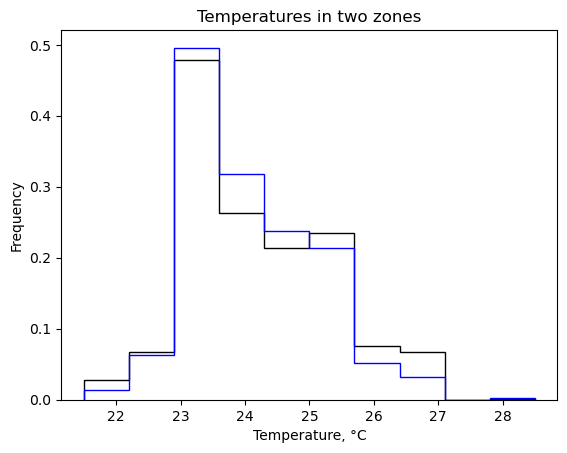

In [46]:
plt.title("Temperatures in two zones")
plt.hist(train_df.loc[train_df['zone_name']=='GMReceiving', 'temperature'], histtype='step', color='k', label='GMReceiving', density=True)
plt.hist(train_df.loc[train_df['zone_name']=='FastSorter', 'temperature'], histtype='step', color='b', label='FastSorter', density=True)
plt.xlabel('Temperature, °C')
plt.ylabel('Frequency');

Distributions of temperatures are similar in the two zones.

### nfpkt

In [47]:
train_df['nfpkt'].value_counts()

0     4124
1     1542
2     1068
3      595
4      426
5      248
6      125
7       62
8       30
9       23
10      22
11      12
13       4
14       4
12       3
15       1
Name: nfpkt, dtype: int64

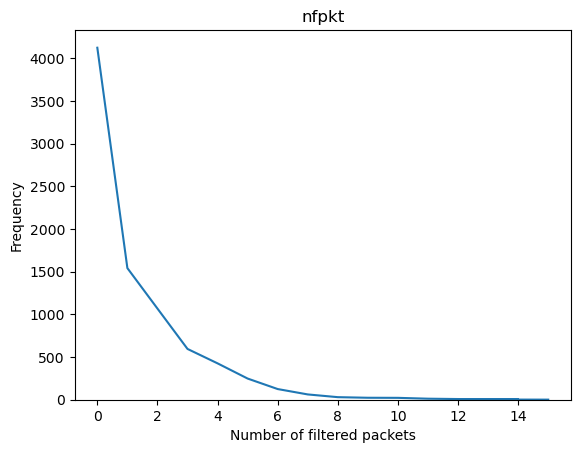

In [48]:
plt.title('nfpkt')
plt.plot(train_df['nfpkt'].value_counts())
plt.xlabel('Number of filtered packets')
plt.ylim(0,)
plt.ylabel('Frequency');

### interal_oscillation

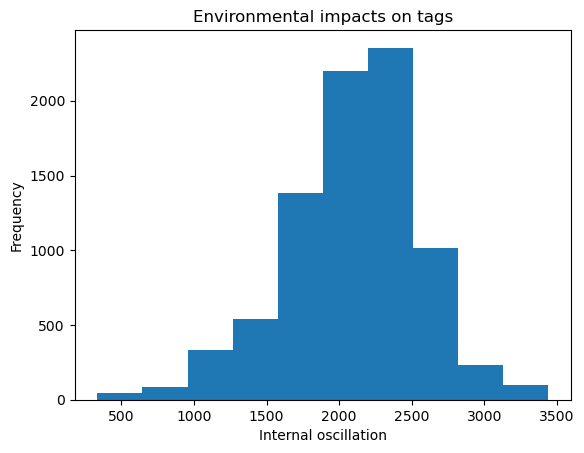

In [49]:
plt.title('Environmental impacts on tags')
plt.hist(train_df['interal_oscillation'])
plt.xlabel('Internal oscillation')
plt.ylabel('Frequency');

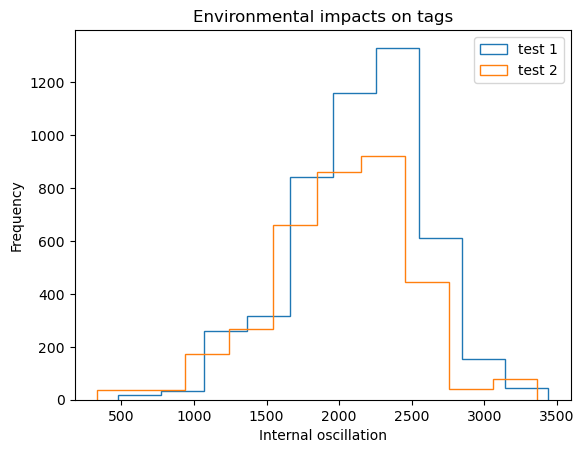

In [50]:
plt.title('Environmental impacts on tags')
plt.hist(train_df_test1['interal_oscillation'], histtype='step', label='test 1')
plt.hist(train_df_test2['interal_oscillation'], histtype='step', label='test 2')
plt.xlabel('Internal oscillation')
plt.legend()
plt.ylabel('Frequency');

Distributions of internal oscillation are similar for the two tests. Is internal oscillation related to temperature, signal strength, and packet count?

#### Correlation
Let us calculate the Pearson's correlation coefficient <i>R</i> for the dependent variable 'interal_oscillation' with each independent variable.

In [51]:
print("Correlation R with 'interal_oscillation':")
for xv in ['temperature','signal_strength','packet_counter']:
    R= np.corrcoef(train_df[xv], train_df['interal_oscillation'])[0,1]
    print(xv,R)

Correlation R with 'interal_oscillation':
temperature 0.038430430789569384
signal_strength 0.0017471617329320017
packet_counter 0.013324823706464178


All Pearson's correlation coefficients are small, there is no significant correlation.

Let us see if this correlation improves within each bridge.

In [52]:
bridgeId = bridgeIds[0] #Choose 0-8
bridge_df = train_df.loc[train_df['bridgeId']==bridgeId]

print(f"Correlation |R| with 'interal_oscillation' for bridge {bridgeId}:")
corrs = {} # dictionary of |correlation values| with y
for xv in ['temperature','signal_strength','packet_counter']:
    R= np.corrcoef(bridge_df[xv], bridge_df['interal_oscillation'])[0,1]
    print(xv,R)
    corrs[xv] = abs(R)

Correlation |R| with 'interal_oscillation' for bridge 2B9CA06C53B2:
temperature -0.07868675848198708
signal_strength 0.0006850971502305193
packet_counter 0.03154637122343604


There is no significant improvement in correlation for a fixed bridge.

### unload_timestamp
Consider the distribution of time lapsed from the earliest signal in a test until an asset is unloaded across assets.

Left edge of the first bin: 9.0
Bin width: 1
Right edge of the last bin: 18.0


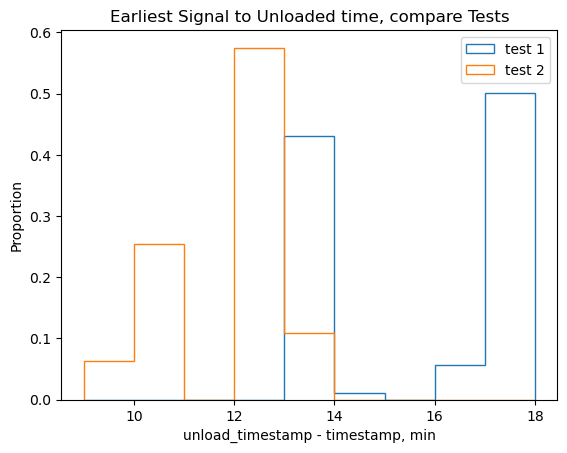

In [53]:
dt1 = 1e-3/60*(train_df_test1['unload_timestamp'] - time_earliest_test1) # Time from the earliest signal in test 1 to unloading, min
dt2 = 1e-3/60*(train_df_test2['unload_timestamp'] - time_earliest_test2) # Time from the earliest signal in test 2 to unloading, min
# Bin edges, including the left edge of the first bin and the right edge of the last bin:
dt_min = np.floor(np.min([np.min(dt1), np.min(dt2)]))
dt_max = np.ceil(np.max([np.max(dt1), np.max(dt2)]))
dt_bins = np.arange(dt_min, dt_max+0.1)
print("Left edge of the first bin:", dt_min)
print("Bin width:", 1)
print("Right edge of the last bin:", dt_max)
plt.title('Earliest Signal to Unloaded time, compare Tests')
plt.hist(dt1, bins=dt_bins, histtype='step', label='test 1', density=True)
plt.hist(dt2, bins=dt_bins, histtype='step', label='test 2', density=True)
plt.xlabel('unload_timestamp - timestamp, min')
plt.ylabel('Proportion')
plt.legend()
plt.show()

Consider the distribution of time lapsed from the signal till unloaded across assets and signals.

Left edge of the first bin: -15.0
Bin width: 1
Right edge of the last bin: 18.0


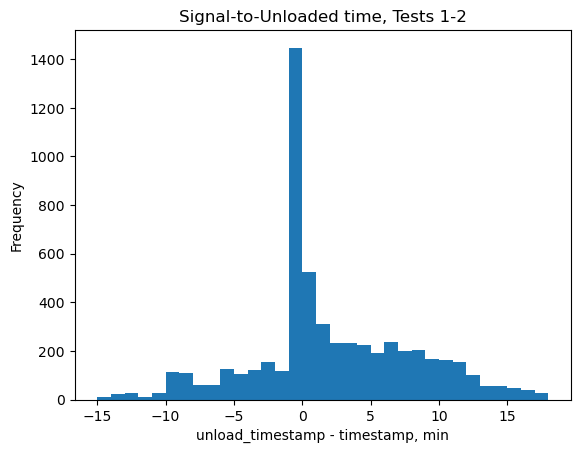

In [54]:
dt = 1e-3/60*(train_df['unload_timestamp'] - train_df['timestamp']) # signal-to-unload time difference, min
# Bin edges, including the left edge of the first bin and the right edge of the last bin:
dt_min = np.floor(np.min(dt))
dt_max = np.ceil(np.max(dt))
dt_bins = np.arange(dt_min, dt_max+0.1)
print("Left edge of the first bin:", dt_min)
print("Bin width:", 1)
print("Right edge of the last bin:", dt_max)
plt.title('Signal-to-Unloaded time, Tests 1-2')
plt.hist(dt, bins=dt_bins)
plt.xlabel('unload_timestamp - timestamp, min')
plt.ylabel('Frequency');

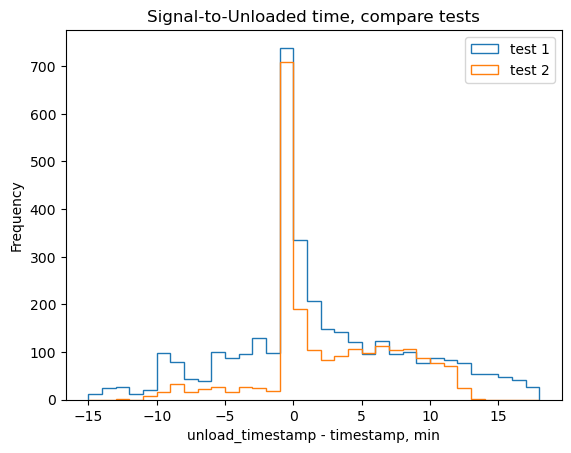

In [55]:
dt1 = 1e-3/60*(train_df_test1['unload_timestamp'] - train_df_test1['timestamp']) # test 1
dt2 = 1e-3/60*(train_df_test2['unload_timestamp'] - train_df_test2['timestamp']) # test 2
plt.title('unload_timestamp - timestamp')
plt.title('Signal-to-Unloaded time, compare tests')
plt.hist(dt1, bins=dt_bins, histtype='step', label='test 1')
plt.hist(dt2, bins=dt_bins, histtype='step', label='test 2')
plt.xlabel('unload_timestamp - timestamp, min')
plt.ylabel('Frequency')
plt.legend()
plt.show();

Let's detailize over bridges.

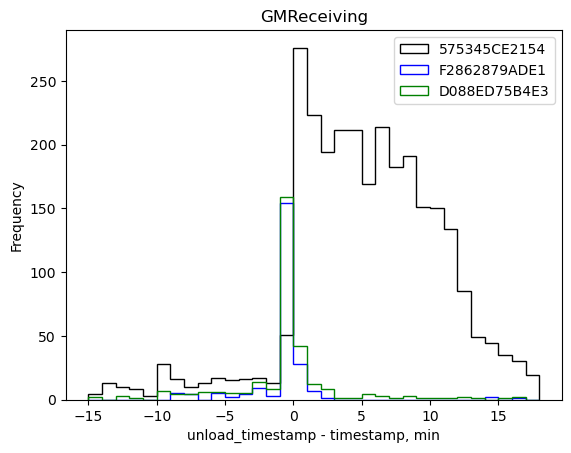

In [56]:
colors = ['k','b','g']
bridgeIds_receiv = train_df.loc[train_df['zone_name']=='GMReceiving', 'bridgeId'].unique()
for i in range(len(bridgeIds_receiv)):
    tmp_df = train_df.loc[train_df['bridgeId']==bridgeIds_receiv[i], ['timestamp','unload_timestamp']]
    plt.hist(1e-3/60*(tmp_df['unload_timestamp'] - tmp_df['timestamp']), color=colors[i], histtype='step',
             label=bridgeIds_receiv[i], bins=dt_bins)
plt.title('GMReceiving')
plt.xlabel('unload_timestamp - timestamp, min')
plt.ylabel('Frequency')
plt.legend();

Two bridges 'D088ED75B4E3' and 'F2862879ADE1' in 'GMReceiving' zone have a narrow peak close to zero time difference ([-1,0) minutes bin). For the remaining bridge '575345CE2154' in this zone, majority of the signals have a non-negative time difference, with the mode also close to zero difference ([0,1) minutes bin). These facts are useful for predicting unloading time, although rely on a suficiently large sample size of signals for a given asset.

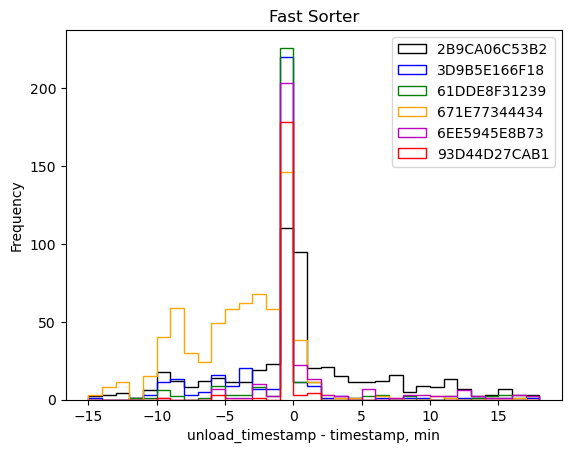

In [57]:
colors = ['k','b','g','orange','m','r']
bridgeIds_sorter = train_df.loc[train_df['zone_name']=='FastSorter', 'bridgeId'].unique()
for i in range(len(bridgeIds_sorter)):
    tmp_df = train_df.loc[train_df['bridgeId']==bridgeIds_sorter[i], ['timestamp','unload_timestamp']]
    plt.hist(1e-3/60*(tmp_df['unload_timestamp'] - tmp_df['timestamp']), color=colors[i], histtype='step',
             label=bridgeIds_sorter[i], bins=dt_bins)
plt.title('Fast Sorter')
plt.xlabel('unload_timestamp - timestamp, min')
plt.ylabel('Frequency')
plt.legend();

Likewise, all bridges in the Fast Sorter zone have a narrow peak close to zero signal-to-unload time difference (all in [-1,0) minutes bin).

### Differences between unloaded and not
Now let us try to find differences between records for assets that were and were not unloaded.

In [58]:
unloaded_df = train_df.loc[~train_df['unload_timestamp'].isna()]
idx_unloaded = unloaded_df.index
idx_unloaded

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288],
           dtype='int64', length=5682)

In [59]:
not_unloaded_df = train_df.loc[train_df['unload_timestamp'].isna()]
idx_not_unloaded = not_unloaded_df.index
idx_not_unloaded

Int64Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
            ...
            6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803],
           dtype='int64', length=2607)

In [60]:
not_unloaded_df

,pixel_id,timestamp,test,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
1961,T2273,1683904689130,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,99,83,26.0,0,2415.2932,NaN
1962,T2273,1683905233100,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,238,82,24.0,0,2439.4434,NaN
1963,T2273,1683905319955,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,252,85,24.0,0,2444.4434,NaN
1964,T2273,1683905503519,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,27,86,24.0,0,2440.4434,NaN
1965,T2273,1683905563481,test_1,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,37,85,24.0,0,2445.4434,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6799,T2313,1683909222262,test_2,GW0CDC7EDB200C,6EE5945E8B73,FastSorter,62,82,26.5,0,2503.7437,NaN
6800,T2313,1683909353606,test_2,GW0CDC7EDB200C,6EE5945E8B73,FastSorter,111,75,26.5,0,2495.7437,NaN
6801,T2313,1683909237251,test_2,GW0CDC7EDB200C,D088ED75B4E3,GMReceiving,67,83,26.5,0,2505.7437,NaN
6802,T2313,1683909387582,test_2,GW0CDC7EDB200C,D088ED75B4E3,GMReceiving,123,69,26.5,0,2512.7437,NaN


In [61]:
unloaded_df['bridgeId'].value_counts()

575345CE2154    2802
671E77344434     693
2B9CA06C53B2     515
3D9B5E166F18     348
D088ED75B4E3     308
61DDE8F31239     303
6EE5945E8B73     298
F2862879ADE1     225
93D44D27CAB1     190
Name: bridgeId, dtype: int64

In [62]:
not_unloaded_df['bridgeId'].value_counts()

575345CE2154    1754
2B9CA06C53B2     277
D088ED75B4E3     249
6EE5945E8B73      97
F2862879ADE1      73
61DDE8F31239      53
671E77344434      53
3D9B5E166F18      39
93D44D27CAB1      12
Name: bridgeId, dtype: int64

Let us find probabilities of bridges for each pixel_id and see the difference in probabilities between pixels that were and were not unloaded.

In [63]:
bridgeIds

array(['2B9CA06C53B2', '3D9B5E166F18', '575345CE2154', '61DDE8F31239',
       '671E77344434', '6EE5945E8B73', '93D44D27CAB1', 'F2862879ADE1',
       'D088ED75B4E3'], dtype=object)

In [64]:
pixel_bridge_prob = np.zeros((len(pixel_ids),len(bridgeIds))) # probability for each pixel and bridge
for i in range(len(pixel_ids)):
    pixel_id = pixel_ids[i]
    pixel_df = train_df.loc[train_df['pixel_id']==pixel_id]
    nr = pixel_df.shape[0] # number of records for this asset 
    for b in range(len(bridgeIds)):
        bridgeId = bridgeIds[b]
        pixel_bridge_df = pixel_df.loc[pixel_df['bridgeId']==bridgeId]
        pixel_bridge_prob[i][b] = pixel_bridge_df.shape[0]/nr
    print(pixel_id,pixel_bridge_prob[i])

T2213 [0.09302326 0.04651163 0.51162791 0.06976744 0.04651163 0.06976744
 0.04651163 0.09302326 0.02325581]
T2214 [0.06779661 0.08474576 0.45762712 0.05084746 0.22033898 0.01694915
 0.01694915 0.03389831 0.05084746]
T2215 [0.07352941 0.04411765 0.47058824 0.05882353 0.17647059 0.02941176
 0.02941176 0.02941176 0.08823529]
T2216 [0.15942029 0.04347826 0.43478261 0.01449275 0.23188406 0.02898551
 0.02898551 0.01449275 0.04347826]
T2217 [0.04545455 0.06818182 0.65909091 0.04545455 0.06818182 0.02272727
 0.02272727 0.02272727 0.04545455]
T2218 [0.07142857 0.07142857 0.5952381  0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.02380952]
T2219 [0.08928571 0.07142857 0.48214286 0.07142857 0.17857143 0.01785714
 0.01785714 0.03571429 0.03571429]
T2220 [0.07692308 0.09615385 0.44230769 0.03846154 0.17307692 0.03846154
 0.01923077 0.09615385 0.01923077]
T2221 [0.11320755 0.03773585 0.49056604 0.03773585 0.1509434  0.03773585
 0.03773585 0.05660377 0.03773585]
T2222 [0.0625     0.0625    

T2324 [0.06896552 0.06896552 0.34482759 0.10344828 0.10344828 0.10344828
 0.06896552 0.06896552 0.06896552]
T2325 [0.17647059 0.04411765 0.52941176 0.04411765 0.13235294 0.01470588
 0.02941176 0.01470588 0.01470588]
T2326 [0.125      0.05357143 0.55357143 0.05357143 0.03571429 0.07142857
 0.03571429 0.03571429 0.03571429]
T2327 [0.04878049 0.04878049 0.65853659 0.09756098 0.         0.04878049
 0.02439024 0.04878049 0.02439024]
T2328 [0.1  0.1  0.1  0.1  0.15 0.15 0.1  0.1  0.1 ]
T2329 [0.         0.06818182 0.65909091 0.06818182 0.11363636 0.04545455
 0.04545455 0.         0.        ]
T2330 [0.16923077 0.06153846 0.36923077 0.09230769 0.13846154 0.07692308
 0.01538462 0.01538462 0.06153846]
T2331 [0.03571429 0.07142857 0.46428571 0.10714286 0.03571429 0.07142857
 0.07142857 0.07142857 0.07142857]
T2332 [0.14285714 0.07142857 0.28571429 0.10714286 0.03571429 0.14285714
 0.03571429 0.07142857 0.10714286]
T2333 [0.06521739 0.06521739 0.41304348 0.08695652 0.19565217 0.04347826
 0.0217391

In [65]:
pixel_ids_unloaded = unloaded_df['pixel_id'].unique()
print("Unloaded assets:", pixel_ids_unloaded)
pixel_ids_not_unloaded = not_unloaded_df['pixel_id'].unique()
print("Not unloaded assets:", pixel_ids_not_unloaded)

Unloaded assets: ['T2213' 'T2214' 'T2215' 'T2216' 'T2217' 'T2218' 'T2219' 'T2220' 'T2221'
 'T2222' 'T2223' 'T2224' 'T2225' 'T2226' 'T2227' 'T2228' 'T2229' 'T2230'
 'T2231' 'T2232' 'T2233' 'T2234' 'T2235' 'T2236' 'T2237' 'T2238' 'T2239'
 'T2240' 'T2241' 'T2242' 'T2243' 'T2244' 'T2245' 'T2246' 'T2247' 'T2248'
 'T2249' 'T2250' 'T2251' 'T2252' 'T2253' 'T2254' 'T2256' 'T2257' 'T2258'
 'T2259' 'T2260' 'T2261' 'T2262' 'T2263' 'T2264' 'T2265' 'T2266' 'T2267'
 'T2268' 'T2269' 'T2270' 'T2271' 'T2272' 'T2314' 'T2315' 'T2316' 'T2317'
 'T2318' 'T2319' 'T2320' 'T2321' 'T2322' 'T2323' 'T2324' 'T2325' 'T2326'
 'T2327' 'T2328' 'T2329' 'T2330' 'T2331' 'T2332' 'T2333' 'T2334' 'T2335'
 'T2336' 'T2337' 'T2338' 'T2339' 'T2340' 'T2341' 'T2342' 'T2343' 'T2344'
 'T2345' 'T2346' 'T2347' 'T2348' 'T2349' 'T2350' 'T2351' 'T2352' 'T2353'
 'T2354' 'T2355' 'T2356' 'T2357' 'T2358' 'T2359' 'T2360' 'T2361' 'T2362'
 'T2363' 'T2364' 'T2365' 'T2366' 'T2367' 'T2368' 'T2369' 'T2370' 'T2371'
 'T2372' 'T2373' 'T2374' 'T2375' '

In [66]:
# Find indexes of unloaded and not unloaded assets in the list of all assets
pixels_unloaded_idx = []
pixels_not_unloaded_idx = []
for pixel_id in pixel_ids_unloaded:
    pixels_unloaded_idx.append(np.where(pixel_ids == pixel_id)[0][0])
for pixel_id in pixel_ids_not_unloaded:
    pixels_not_unloaded_idx.append(np.where(pixel_ids == pixel_id)[0][0])
print('Unloaded pixel indexes:', pixels_unloaded_idx)
print('Not unloaded pixel indexes:', pixels_not_unloaded_idx)

Unloaded pixel indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]
Not unloaded pixel indexes: [59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]


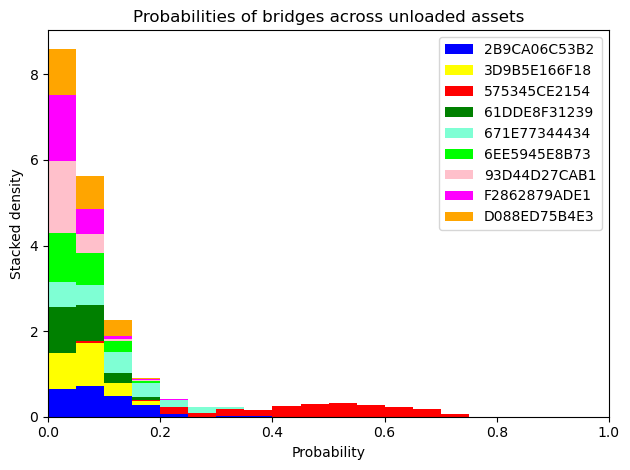

In [67]:
colors_bridges = ['blue', 'yellow', 'red', 'green', 'aquamarine', 'lime', 'pink', 'magenta', 'orange']
prob_bins = np.arange(0,1+0.05,0.05)
plt.hist(pixel_bridge_prob[pixels_unloaded_idx], bins=prob_bins, density=True, histtype='bar', stacked=True, color=colors_bridges)
plt.title('Probabilities of bridges across unloaded assets')
plt.xlim(0,1)
plt.xlabel('Probability')
plt.ylabel('Stacked density')
plt.tight_layout()
legend = {}
for i in range(len(bridgeIds)):
    legend[bridgeIds[i]] = colors_bridges[i]
plt.legend(legend)
plt.show()

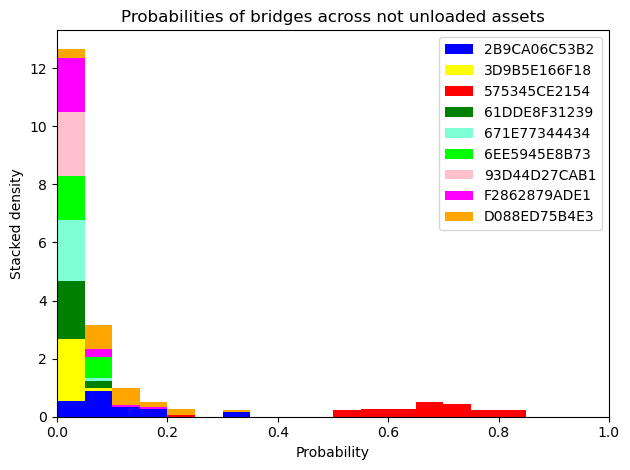

In [68]:
plt.hist(pixel_bridge_prob[pixels_not_unloaded_idx], bins=prob_bins, density=True, histtype='bar', stacked=True, color=colors_bridges)
plt.title('Probabilities of bridges across not unloaded assets')
plt.xlim(0,1)
plt.xlabel('Probability')
plt.ylabel('Stacked density')
plt.tight_layout()
plt.legend(legend)
plt.show()

Not unloaded assets typically have smaller relative probabilities for most bridges.

Probabilities of bridges could be used for making binary predictions of unloading. E.g., a high probability of bridge '575345CE2154' in 'GMReceiving' zone within `[0.8-0.85)` signifies that the asset was not unloaded. Likewise, a high probability of bridge '2B9CA06C53B2' in 'FastSorter' zone within `[0.35-0.4)` signifies that the asset was unloaded.

## Data Pre-processing

In [69]:
#Please do data cleaning and pre-processing here
#create as many cells as necessary 

### Correct Timestamps for Test 2
Let us offset all timestamps (`timestamp` and `unload_timestamp`) and rename pixels in Test 2.

In [70]:
time_offset = 1e3*3600 # 1 hr -> ms
train_df.loc[train_df['test'] == 'test_2', 'timestamp'] -= time_offset
train_df.loc[train_df['test'] == 'test_2', 'unload_timestamp'] -= time_offset # more convenient before imputing nan values

In [71]:
train_df.loc[train_df['test'] == 'test_2', 'pixel_id'] += '_2' # append '_2' to all pixel IDs from test 2
pixel_ids = train_df['pixel_id'].unique()
print("pixel_ids =", pixel_ids)

pixel_ids = ['T2213' 'T2214' 'T2215' 'T2216' 'T2217' 'T2218' 'T2219' 'T2220' 'T2221'
 'T2222' 'T2223' 'T2224' 'T2225' 'T2226' 'T2227' 'T2228' 'T2229' 'T2230'
 'T2231' 'T2232' 'T2233' 'T2234' 'T2235' 'T2236' 'T2237' 'T2238' 'T2239'
 'T2240' 'T2241' 'T2242' 'T2243' 'T2244' 'T2245' 'T2246' 'T2247' 'T2248'
 'T2249' 'T2250' 'T2251' 'T2252' 'T2253' 'T2254' 'T2256' 'T2257' 'T2258'
 'T2259' 'T2260' 'T2261' 'T2262' 'T2263' 'T2264' 'T2265' 'T2266' 'T2267'
 'T2268' 'T2269' 'T2270' 'T2271' 'T2272' 'T2273' 'T2274' 'T2275' 'T2276'
 'T2277' 'T2278' 'T2279' 'T2280' 'T2281' 'T2282' 'T2283' 'T2284' 'T2285'
 'T2286' 'T2287' 'T2288' 'T2289' 'T2290' 'T2291' 'T2292' 'T2293' 'T2294'
 'T2295' 'T2296' 'T2297' 'T2298' 'T2299' 'T2300' 'T2301' 'T2302' 'T2304'
 'T2305' 'T2306' 'T2307' 'T2308' 'T2309' 'T2310' 'T2311' 'T2312' 'T2313'
 'T2314' 'T2315' 'T2316' 'T2317' 'T2318' 'T2319' 'T2320' 'T2321' 'T2322'
 'T2323' 'T2324' 'T2325' 'T2326' 'T2327' 'T2328' 'T2329' 'T2330' 'T2331'
 'T2332' 'T2333' 'T2334' 'T2335' 'T2336

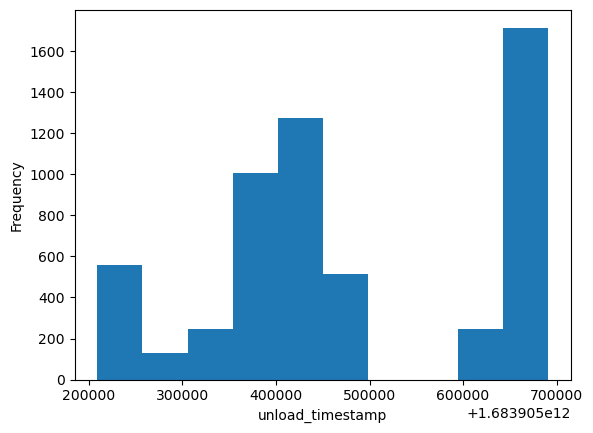

In [72]:
plt.hist(train_df.loc[idx_unloaded, 'unload_timestamp'])
#plt.hist(train_df.loc[idx_unloaded, 'unload_timestamp'] - train_df.loc[idx_unloaded, 'timestamp'])
plt.xlabel('unload_timestamp')
plt.ylabel('Frequency');

In [73]:
time_earliest_train = np.min(train_df['timestamp'])
time_earliest_str = ms2datetime(time_earliest_train)
print(f"After offsetting Test 2, the earliest signal time is {time_earliest_train} ({time_earliest_str})")

After offsetting Test 2, the earliest signal time is 1683904620157 (2023-05-12 11:17:00.157)


### Impute missing values

Replace null values in `unload_timestamp` when an asset is not unloaded with 0.

In [74]:
train_df.loc[train_df['unload_timestamp'].isna(), 'unload_timestamp'] = 0
#train_df.fillna(0)
train_df.isna().sum() # Number of missing values

pixel_id               0
timestamp              0
test                   0
gatewayId              0
bridgeId               0
zone_name              0
packet_counter         0
signal_strength        0
temperature            0
nfpkt                  0
interal_oscillation    0
unload_timestamp       0
dtype: int64

### Encode categorical values

No more missing values.

Encode binary categorical variables with integer 0/1 values.

In [75]:
train_df.loc[train_df['gatewayId']==gatewayIds[0], 'gatewayId'] = 0 # 'GW0CDC7EDB200C'
train_df.loc[train_df['gatewayId']==gatewayIds[1], 'gatewayId'] = 1 # 'GW0CDC7EDB0708'
train_df.rename(columns = {'gatewayId':'gateway'}, inplace = True) # rename column

In [76]:
zone_names = ['GMReceiving','FastSorter']
train_df.loc[train_df['zone_name']==zone_names[0], 'zone_name'] = 0
train_df.loc[train_df['zone_name']==zone_names[1], 'zone_name'] = 1
train_df.rename(columns = {'zone_name':'zone'}, inplace = True)

Label encoding of `bridgeId`.

In [77]:
print("Bridges of 'GMReceiving' zone 0:", train_df.loc[train_df['zone']==0,'bridgeId'].unique())
print("Bridges of 'FastSorter' zone 1:", train_df.loc[train_df['zone']==1,'bridgeId'].unique())

Bridges of 'GMReceiving' zone 0: ['575345CE2154' 'F2862879ADE1' 'D088ED75B4E3']
Bridges of 'FastSorter' zone 1: ['2B9CA06C53B2' '3D9B5E166F18' '61DDE8F31239' '671E77344434'
 '6EE5945E8B73' '93D44D27CAB1']


We use a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer">LabelBinarizer</a> to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape `n_samples` is mapped to a target of shape `n_samples, n_classes`.

In [78]:
# Rearrange bridgeIds: first three are from zone 0 (receiver), the rest are from zone 1 (fast sorter)
bridgeIds = list(np.sort(train_df.loc[train_df['zone']==0,'bridgeId'].unique()))
bridgeIds_zone1 = list(np.sort(train_df.loc[train_df['zone']==1,'bridgeId'].unique()))
for i in bridgeIds_zone1:
    bridgeIds.append(i)
print("bridgeIds =", bridgeIds)
# Binarized variable names
var_names_bridges = ['bridge_'+str(i) for i in bridgeIds]
print("var_names_bridges =", var_names_bridges)

bridgeIds = ['575345CE2154', 'D088ED75B4E3', 'F2862879ADE1', '2B9CA06C53B2', '3D9B5E166F18', '61DDE8F31239', '671E77344434', '6EE5945E8B73', '93D44D27CAB1']
var_names_bridges = ['bridge_575345CE2154', 'bridge_D088ED75B4E3', 'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18', 'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73', 'bridge_93D44D27CAB1']


In [79]:
label_binarizer = LabelBinarizer().fit(bridgeIds)
train_df[var_names_bridges] = label_binarizer.transform(train_df['bridgeId'])
train_df.drop(['bridgeId','zone'], axis=1, inplace=True)

### Feature scaling

In [80]:
# Normalization - useful when data are not normally distributed
scaler = MinMaxScaler() # Normalize data to range [0, 1]
timestamp_scaled = np.ravel(scaler.fit_transform(train_df['timestamp'].values.reshape(-1, 1)))
timestamp_scaled

array([0.05460474, 0.49390188, 0.6219906 , ..., 0.45489085, 0.45763227,
       0.45434613])

In [81]:
timestamp_unscaled = np.ravel(scaler.inverse_transform(timestamp_scaled.reshape(-1, 1))) == train_df['timestamp']
print("Exactly restored values:", np.sum(timestamp_unscaled))

Exactly restored values: 8289


All values are restored exactly.

However, let us use seconds relative to the earliest timestamp `time_earliest` in the dataframe.

In [82]:
# Subtract the earliest time in train set, rescale ms -> s
train_df['timestamp'] = 1e-3*(train_df['timestamp'] - time_earliest_train)
train_df.rename(columns = {'timestamp':'signal_time'}, inplace = True)

train_df['unload_time'] = [1e-3*(x - time_earliest_train) if x != 0 else 0 for x in train_df['unload_timestamp']]
train_df['unload_time'].value_counts()

0.000       2607
1065.843     329
1070.843     314
805.843      203
1060.843     202
            ... 
590.843        7
619.843        5
599.843        5
604.843        5
603.843        4
Name: unload_time, Length: 93, dtype: int64

### Drop unused variables

In [83]:
train_df.drop(columns=['test','unload_timestamp'], inplace=True)

### Sort data

Sort data by asset and then by signal time.

In [84]:
train_df = train_df.sort_values(by = ['pixel_id', 'signal_time'], ascending = [True, True])

### Label

Introduce the label `y`: 1 - unloaded, 0 - not unloaded.

In [85]:
train_df['unloaded'] = [1 if i != 0 else 0 for i in train_df['unload_time']]

## Feature Engineering

In [86]:
#If you plan on engineering features, please do so in this section.
#create as many cells as necessary 

In [87]:
train_df.head()

,pixel_id,signal_time,gateway,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,bridge_575345CE2154,bridge_D088ED75B4E3,bridge_F2862879ADE1,bridge_2B9CA06C53B2,bridge_3D9B5E166F18,bridge_61DDE8F31239,bridge_671E77344434,bridge_6EE5945E8B73,bridge_93D44D27CAB1,unload_time,unloaded
4,T2213,5.423,0,253,69,24.5,7,1897.6328,0,0,1,0,0,0,0,0,0,1060.843,1
24,T2213,33.169,0,18,83,24.5,0,1909.7828,0,0,0,1,0,0,0,0,0,1060.843,1
27,T2213,33.169,0,18,77,24.5,0,1909.7828,0,0,0,0,0,1,0,0,0,1060.843,1
30,T2213,74.755,0,51,84,24.5,0,1906.7828,0,0,0,0,0,0,0,0,1,1060.843,1
0,T2213,91.724,0,65,83,24.5,0,1910.6328,1,0,0,0,0,0,0,0,0,1060.843,1


In [88]:
col_names = ['pixel_id','gateway1p','signal_time_mean','signal_time_sd','packet_mean','packet_sd','signal_mean','signal_sd', 'temperature_mean', 'temperature_sd',
    'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd']
for i in var_names_bridges:
    col_names.append(i)
for i in var_names_bridges: # first bridge for a given asset
    col_names.append(i.replace('bridge','earliest'))
for i in var_names_bridges: # last bridge for a given asset
    col_names.append(i.replace('bridge','latest'))
col_names.append('dt_1')
#col_names.append('dt_last')
col_names.append('unload_time')
col_names.append('unloaded')

In [89]:
X = pd.DataFrame(columns=col_names)
for pixel_id in pixel_ids:
    pixel_df = train_df.loc[train_df['pixel_id'] == pixel_id] # all records for this asset
    nr = pixel_df.shape[0] # number of records for this asset
    gateway1proportion = np.sum(pixel_df['gateway'])/nr
    signal_time_mean = np.mean(pixel_df['signal_time'])
    signal_time_sd = np.std(pixel_df['signal_time'])
    packet_mean = np.mean(pixel_df['packet_counter'])
    packet_sd = np.std(pixel_df['packet_counter'])
    signal_mean = np.mean(pixel_df['signal_strength'])
    signal_sd = np.std(pixel_df['signal_strength'])
    temperature_mean = np.mean(pixel_df['temperature'])
    temperature_sd = np.std(pixel_df['temperature'])
    nfpkt_mean = np.mean(pixel_df['nfpkt'])
    nfpkt_sd = np.std(pixel_df['nfpkt'])
    oscillation_mean = np.mean(pixel_df['interal_oscillation'])
    oscillation_sd = np.std(pixel_df['interal_oscillation'])
    rec = [pixel_id, gateway1proportion, signal_time_mean, signal_time_sd, packet_mean, packet_sd, signal_mean, signal_sd, temperature_mean, temperature_sd,
        nfpkt_mean, nfpkt_sd, oscillation_mean, oscillation_sd]
    # Proportions of bridges
    for vn in var_names_bridges:
        vn_proportion = pixel_df[vn].sum()/nr
        rec.append(vn_proportion)
    # Event based features
    pixel_df = pixel_df.sort_values(by = ['signal_time'], ascending = [True]) # sort asset records by signal time
    # Earliest bridge 0/1
    bridge_0 = pixel_df.iloc[0][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_0:
        rec.append(bl)
    # Latest bridge 0/1
    bridge_last = pixel_df.iloc[-1][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_last:
        rec.append(bl)
    # Time from the earliest signal to the next signal 1
    if nr > 1:
        dt_1 = pixel_df.iloc[1]['signal_time'] - pixel_df.iloc[0]['signal_time']
        #dt_last = pixel_df.iloc[-1]['signal_time'] - pixel_df.iloc[0]['signal_time']
    else:
        dt_1 = 0 # If the asset had only one signal, set to 0
        #dt_last = 0
    rec.append(dt_1)
    #rec.append(dt_last)
    rec.append(pixel_df['unload_time'].iloc[0]) # all values of 'unload_time' are same for the same asset
    rec.append(pixel_df['unloaded'].iloc[0]) # all values of 'unloaded' are same for the same asset
    X.loc[len(X)] = rec
# Set index to column 'pixel_id'
X.index = X['pixel_id']
X.drop(columns='pixel_id', inplace=True)

In [90]:
X.columns

Index(['gateway1p', 'signal_time_mean', 'signal_time_sd', 'packet_mean',
       'packet_sd', 'signal_mean', 'signal_sd', 'temperature_mean',
       'temperature_sd', 'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean',
       'oscillation_sd', 'bridge_575345CE2154', 'bridge_D088ED75B4E3',
       'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18',
       'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73',
       'bridge_93D44D27CAB1', 'earliest_575345CE2154', 'earliest_D088ED75B4E3',
       'earliest_F2862879ADE1', 'earliest_2B9CA06C53B2',
       'earliest_3D9B5E166F18', 'earliest_61DDE8F31239',
       'earliest_671E77344434', 'earliest_6EE5945E8B73',
       'earliest_93D44D27CAB1', 'latest_575345CE2154', 'latest_D088ED75B4E3',
       'latest_F2862879ADE1', 'latest_2B9CA06C53B2', 'latest_3D9B5E166F18',
       'latest_61DDE8F31239', 'latest_671E77344434', 'latest_6EE5945E8B73',
       'latest_93D44D27CAB1', 'dt_1', 'unload_time', 'unloaded'],
      dtype='objec

In [91]:
pd.pivot_table(X[['gateway1p','unload_time']], index=['gateway1p','unload_time'])

Empty DataFrame
Columns: []
Index: [(0.0, 0.0), (0.0, 588.843), (0.0, 590.843), (0.0, 591.843), (0.0, 593.843), (0.0, 594.843), (0.0, 598.843), (0.0, 599.843), (0.0, 600.843), (0.0, 602.843), (0.0, 603.843), (0.0, 604.843), (0.0, 607.843), (0.0, 608.843), (0.0, 612.843), (0.0, 614.843), (0.0, 615.843), (0.0, 618.843), (0.0, 619.843), (0.0, 621.843), (0.0, 622.843), (0.0, 623.843), (0.0, 626.843), (0.0, 629.843), (0.0, 634.843), (0.0, 637.843), (0.0, 641.843), (0.0, 645.843), (0.0, 647.843), (0.0, 726.843), (0.0, 728.843), (0.0, 729.843), (0.0, 730.843), (0.0, 734.843), (0.0, 742.843), (0.0, 744.843), (0.0, 749.843), (0.0, 753.843), (0.0, 757.843), (0.0, 760.843), (0.0, 765.843), (0.0, 766.843), (0.0, 769.843), (0.0, 775.843), (0.0, 777.843), (0.0, 779.843), (0.0, 781.843), (0.0, 782.843), (0.0, 783.843), (0.0, 785.843), (0.0, 786.843), (0.0, 788.843), (0.0, 789.843), (0.0, 790.843), (0.0, 791.843), (0.0, 792.843), (0.0, 794.843), (0.0, 798.843), (0.0, 800.843), (0.0, 805.843), (0.0, 812.843), (0.0, 817.843), (0.0, 818.843), (0.0, 821.843), (0.0, 831.843), (0.0, 833.843), (0.0, 835.843), (0.0, 837.843), (0.0, 838.843), (0.0, 839.843), (0.0, 841.843), (0.0, 842.843), (0.0, 1015.8430000000001), (0.0, 1018.8430000000001), (0.0, 1020.8430000000001), (0.0, 1023.8430000000001), (0.0, 1027.843), (0.0, 1034.843), (0.0, 1037.843), (0.0, 1039.843), (0.0, 1042.843), (0.0, 1054.843), (0.0, 1056.843), (0.0, 1060.843), (0.0, 1065.843), (0.0, 1070.843), (0.017543859649122806, 0.0), (0.017543859649122806, 1060.843), (0.01818181818181818, 0.0), (0.019230769230769232, 0.0), (0.02, 0.0), (0.02127659574468085, 0.0), (0.022222222222222223, 0.0), (0.022727272727272728, 1042.843), (0.023809523809523808, 0.0), (0.024390243902439025, 1037.843), (0.025, 0.0), (0.02564102564102564, 1034.843), (0.027777777777777776, 0.0), (0.02857142857142857, 0.0), ...]

[161 rows x 0 columns]

In [92]:
X

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1,unload_time,unloaded
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,556.132824,384.553175,112.235294,66.057043,71.411765,7.300756,24.500000,0.000000,2.882353,...,0,0,0,0,1,0,0,27.746,1060.843,1
T2214,0.000000,942.235360,385.640097,124.420000,80.505177,72.160000,6.050983,24.320000,0.384187,1.800000,...,1,0,0,0,0,0,0,39.860,1060.843,1
T2215,0.000000,877.194311,440.307952,133.672131,70.095420,71.770492,8.225098,24.270492,0.420517,2.688525,...,0,0,1,0,0,0,0,61.877,1060.843,1
T2216,0.017544,1033.114825,402.229641,124.701754,74.507498,73.210526,4.046817,23.833333,0.498536,3.105263,...,0,0,1,0,0,0,0,81.743,1060.843,1
T2217,0.000000,724.448806,347.888773,114.870968,66.854074,73.709677,6.501581,24.790323,0.277494,2.225806,...,0,0,0,0,0,0,0,173.449,1034.843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2373_2,0.000000,438.015917,254.787860,118.500000,75.377384,72.708333,4.325112,23.895833,0.407716,1.208333,...,0,0,0,0,0,0,1,40.918,742.843,1
T2374_2,0.000000,588.563136,340.915445,108.954545,46.570062,73.318182,6.518410,23.477273,0.352822,0.500000,...,0,0,1,0,0,0,0,41.254,753.843,1
T2375_2,0.000000,765.956714,9.941064,30.000000,9.196273,70.714286,4.681706,23.142857,0.225877,0.428571,...,0,0,1,0,0,0,0,11.368,753.843,1


In [93]:
y_train = X[['unloaded','unload_time']]
y_train.value_counts()

unloaded  unload_time
0         0.000          80
1         775.843         8
          1065.843        8
          805.843         8
          1070.843        8
                         ..
          800.843         1
          591.843         1
          812.843         1
          818.843         1
          645.843         1
Length: 93, dtype: int64

In [94]:
X_train = X.drop(['unloaded','unload_time'], axis=1) # drop y-labels
X_train

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,556.132824,384.553175,112.235294,66.057043,71.411765,7.300756,24.500000,0.000000,2.882353,...,0,0,0,0,0,0,1,0,0,27.746
T2214,0.000000,942.235360,385.640097,124.420000,80.505177,72.160000,6.050983,24.320000,0.384187,1.800000,...,0,0,1,0,0,0,0,0,0,39.860
T2215,0.000000,877.194311,440.307952,133.672131,70.095420,71.770492,8.225098,24.270492,0.420517,2.688525,...,0,0,0,0,1,0,0,0,0,61.877
T2216,0.017544,1033.114825,402.229641,124.701754,74.507498,73.210526,4.046817,23.833333,0.498536,3.105263,...,0,0,0,0,1,0,0,0,0,81.743
T2217,0.000000,724.448806,347.888773,114.870968,66.854074,73.709677,6.501581,24.790323,0.277494,2.225806,...,0,1,0,0,0,0,0,0,0,173.449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2373_2,0.000000,438.015917,254.787860,118.500000,75.377384,72.708333,4.325112,23.895833,0.407716,1.208333,...,0,0,0,0,0,0,0,0,1,40.918
T2374_2,0.000000,588.563136,340.915445,108.954545,46.570062,73.318182,6.518410,23.477273,0.352822,0.500000,...,0,0,0,0,1,0,0,0,0,41.254
T2375_2,0.000000,765.956714,9.941064,30.000000,9.196273,70.714286,4.681706,23.142857,0.225877,0.428571,...,0,0,0,0,1,0,0,0,0,11.368


#### Scale training data

In [95]:
# Normalization - useful when data are not normally distributed
scaler = MinMaxScaler() # Normalize data to range [0, 1]
# Do not scale proportions, since they do not always have 0 as a minimum and 1 as a maximum!
# Do not scale times, already scaled!
# Scale mean and sd values:
mean_sd_cols = ['packet_mean', 'packet_sd', 'signal_mean', 'signal_sd', 'temperature_mean', 'temperature_sd', 'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd']
#timestamp_scaled = np.ravel(scaler.fit_transform(train_df['timestamp'].values.reshape(-1, 1)))
X_train.loc[:, mean_sd_cols] = scaler.fit_transform(X_train[mean_sd_cols])
X_train

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,556.132824,384.553175,0.423179,0.578230,0.477252,0.691811,0.491206,0.000000,0.684916,...,0,0,0,0,0,0,1,0,0,27.746
T2214,0.000000,942.235360,385.640097,0.477065,0.704702,0.523860,0.539263,0.451602,0.296359,0.427723,...,0,0,1,0,0,0,0,0,0,39.860
T2215,0.000000,877.194311,440.307952,0.517982,0.613580,0.499597,0.804637,0.440709,0.324383,0.638857,...,0,0,0,0,1,0,0,0,0,61.877
T2216,0.017544,1033.114825,402.229641,0.478311,0.652202,0.589297,0.294633,0.344526,0.384567,0.737884,...,0,0,0,0,1,0,0,0,0,81.743
T2217,0.000000,724.448806,347.888773,0.434835,0.585207,0.620389,0.594263,0.555082,0.214057,0.528905,...,0,1,0,0,0,0,0,0,0,173.449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2373_2,0.000000,438.015917,254.787860,0.450884,0.659816,0.558015,0.328602,0.358277,0.314509,0.287129,...,0,0,0,0,0,0,0,0,1,40.918
T2374_2,0.000000,588.563136,340.915445,0.408671,0.407651,0.596003,0.596317,0.266186,0.272164,0.118812,...,0,0,0,0,1,0,0,0,0,41.254
T2375_2,0.000000,765.956714,9.941064,0.059501,0.080500,0.433806,0.372128,0.192608,0.174240,0.101839,...,0,0,0,0,1,0,0,0,0,11.368


In [96]:
scaler.min_

array([-7.31707317e-02,  0.00000000e+00, -3.97099237e+00, -1.99324237e-01,
       -4.89926447e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.16348557e-01, -5.44508650e-16])

In [97]:
scaler.scale_

array([4.42240686e-03, 8.75350210e-03, 6.22900763e-02, 1.22060668e-01,
       2.20019188e-01, 7.71392533e-01, 2.37623762e-01, 2.35818743e-01,
       3.34168086e-04, 2.39477437e-03])

In [98]:
# Save scaler of mean and sd values
with open(r"scaler_mean_sd.pkl", "wb") as output_file:
    pickle.dump(scaler, output_file)

In [99]:
X_train.describe()

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
count,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,...,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,0.015028,748.873962,279.793661,0.481894,0.512235,0.578633,0.461441,0.416829,0.280738,0.244689,...,0.067692,0.055385,0.218462,0.070769,0.258462,0.073846,0.089231,0.120000,0.046154,70.016175
std,0.036312,204.082621,142.982258,0.172135,0.220569,0.175301,0.160187,0.204153,0.175408,0.202068,...,0.251605,0.229082,0.413839,0.256834,0.438464,0.261924,0.285516,0.325463,0.210142,79.144019
min,0.000000,116.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,605.819920,201.784001,0.392263,0.406747,0.470158,0.360107,0.267519,0.174240,0.093352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.648000
50%,0.000000,749.254690,307.930703,0.485737,0.585781,0.576183,0.456687,0.385427,0.253571,0.203678,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.860000
75%,0.000000,893.211333,400.787888,0.571119,0.663388,0.700763,0.558776,0.535209,0.383763,0.349447,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,97.550000
max,0.312500,1266.040667,548.970595,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,537.176000


## Model & Heuristic Creation

In [100]:
#Please use this area for any models or heuristics you create.
#create as many cells as necessary 

In [101]:
#sample required final output:
preds = 'sample_preds_unload.csv'
pred_df = pd.read_csv(preds)
pred_df

,pixel_id,unload_timestamp_pred,unload_pred
0,T1234,1.682450e+12,1
1,T1000,NaN,0


### Preparation of Validation data
Validation datasets do not contain `test` column, all data are from the same test.

In [102]:
val_df.columns

Index(['pixel_id', 'timestamp', 'gatewayId', 'bridgeId', 'zone_name',
       'packet_counter', 'signal_strength', 'temperature', 'nfpkt',
       'interal_oscillation', 'unload_timestamp'],
      dtype='object')

In [103]:
print("The earliest time to subtract:")
time_earliest_val = np.min(val_df['timestamp'])
print(f"time_earliest_val = {time_earliest_val} = '{ms2datetime(time_earliest_val)}'")

The earliest time to subtract:
time_earliest_val = 1683906481673 = '2023-05-12 11:48:01.673'


In [104]:
# Subtract the earliest time in validation set, rescale ms -> s
val_df['timestamp'] = 1e-3*(val_df['timestamp'] - time_earliest_val)
val_df.rename(columns = {'timestamp':'signal_time'}, inplace = True)

val_df.fillna(0, inplace=True) # NaN values are present only in `unload_timestamp` column when an asset is not unloaded
val_df['unload_time'] = [1e-3*(x - time_earliest_val) if x != 0 else 0 for x in val_df['unload_timestamp']]
val_df['unload_time'].value_counts()

0.000      332
811.327    258
605.327     55
618.327     52
713.327     51
628.327     48
788.327     40
639.327     36
823.327     36
816.327     34
711.327     30
598.327     30
608.327     29
625.327     29
826.327     29
602.327     23
635.327     21
641.327     17
621.327     15
792.327     15
783.327     12
637.327     12
794.327      9
784.327      8
Name: unload_time, dtype: int64

In [105]:
val_df.drop(columns=['zone_name','unload_timestamp'], inplace=True) # Drop unused columns
# 'signal_time' will be used to generate event-based features
# Encode categorical values
val_df.loc[val_df['gatewayId']==gatewayIds[0], 'gatewayId'] = 0 # 'GW0CDC7EDB200C'
val_df.loc[val_df['gatewayId']==gatewayIds[1], 'gatewayId'] = 1 # 'GW0CDC7EDB0708'
val_df.rename(columns = {'gatewayId':'gateway'}, inplace = True) # rename column

In [106]:
# Feature Engineering
col_names = ['pixel_id','gateway1p','signal_time_mean','signal_time_sd','packet_mean','packet_sd','signal_mean','signal_sd', 'temperature_mean', 'temperature_sd',
    'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd']
bridgeIds = ['575345CE2154', 'D088ED75B4E3', 'F2862879ADE1', '2B9CA06C53B2', '3D9B5E166F18', '61DDE8F31239', '671E77344434', '6EE5945E8B73', '93D44D27CAB1']
var_names_bridges = [
 'bridge_575345CE2154',
 'bridge_D088ED75B4E3',
 'bridge_F2862879ADE1',
 'bridge_2B9CA06C53B2',
 'bridge_3D9B5E166F18',
 'bridge_61DDE8F31239',
 'bridge_671E77344434',
 'bridge_6EE5945E8B73',
 'bridge_93D44D27CAB1']
for i in var_names_bridges:
    col_names.append(i)
for i in var_names_bridges: # earliest bridge for a given asset
    col_names.append(i.replace('bridge','earliest'))
for i in var_names_bridges: # latest bridge for a given asset
    col_names.append(i.replace('bridge','latest'))
col_names.append('dt_1')
#col_names.append('dt_last')
col_names.append('unload_time')
col_names.append('unloaded')

In [107]:
label_binarizer = LabelBinarizer().fit(bridgeIds)
val_df[var_names_bridges] = label_binarizer.transform(val_df['bridgeId'])
val_df.drop(['bridgeId'], axis=1, inplace=True)

In [108]:
val_df['unloaded'] = [1 if i != 0 else 0 for i in val_df['unload_time']] # Label

In [109]:
val_df

,pixel_id,signal_time,gateway,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_time,bridge_575345CE2154,bridge_D088ED75B4E3,bridge_F2862879ADE1,bridge_2B9CA06C53B2,bridge_3D9B5E166F18,bridge_61DDE8F31239,bridge_671E77344434,bridge_6EE5945E8B73,bridge_93D44D27CAB1,unloaded
0,T2213,777.082,0,0,75,24.5,0,1847.3325,788.327,1,0,0,0,0,0,0,0,0,1
1,T2213,798.829,0,20,62,25.5,0,1888.6328,788.327,0,1,0,0,0,0,0,0,0,1
2,T2213,115.465,0,185,75,23.5,0,1873.4827,788.327,0,0,1,0,0,0,0,0,0,1
3,T2213,202.258,0,194,75,24.0,0,1870.4827,788.327,0,0,1,0,0,0,0,0,0,1
4,T2213,226.998,0,196,74,24.0,0,1872.4827,788.327,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,T2374,635.513,0,183,77,23.5,0,2736.4988,635.327,0,0,0,0,0,0,0,0,1,1
1217,T2376,628.984,0,189,82,24.0,0,1851.9285,635.327,0,0,0,0,1,0,0,0,0,1
1218,T2376,659.929,0,218,68,23.5,6,1871.4827,635.327,0,0,0,0,1,0,0,0,0,1
1219,T2376,628.984,0,189,77,24.0,0,1851.9285,635.327,0,0,0,0,0,0,0,1,0,1


In [110]:
X = pd.DataFrame(columns=col_names)
pixel_ids_val = val_df['pixel_id'].unique()
print(f"{len(pixel_ids_val)} assets: {pixel_ids_val}")
for pixel_id in pixel_ids_val:
    pixel_df = val_df.loc[val_df['pixel_id'] == pixel_id] # all records for this asset
    nr = pixel_df.shape[0] # number of records for this asset
    gateway1proportion = np.sum(pixel_df['gateway'])/nr
    signal_time_mean = np.mean(pixel_df['signal_time'])
    signal_time_sd = np.std(pixel_df['signal_time'])
    packet_mean = np.mean(pixel_df['packet_counter'])
    packet_sd = np.std(pixel_df['packet_counter'])
    signal_mean = np.mean(pixel_df['signal_strength'])
    signal_sd = np.std(pixel_df['signal_strength'])
    temperature_mean = np.mean(pixel_df['temperature'])
    temperature_sd = np.std(pixel_df['temperature'])
    nfpkt_mean = np.mean(pixel_df['nfpkt'])
    nfpkt_sd = np.std(pixel_df['nfpkt'])
    oscillation_mean = np.mean(pixel_df['interal_oscillation'])
    oscillation_sd = np.std(pixel_df['interal_oscillation'])
    rec = [pixel_id, gateway1proportion, signal_time_mean, signal_time_sd, packet_mean, packet_sd, signal_mean, signal_sd, temperature_mean, temperature_sd,
        nfpkt_mean, nfpkt_sd, oscillation_mean, oscillation_sd]
    # Proportions of bridges
    for vn in var_names_bridges:
        vn_proportion = pixel_df[vn].sum()/nr
        rec.append(vn_proportion)
    # Event based features
    # Earliest bridge 0/1
    pixel_df = pixel_df.sort_values(by = ['signal_time'], ascending = [True]) # sort asset records by signal time
    bridge_0 = pixel_df.iloc[0][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_0:
        rec.append(bl)
    # Latest bridge 0/1
    bridge_last = pixel_df.iloc[-1][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_last:
        rec.append(bl)
    # Time from earliest signal 0 to the next signal 1
    if nr > 1:
        dt_1 = pixel_df.iloc[1]['signal_time'] - pixel_df.iloc[0]['signal_time']
        #dt_last = pixel_df.iloc[-1]['signal_time'] - pixel_df.iloc[0]['signal_time']
    else:
        dt_1 = 0
        #dt_last = 0
    rec.append(dt_1)
    #rec.append(dt_last)
    rec.append(pixel_df['unload_time'].iloc[0]) # all values of 'unload_time' are same for the same asset
    rec.append(pixel_df['unloaded'].iloc[0]) # all values of 'unloaded' are same for the same asset
    X.loc[len(X)] = rec
X.index = X['pixel_id'] # Set index to 'pixel_id'
X.drop(columns='pixel_id', inplace=True)
X.shape

63 assets: ['T2213' 'T2214' 'T2215' 'T2218' 'T2219' 'T2220' 'T2222' 'T2224' 'T2225'
 'T2226' 'T2227' 'T2233' 'T2234' 'T2239' 'T2240' 'T2242' 'T2243' 'T2244'
 'T2249' 'T2253' 'T2254' 'T2256' 'T2259' 'T2261' 'T2264' 'T2265' 'T2268'
 'T2270' 'T2272' 'T2276' 'T2284' 'T2286' 'T2290' 'T2292' 'T2293' 'T2294'
 'T2301' 'T2304' 'T2305' 'T2306' 'T2310' 'T2312' 'T2318' 'T2322' 'T2323'
 'T2327' 'T2331' 'T2332' 'T2341' 'T2346' 'T2348' 'T2352' 'T2356' 'T2362'
 'T2363' 'T2364' 'T2365' 'T2366' 'T2367' 'T2371' 'T2373' 'T2374' 'T2376']


(63, 43)

In [111]:
y_val = X[['unloaded','unload_time']] # labels
y_val.value_counts()

unloaded  unload_time
0         0.000          13
1         811.327        13
          816.327         4
          823.327         3
          788.327         3
          713.327         3
          628.327         2
          635.327         2
          641.327         2
          618.327         2
          605.327         2
          826.327         2
          625.327         1
          637.327         1
          639.327         1
          598.327         1
          711.327         1
          621.327         1
          783.327         1
          784.327         1
          792.327         1
          794.327         1
          608.327         1
          602.327         1
dtype: int64

In [112]:
X_val = X.drop(['unloaded','unload_time'], axis=1) # drop y-labels and unused column

In [113]:
# Normalization of mean and sd values to [0,1]:
X_val.loc[:, mean_sd_cols] = scaler.transform(X_val[mean_sd_cols])

In [114]:
X_val

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,622.683118,230.257258,0.409392,0.915449,0.510229,0.310812,0.562388,0.528197,0.069889,...,0,0,0,0,0,0,0,1,0,86.793
T2214,0.000000,790.214875,9.137127,0.333138,0.069401,0.443817,0.478738,0.312440,0.382671,0.000000,...,0,0,0,0,0,0,1,0,0,12.359
T2215,0.000000,650.116533,185.958029,0.451916,0.974542,0.596947,0.470219,0.491206,0.422509,0.047525,...,0,0,0,0,0,1,0,0,0,221.000
T2218,0.000000,500.889238,268.487207,0.646418,0.642489,0.635507,0.285237,0.700748,0.113219,0.192362,...,0,0,0,0,0,0,1,0,0,31.314
T2219,0.040000,584.646480,257.445236,0.411702,0.355309,0.718205,0.398170,0.552811,0.220354,0.076040,...,0,0,0,0,0,0,0,1,0,82.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T2367,0.000000,719.364727,150.810543,0.258510,0.212163,0.638473,0.657475,0.301189,0.289139,0.000000,...,0,0,0,0,1,0,0,0,0,9.818
T2371,0.000000,542.335417,194.849045,0.768929,0.719231,0.726718,0.374184,0.252852,0.143741,0.019802,...,0,0,0,0,0,0,1,0,0,82.892
T2373,0.027778,547.298583,313.278528,0.569307,0.596580,0.664427,0.492577,0.326191,0.192848,0.673267,...,0,0,0,0,1,0,0,0,0,33.231


In [115]:
X_val.columns == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

### Logistic Regression
https://realpython.com/logistic-regression-python/

Logistic regression model is based on a sigmoid function that has values very close to either 0 or 1 across most of its domain.
$$\sigma(x) = \frac{1}{1+exp(-x)}$$
The interpretation is that the probability that the output for a given 𝐱 is equal to 1 is
$$p(x) = \sigma(f(x)),$$
where $f(x)$ is a linear function logit
$$f(x) = b_{0}+b_{1}x_{1}+...+b_{r}x_{r}$$
and $b_{i}$ are the estimators of the regression coefficients, which are also called the predicted weights or just coefficients. For each observation 𝑖 = 1, …, 𝑛, the predicted output is 1 if 𝑝(𝐱ᵢ) > 0.5 and 0 otherwise. The threshold doesn’t have to be 0.5, but it usually is.
$$ln(\frac{p(𝐱)}{1-p(𝐱)})=f(𝐱)$$
It implies that 𝑝(𝐱) = 0.5 when 𝑓(𝐱) = 0 and that the predicted output is 1 if 𝑓(𝐱) > 0 and 0 otherwise.

#### Quality Metrics

In [116]:
def confusion_matrix_plot(y_actual, y_predicted):
    '''Plot Binary Confusion Matrix for actual and predicted labels'''
    #from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_actual, y_predicted)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    print("[[TN, FP], [FN, TP]] =\n",cm) # print confusion matrix
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red') # counts
    plt.show();
    return tn,fp,fn,tp

def metrics(X, y_actual, model, tn,fp,fn,tp):
    '''Quality Metrics'''
    dr = 5 # rounding digits
    y_score = model.predict_proba(X)[:,1] # probabilities of prediction=1
    roc_auc = roc_auc_score(y_actual, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X)
    accuracy = accuracy_score(y_actual, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC

def scores_all(X_test, y_test, model):
    '''Quality Metrics: roc_auc, accuracy, tnr, tpr, precision, f1, MCC'''
    y_score = model.predict_proba(X_test)[:,1] # predicted probabilities of y=1
    y_pred = model.predict(X_test) # predicted labels 0,1
    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0,0] # true negative count
    fp = cm[0,1] # false positive count
    fn = cm[1,0] # false negative count
    tp = cm[1,1] # true positive count
    
    roc_auc = roc_auc_score(y_test, y_score)
    #print(f"roc_auc_score = {round(roc_auc,dr)}: Area under ROC curve.")

    y_predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predicted)
    #print(f"Accuracy = {round(accuracy,dr)}: (TN+TP)/(TN+TP+FN+FP): Accuracy: percentage of total items classified correctly")
    # accuracy_nosplit = log_reg_nosplit.score(X, y)
    
    tnr = tn/(tn + fp) # tnr = 1-fpr
    #print(f"TNR = {round(tnr,dr)}: Specificity, selectivity or true negative rate (TNR), proportion of the negative class 0 got correctly classified.")
    fpr = fp/(tn + fp) # fpr = 1-tnr
    #print(f"FPR = {round(fpr,de)} Fall-out or false positive rate (FPR), or Type I Error: proportion of the negative class 0 got incorrectly classified.")

    fnr = fn/(fn + tp) # fnr = 1-tpr
    #print(f"FNR = {round(fnr,dr)}: Type II Error, miss rate or false negative rate (FNR): Proportion of the positive class 1 got incorrectly classified.")
    tpr = tp/(tp + fn) # tpr = 1-fnr
    #print(f"TPR = {round(tpr,dr)}: TP/(TP+FN): Sensitivity, recall, hit rate, or true positive rate (TPR): proportion of the positive class 1 got correctly classified.")
    #print('Recall =', recall_score(y_actual, y_predicted))
    
    precision = tp/(tp+fp) # TP/PP = TP/(TP+FP)
    #print(f"Precision = {round(precision,dr)}: TP/PP = TP/(TP+FP)")
    #print(f"Precision = {round(precision_score(y_actual, y_predicted),dr)}")
    
    f1 = 2*tp/(2*tp+fp+fn)
    #print(f"F1 score = {round(f1,dr)}: F1 score: harmonic mean of precision and recall.")
    #print(f"F1 score = {round(f1_score(y_actual, y_predicted),dr)}: F1 score: harmonic mean of precision and recall.")
    
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #print(f"MCC = {round(MCC,dr)}: Matthews correlation coefficient: accounts for all 4 confusion matrix categories.")
    
    #print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
    #print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
    return roc_auc, accuracy, tnr, tpr, precision, f1, MCC;

In [117]:
# Choose columns to drop!
drop_cols = [] # list of dropped columns, can be empty [], ['dt_1']
Xt = X_train.drop(columns=drop_cols) # Train x-vars, possibly with dropped columns
yt = y_train['unloaded'] # Train labels

# Choose Test set: on Train or Validation data!
test_on_train = False # 'True' if testing the model on training data, 'False' if on validation data

if test_on_train:
    Xv = Xt; yv = yt
else:
    Xv = X_val.drop(columns=drop_cols)
    yv = y_val['unloaded']

<b>Assumptions:</b>
* Same set of `gatewayId` values in training and validation data.

#### LogReg Model Training for Binary Classification

[[TN, FP], [FN, TP]] =
 [[ 2 11]
 [ 0 50]]


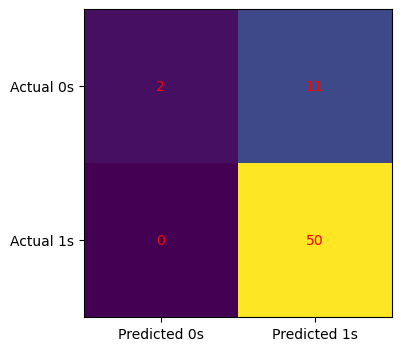

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.86308	0.82540	0.15385	1.00000	0.81967	0.90090	0.35511
              precision    recall  f1-score   support

           0       1.00      0.15      0.27        13
           1       0.82      1.00      0.90        50

    accuracy                           0.83        63
   macro avg       0.91      0.58      0.58        63
weighted avg       0.86      0.83      0.77        63

Actual iterations: 8903


In [118]:
# Create and train the Logistic Regression model
# Put optimal hyperparameters before proceeding to validation!

# Available solvers : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
solver = 'saga'
model_logreg = LogisticRegression(solver=solver, max_iter=10000, random_state=0).fit(Xt,yt)
# Choose the best hyperparameters and re-run before proceeding!

y_pred = model_logreg.predict(Xv) # Predicted binary labels for Test data
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(yv, y_pred)
metrics(Xv, yv, model_logreg, tn,fp,fn,tp)
accuracy = accuracy_score(yv, y_pred)
print(classification_report(yv, y_pred))
print("Actual iterations:", model_logreg.n_iter_[0])

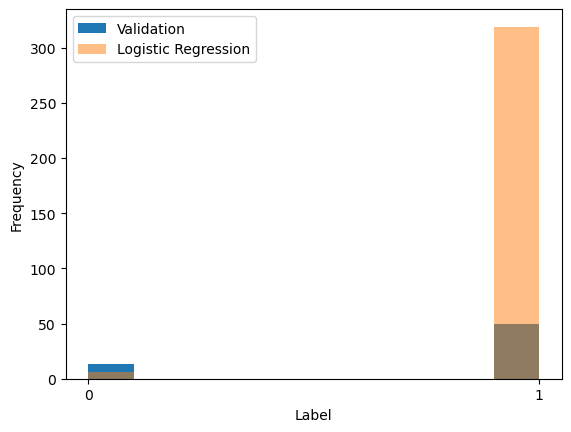

In [119]:
y_pred_val = model_logreg.predict(Xt)
plt.hist(y_val['unloaded'], label='Validation')
plt.hist(y_pred_val, label='Logistic Regression', alpha=0.5)
plt.xlabel('Label')
plt.xticks([0,1])
plt.ylabel('Frequency')
plt.legend();

<b>Logistic Regression results</b> for the binary label indicating unloaded status.

<b>Scaled training</b> dataset without `dt_1`.

| Solver | n_iter | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| lbfgs | 647 | 0.98847 | 0.95692 | <b>0.90000</b> | 0.97551 | <b>0.96761</b> | 0.97154 | <b>0.88307</b> |
| newton-cg | 64 | 0.98837 | 0.95692 | 0.90000 | 0.97551 | 0.96761 | 0.97154 | 0.88307 |
| <b>liblinear</b> | <b>19</b> | <b>0.99184</b> | <b>0.95692</b> | 0.88750 | 0.97959 | 0.96386 | <b>0.97166</b> | 0.88244 |
| sag | 7943 | 0.83872 | 0.78769 | 0.13750 | <b>1.00000</b> | 0.78025 | 0.87657 | 0.32754 |
| saga | 8773 | 0.75010 | 0.76308 | 0.03750 | 1.00000 | 0.76087 | 0.86420 | 0.16892 |

<b>Scaled training</b> dataset with <b>unscaled `dt_1`</b>.

| Solver | n_iter | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| lbfgs | 684 | 0.98847 | 0.95077 | 0.88750 | 0.97143 | 0.96356 | 0.96748 | 0.86634 |
| newton-cg | 64 | 0.98827 | 0.95077 | 0.88750 | 0.97143 | 0.96356 | 0.96748 | 0.86634 |
| <b>liblinear</b> | <b>20</b> | <b>0.99122</b> | <b>0.95692</b> | <b>0.88750</b> | 0.97959 | <b>0.96386</b> | <b>0.97166</b> | <b>0.88244</b> |
| sag | 8119 | 0.81352 | 0.79077 | 0.15000 | <b>1.00000</b> | 0.78275 | 0.87814 | 0.34265 |
| saga | 8903 | 0.73122 | 0.77231 | 0.07500 | 1.00000 | 0.76803 | 0.86879 | 0.24000 |

Addition of `dt_1` does not change the model quality for the training data (there is only a slight decrease in AUC), but requires more iterations, especially for 'sag' and 'saga' solvers, although model quality slightly increases for those solvers. The best solver is <b>'liblinear'</b> with 95.692% accuracy, TNR = 0.88750 and TPR = 0.97959.

<b>Scaled validation</b> dataset without `dt_1`.

| Solver | n_iter | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| lbfgs | 647 | 0.91231 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| <b>newton-cg</b> | 64 | 0.91231 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| liblinear | <b>19</b> | <b>0.95077</b> | <b>0.93651</b> | <b>0.69231</b> | <b>1.00000</b> | <b>0.92593</b> | <b>0.96154</b> | <b>0.80064</b> |
| sag | 7943 | 0.95077 | 0.82540 | 0.15385 | 1.00000 | 0.81967 | 0.90090 | 0.35511 |
| saga | 8773 | 0.93077 | 0.80952 | 0.07692 | 1.00000 | 0.80645 | 0.89286 | 0.24907 |

<b>Scaled validation</b> dataset with <b>unscaled `dt_1`</b>.

| Solver | n_iter | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| lbfgs | 684 | 0.91538 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| newton-cg | 64 | 0.91231 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| <b>liblinear</b> | <b>20</b> | <b>0.95231</b> | <b>0.93651</b> | <b>0.69231</b> | <b>1.00000</b> | <b>0.92593</b> | <b>0.96154</b> | <b>0.80064</b> |
| sag | 8119 | 0.90923 | 0.85714 | 0.30769 | 1.00000 | 0.84746 | 0.91743 | 0.51064 |
| saga | 8903 | 0.86308 | 0.82540 | 0.15385 | 1.00000 | 0.81967 | 0.90090 | 0.35511 |

The accuracy on validation set is 93.651%, which is a reasonably small decrease compared to the training set. The best solver is still <b>'liblinear'</b> with the same number of iterations. Addition of unscaled time interval `dt_1` between the earliest and next signals does not improve the logistic regression model. Let us try adding normalized `dt_1`.

In [120]:
# Normalization of `dt_1` in X_train
dt_1_train_unscaled = X_train['dt_1']
scaler_dt = MinMaxScaler() # Normalize data to range [0, 1]
X_train.loc[:, 'dt_1'] = np.ravel(scaler_dt.fit_transform(X_train['dt_1'].values.reshape(-1, 1)))
print(f"Scaling parameters: min = {scaler_dt.min_[0]}, scale = {scaler_dt.scale_[0]}")
X_train['dt_1'].describe()

Scaling parameters: min = 0.0, scale = 0.001861587263764576


count    325.000000
mean       0.130341
std        0.147333
min        0.000000
25%        0.032853
50%        0.074203
75%        0.181598
max        1.000000
Name: dt_1, dtype: float64

In [121]:
# Normalization of `dt_1` in X_val
dt_1_val_unscaled = X_val['dt_1']
X_val.loc[:, 'dt_1'] = np.ravel(scaler_dt.transform(X_val['dt_1'].values.reshape(-1, 1)))
X_val['dt_1'].describe()

count    63.000000
mean      0.104547
std       0.164717
min       0.000000
25%       0.026107
50%       0.045950
75%       0.114368
max       0.890016
Name: dt_1, dtype: float64

In [122]:
# Choose Test set: on Train or Validation data!
test_on_train = False # 'True' if testing the model on training data, 'False' if on validation data

if test_on_train:
    Xv = Xt; yv = yt
else:
    Xv = X_val; yv = y_val['unloaded']

[[TN, FP], [FN, TP]] =
 [[ 3 10]
 [ 0 50]]


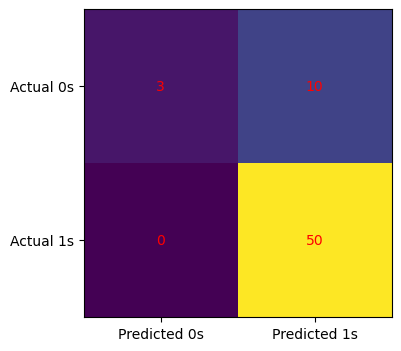

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.93385	0.84127	0.23077	1.00000	0.83333	0.90909	0.43853
              precision    recall  f1-score   support

           0       1.00      0.23      0.38        13
           1       0.83      1.00      0.91        50

    accuracy                           0.84        63
   macro avg       0.92      0.62      0.64        63
weighted avg       0.87      0.84      0.80        63

Actual iterations: 8903


In [123]:
# Create and train the Logistic Regression model
# Put optimal hyperparameters before proceeding to validation!

# Available solvers : {'lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'}
solver = 'saga'
model_logreg = LogisticRegression(solver=solver, max_iter=10000, random_state=0).fit(Xt,yt)
y_pred = model_logreg.predict(Xv) # Predicted binary labels for Test data
# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(yv, y_pred)
metrics(Xv, yv, model_logreg, tn,fp,fn,tp)
accuracy = accuracy_score(yv, y_pred)
print(classification_report(yv, y_pred))
print("Actual iterations:", model_logreg.n_iter_[0])

<b>Scaled validation</b> dataset with <b>scaled `dt_1`</b>.

| Solver | n_iter | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| lbfgs | 563 | 0.91385 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| newton-cg | 64 | 0.91385 | 0.90476 | 0.53846 | 1.00000 | 0.89286 | 0.94340 | 0.69338 |
| <b>liblinear</b> | <b>19</b> | <b>0.95077</b> | <b>0.93651</b> | <b>0.69231</b> | <b>1.00000</b> | <b>0.92593</b> | <b>0.96154</b> | <b>0.80064</b> |
| sag | 7942 | 0.95077 | 0.82540 | 0.15385 | 1.00000 | 0.81967 | 0.90090 | 0.35511 |
| saga | 8772 | 0.93077 | 0.80952 | 0.07692 | 1.00000 | 0.80645 | 0.89286 | 0.24907 |

Addition of scaled `dt_1` makes the logistic regression model slightly worse. Overall, this variable is not worth including. If to keep it, we have to unscale it.

In [124]:
# Unscale `dt_1` in training and validation sets!
X_train['dt_1'] = dt_1_train_unscaled
X_val['dt_1'] = dt_1_val_unscaled

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


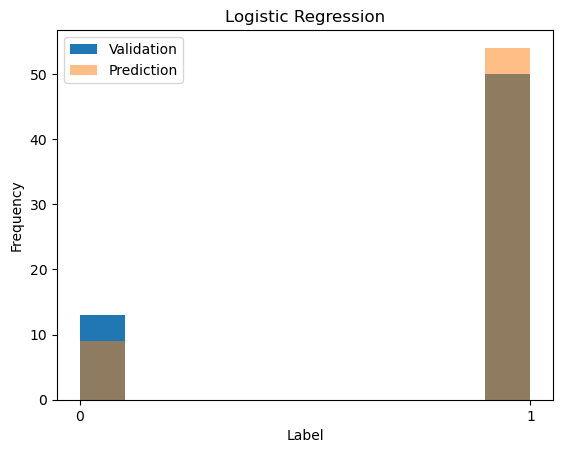

In [125]:
# Best Logistic Regression model!
model_logreg = LogisticRegression(solver='liblinear', max_iter=20, random_state=0).fit(Xt, yt)
y_pred_val = model_logreg.predict(Xv)
plt.title('Logistic Regression')
plt.hist(yv, label='Validation')
plt.hist(y_pred_val, label='Prediction', alpha=0.5)
plt.xlabel('Label')
plt.xticks([0,1])
plt.ylabel('Frequency')
plt.legend();

### Decision Tree for Binary Classification
Let us try to use only the proportions for decision making. We discard the mean and standard deviations, binary indicators of the earliest and latest bridge, and time intervals.

[[TN, FP], [FN, TP]] =
 [[12  1]
 [ 5 45]]


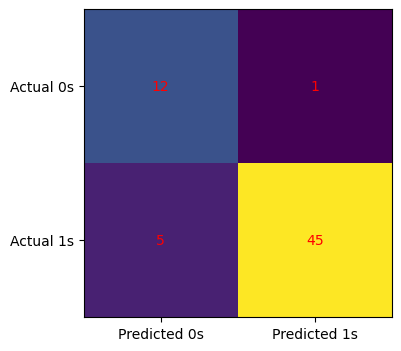

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.93308	0.90476	0.92308	0.90000	0.97826	0.93750	0.75040
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.98      0.90      0.94        50

    accuracy                           0.90        63
   macro avg       0.84      0.91      0.87        63
weighted avg       0.92      0.90      0.91        63



In [126]:
# Only proportions in the decision tree
proportion_cols = ['gateway1p','bridge_575345CE2154', 'bridge_D088ED75B4E3', 'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18', 'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73', 'bridge_93D44D27CAB1']
# Create Decision Tree classifer object
max_depth=3
model_decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=0)

# Train Decision Tree Classifer
model_decision_tree = model_decision_tree.fit(X_train[proportion_cols],y_train['unloaded'])

#Predict the response for validation dataset
y_pred_val = model_decision_tree.predict(X_val[proportion_cols])

# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y_val['unloaded'], y_pred_val)
metrics(X_val[proportion_cols], y_val['unloaded'], model_decision_tree, tn,fp,fn,tp)
accuracy = accuracy_score(y_val['unloaded'], y_pred_val)
print(classification_report(y_val['unloaded'], y_pred_val))

<b>Decision tree results</b> for the binary label indicating unloaded status, training used <b>only proportions</b>, <b>validation</b> dataset.

| max_depth | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.81462 | 0.84127 | 0.76923 | 0.86000 | 0.93478 | 0.89583 | 0.57367 |
| 2 | 0.91462 | 0.88889 | 0.76923 | <b>0.92000</b> | 0.93878 | 0.92929 | 0.67090 |
| <b>3</b> | <b>0.93308</b> | <b>0.90476</b> | <b>0.92308</b> | 0.90000 | <b>0.97826</b> | <b>0.93750</b> | <b>0.75040</b> |
| 4 | 0.93000 | 0.90476 | 0.92308 | 0.90000 | 0.97826 | 0.93750 | 0.75040 |
| 5 | 0.88538 | 0.88889 | 0.84615 | 0.90000 | 0.95745 | 0.92784 | 0.69371 |
| 6 | 0.88000 | 0.87302 | 0.84615 | 0.88000 | 0.95652 | 0.91667 | 0.66204 |
| 7 | 0.88154 | 0.90476 | 0.84615 | 0.92000 | 0.95833 | 0.93878 | 0.72796 |
| 8 | 0.88308 | 0.90476 | 0.84615 | 0.92000 | 0.95833 | 0.93878 | 0.72796 |
| 9 | 0.88308 | 0.90476 | 0.84615 | 0.92000 | 0.95833 | 0.93878 | 0.72796 |

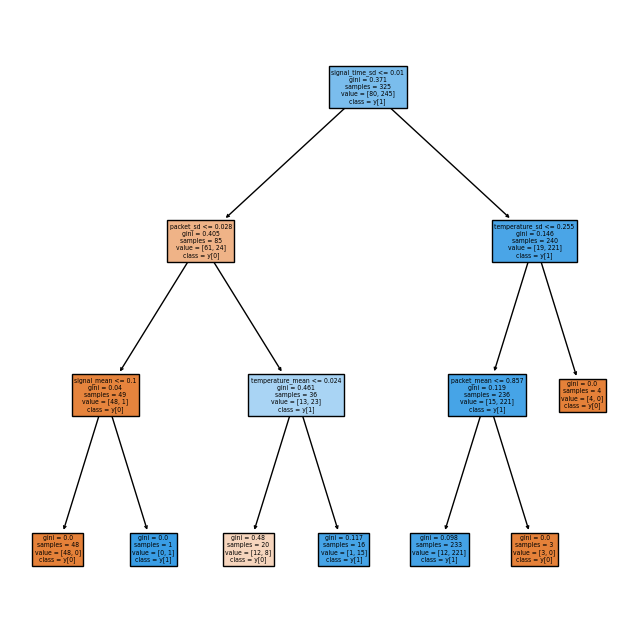

In [127]:
fig = plt.figure(figsize = (8, 8))
tree.plot_tree(model_decision_tree, feature_names=list(X_train.columns), class_names=True, filled=True, rounded=False);
plt.savefig("DecisionTree_proportions.max_depth_"+str(max_depth)+".pdf", dpi=600, facecolor='white')

With only proportion variables, decision tree reaches a complete classification after 8 decisions. Optimal max_depth = 3, with the accuracy of 90.476%, TNR = 0.92308, and TPR = 0.90000. We have a slightly smaller accuracy and TPR compared to the case of more variables studied below.

In [128]:
X_train.columns

Index(['gateway1p', 'signal_time_mean', 'signal_time_sd', 'packet_mean',
       'packet_sd', 'signal_mean', 'signal_sd', 'temperature_mean',
       'temperature_sd', 'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean',
       'oscillation_sd', 'bridge_575345CE2154', 'bridge_D088ED75B4E3',
       'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18',
       'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73',
       'bridge_93D44D27CAB1', 'earliest_575345CE2154', 'earliest_D088ED75B4E3',
       'earliest_F2862879ADE1', 'earliest_2B9CA06C53B2',
       'earliest_3D9B5E166F18', 'earliest_61DDE8F31239',
       'earliest_671E77344434', 'earliest_6EE5945E8B73',
       'earliest_93D44D27CAB1', 'latest_575345CE2154', 'latest_D088ED75B4E3',
       'latest_F2862879ADE1', 'latest_2B9CA06C53B2', 'latest_3D9B5E166F18',
       'latest_61DDE8F31239', 'latest_671E77344434', 'latest_6EE5945E8B73',
       'latest_93D44D27CAB1', 'dt_1'],
      dtype='object')

[[TN, FP], [FN, TP]] =
 [[11  2]
 [ 3 47]]


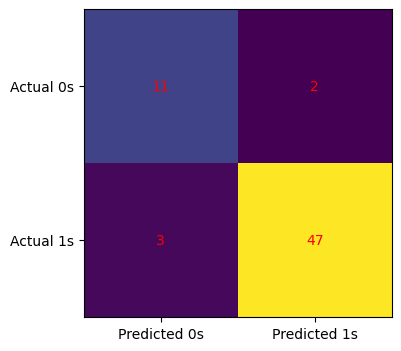

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.88692	0.92063	0.84615	0.94000	0.95918	0.94949	0.76525
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.96      0.94      0.95        50

    accuracy                           0.92        63
   macro avg       0.87      0.89      0.88        63
weighted avg       0.92      0.92      0.92        63



In [129]:
#drop_cols = ['signal_time_mean', 'signal_time_sd'] # Choose columns to drop!
drop_cols = []

# Create Decision Tree classifer object
max_depth=5
model_decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=46) #random_state=0 or 46
# random_state=0 leads to a lower quality at max_depth=4, so use random_state=46!

# Train Decision Tree Classifer
Xt = X_train.drop(columns=drop_cols)
Xv = X_val.drop(columns=drop_cols)
model_decision_tree = model_decision_tree.fit(Xt,y_train['unloaded'])

#Predict the response for validation dataset
y_pred_val = model_decision_tree.predict(Xv)

# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y_val['unloaded'], y_pred_val)
metrics(Xv, y_val['unloaded'], model_decision_tree, tn,fp,fn,tp)
accuracy = accuracy_score(y_val['unloaded'], y_pred_val)
print(classification_report(y_val['unloaded'], y_pred_val))

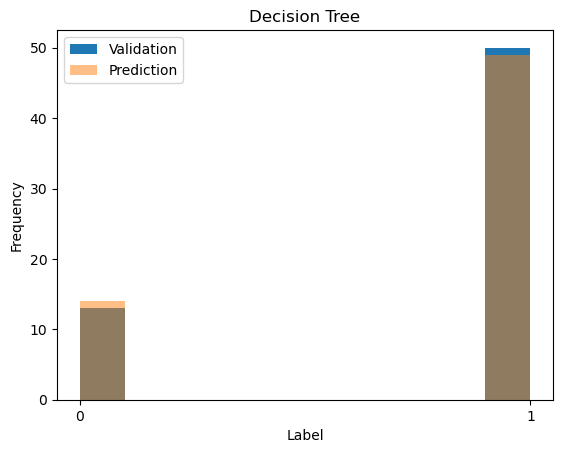

In [130]:
plt.title('Decision Tree')
plt.hist(y_val['unloaded'], label='Validation')
plt.hist(y_pred_val, label='Prediction', alpha=0.5)
plt.xlabel('Label')
plt.xticks([0,1])
plt.ylabel('Frequency')
plt.legend();

<b>Decision tree results</b> for the binary label indicating unloaded status, <b>scaled validation</b> dataset, <b>dropped 'signal_time_mean' and 'signal_time_sd'</b>.

| max_depth | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.81462 | 0.84127 | 0.76923 | 0.86000 | 0.93478 | 0.89583 | 0.57367 |
| 2 | 0.91462 | 0.88889 | 0.76923 | 0.92000 | 0.93878 | 0.92929 | 0.67090 |
| 3 | 0.93385 | 0.92063 | 0.84615 | <b>0.94000</b> | 0.95918 | <b>0.94949</b> | 0.76525 |
| 4 | 0.92769 | 0.92063 | 0.84615 | 0.94000 | 0.95918 | 0.94949 | 0.76525 |
| <b>5</b> | 0.92154 | <b>0.92063</b> | <b>0.92308</b> | 0.92000 | <b>0.97872</b> | 0.94845 | <b>0.78382</b> |
| 6 | <b>0.94154</b> | 0.92063 | 0.92308 | 0.92000 | 0.97872 | 0.94845 | 0.78382 |
| 7 | 0.93692 | 0.92063 | 0.92308 | 0.92000 | 0.97872 | 0.94845 | 0.78382 |
| 8 | 0.90769 | 0.90476 | 0.92308 | 0.90000 | 0.97826 | 0.93750 | 0.75040 |
| 9 | 0.91154 | 0.90476 | 0.92308 | 0.90000 | 0.97826 | 0.93750 | 0.75040 |
| 10 | 0.91154 | 0.90476 | 0.92308 | 0.90000 | 0.97826 | 0.93750 | 0.75040 |

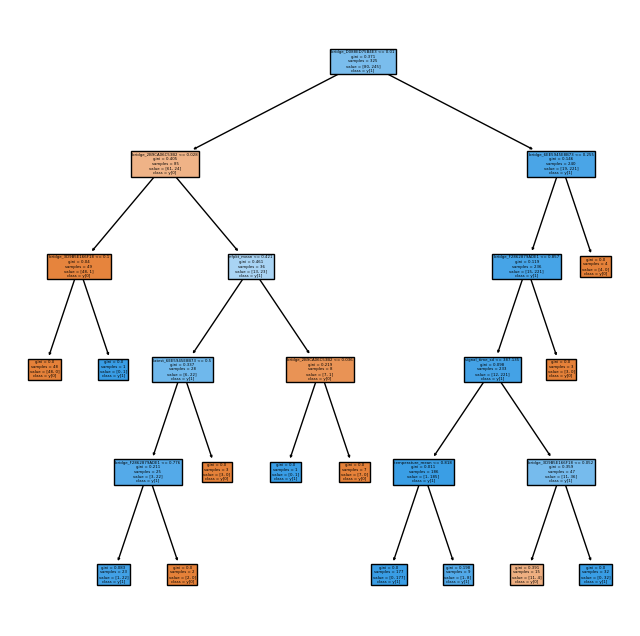

In [131]:
fig = plt.figure(figsize = (8, 8))
tree.plot_tree(model_decision_tree, feature_names=list(X_train.columns), class_names=True, filled=True, rounded=False);
plt.savefig("DecisionTree.max_depth_"+str(max_depth)+".pdf", dpi=600, facecolor='white')

In [132]:
# Text version of the decision tree
tree_text = tree.export_text(model_decision_tree, feature_names=list(Xt.columns))# by default, feature_0, etc.
print(tree_text)

|--- bridge_D088ED75B4E3 <= 0.01
|   |--- bridge_2B9CA06C53B2 <= 0.03
|   |   |--- bridge_3D9B5E166F18 <= 0.10
|   |   |   |--- class: 0
|   |   |--- bridge_3D9B5E166F18 >  0.10
|   |   |   |--- class: 1
|   |--- bridge_2B9CA06C53B2 >  0.03
|   |   |--- nfpkt_mean <= 0.42
|   |   |   |--- latest_6EE5945E8B73 <= 0.50
|   |   |   |   |--- bridge_F2862879ADE1 <= 0.78
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- bridge_F2862879ADE1 >  0.78
|   |   |   |   |   |--- class: 0
|   |   |   |--- latest_6EE5945E8B73 >  0.50
|   |   |   |   |--- class: 0
|   |   |--- nfpkt_mean >  0.42
|   |   |   |--- bridge_2B9CA06C53B2 <= 0.04
|   |   |   |   |--- class: 1
|   |   |   |--- bridge_2B9CA06C53B2 >  0.04
|   |   |   |   |--- class: 0
|--- bridge_D088ED75B4E3 >  0.01
|   |--- bridge_6EE5945E8B73 <= 0.26
|   |   |--- bridge_F2862879ADE1 <= 0.86
|   |   |   |--- signal_time_sd <= 387.13
|   |   |   |   |--- temperature_mean <= 0.82
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- tempe

In [133]:
# pickle the best binary classifier
with open(r"model_decision_tree.pkl", "wb") as output_file:
    pickle.dump(model_decision_tree, output_file)

Optimal tree depth is 5 with accuracy of 92.063% and almost equal TNR = 0.92308	and TPR = 0.92000. Matthew's correlation coefficient seems to be the best performance metric. Notice slight degredation of performance with increasing tree depth. All quality metrics stop changing starting at tree depth of 9, where a complete separation of labels is achieved.

### Support Vector Binary Classification

[[TN, FP], [FN, TP]] =
 [[12  1]
 [ 3 47]]


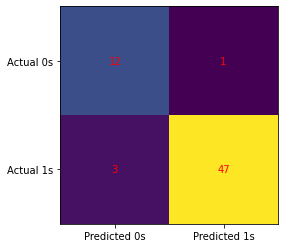

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.93154	0.93651	0.92308	0.94000	0.97917	0.95918	0.82005
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.98      0.94      0.96        50

    accuracy                           0.94        63
   macro avg       0.89      0.93      0.91        63
weighted avg       0.94      0.94      0.94        63



In [133]:
# instantiate SVM classifier with polynomial kernel
model_svc_poly = SVC(kernel='poly', degree = 3, C=1.0, gamma='auto') # C - regularization parameter
#gamma='scale' is poor
model_svc_poly.fit(X_train,y_train['unloaded']) # fit classifier to training set
y_pred_val = model_svc_poly.predict(X_val) # make predictions on validation set

# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y_val['unloaded'], y_pred_val)
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = roc_auc_score(y_val['unloaded'], y_pred_val),\
    accuracy_score(y_val['unloaded'], y_pred_val), tn/(tn + fp), tp/(tp + fn), tp/(tp+fp), 2*tp/(2*tp+fp+fn), (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print(classification_report(y_val['unloaded'], y_pred_val))

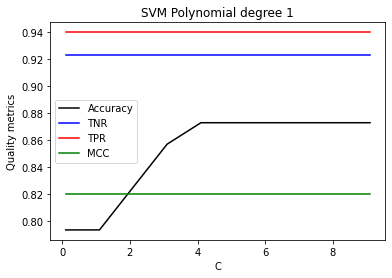

In [134]:
degree = 1
C_SVC_Poly = np.arange(0.1, 10+0.01, 1)
Metrics_SVC_Poly = []
for C in C_SVC_Poly:
    model_svc_poly=SVC(kernel='poly', degree=degree, C=C, gamma='auto') # instantiate SVM classifier with polynomial kernel
    model_svc_poly.fit(Xt,yt) # fit classifier to training set
    y_pred_val = model_svc_poly.predict(Xv) # make predictions on validation set
    # Evaluate the Model
    #tn,fp,fn,tp = confusion_matrix_plot(yv, y_pred_val)
    roc_auc, accuracy, tnr, tpr, precision, f1, MCC = roc_auc_score(y_val['unloaded'], y_pred_val),accuracy_score(y_val['unloaded'], y_pred_val), tn/(tn + fp), tp/(tp + fn), tp/(tp+fp), 2*tp/(2*tp+fp+fn), (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #Metrics_SVC_Poly.append([metrics(Xv, yv, model_svc_poly, tn,fp,fn,tp)])
    Metrics_SVC_Poly.append([roc_auc, accuracy, tnr, tpr, precision, f1, MCC])
# Performance of SVC polynomial
AUC_SVC_Poly = [i[0] for i in Metrics_SVC_Poly]
Accur_SVC_Poly = [i[1] for i in Metrics_SVC_Poly]
TNR_SVC_Poly = [i[2] for i in Metrics_SVC_Poly]
TPR_SVC_Poly = [i[3] for i in Metrics_SVC_Poly]
Precis_SVC_Poly = [i[4] for i in Metrics_SVC_Poly]
F1_SVC_Poly = [i[5] for i in Metrics_SVC_Poly]
MCC_SVC_Poly = [i[6] for i in Metrics_SVC_Poly]
Metrics_SVC_Poly_deg1 = Metrics_SVC_Poly.copy() # save

plt.title('SVM Polynomial degree '+str(degree))
plt.xlabel('C')
plt.ylabel('Quality metrics')
plt.plot(C_SVC_Poly, Accur_SVC_Poly, 'k', label='Accuracy')
plt.plot(C_SVC_Poly, TNR_SVC_Poly, 'b', label='TNR')
plt.plot(C_SVC_Poly, TPR_SVC_Poly, 'r', label='TPR')
plt.plot(C_SVC_Poly, MCC_SVC_Poly, 'g', label='MCC')
plt.legend()
plt.show()

In [135]:
Metrics_SVC_Poly_deg1 = Metrics_SVC_Poly.copy()

In [136]:
degree = 3
C_SVC_Poly = np.arange(0.1, 10+0.01, 1)
Metrics_SVC_Poly = []
for C in C_SVC_Poly:
    model_svc_poly=SVC(kernel='poly', degree=degree, C=C, gamma='auto') # instantiate SVM classifier with polynomial kernel
    model_svc_poly.fit(Xt,yt) # fit classifier to training set
    y_pred_val = model_svc_poly.predict(Xv) # make predictions on validation set
    # Evaluate the Model
    #tn,fp,fn,tp = confusion_matrix_plot(yv, y_pred_val)
    roc_auc, accuracy, tnr, tpr, precision, f1, MCC = roc_auc_score(y_val['unloaded'], y_pred_val),accuracy_score(y_val['unloaded'], y_pred_val), tn/(tn + fp), tp/(tp + fn), tp/(tp+fp), 2*tp/(2*tp+fp+fn), (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    #Metrics_SVC_Poly.append([metrics(Xv, yv, model_svc_poly, tn,fp,fn,tp)])
    Metrics_SVC_Poly.append([roc_auc, accuracy, tnr, tpr, precision, f1, MCC])
# Performance of SVC polynomial
AUC_SVC_Poly = [i[0] for i in Metrics_SVC_Poly]
Accur_SVC_Poly = [i[1] for i in Metrics_SVC_Poly]
TNR_SVC_Poly = [i[2] for i in Metrics_SVC_Poly]
TPR_SVC_Poly = [i[3] for i in Metrics_SVC_Poly]
Precis_SVC_Poly = [i[4] for i in Metrics_SVC_Poly]
F1_SVC_Poly = [i[5] for i in Metrics_SVC_Poly]
MCC_SVC_Poly = [i[6] for i in Metrics_SVC_Poly]
Metrics_SVC_Poly_deg3 = Metrics_SVC_Poly.copy()

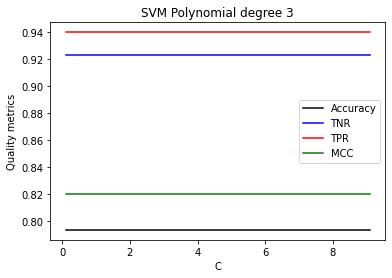

In [137]:
plt.title('SVM Polynomial degree '+str(degree))
plt.xlabel('C')
plt.ylabel('Quality metrics')
plt.plot(C_SVC_Poly, Accur_SVC_Poly, 'k', label='Accuracy')
plt.plot(C_SVC_Poly, TNR_SVC_Poly, 'b', label='TNR')
plt.plot(C_SVC_Poly, TPR_SVC_Poly, 'r', label='TPR')
plt.plot(C_SVC_Poly, MCC_SVC_Poly, 'g', label='MCC')
plt.legend()
plt.show()

SVM classifier model is not sensitive to regularization parameter `C` at degree of 3 and above. Use of default `gamma='scale'` yields too low TNR or TPR.

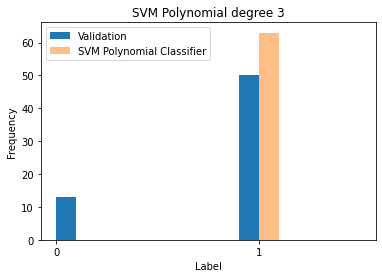

In [138]:
plt.title('SVM Polynomial degree '+str(degree))
plt.hist(y_val['unloaded'], label='Validation')
plt.hist(y_pred_val, label='SVM Polynomial Classifier', alpha=0.5)
plt.xticks([0,1])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.legend();

The best binary classification model is `model_svc_poly` with all variables included.

[[TN, FP], [FN, TP]] =
 [[12  1]
 [ 3 47]]


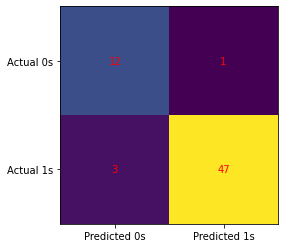

AUC	Accur	TNR	TPR	Precis	F1	MCC
0.93154	0.93651	0.92308	0.94000	0.97917	0.95918	0.82005
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.98      0.94      0.96        50

    accuracy                           0.94        63
   macro avg       0.89      0.93      0.91        63
weighted avg       0.94      0.94      0.94        63



In [139]:
# instantiate SVM classifier with polynomial kernel
model_svc_poly = SVC(kernel='poly', degree = 3, C=1.0, gamma='auto') # C - regularization parameter
#gamma='scale' is poor
model_svc_poly.fit(X_train,y_train['unloaded']) # fit classifier to training set
y_pred_val = model_svc_poly.predict(X_val) # make predictions on validation set

# Evaluate the Model
tn,fp,fn,tp = confusion_matrix_plot(y_val['unloaded'], y_pred_val)
roc_auc, accuracy, tnr, tpr, precision, f1, MCC = roc_auc_score(y_val['unloaded'], y_pred_val),\
    accuracy_score(y_val['unloaded'], y_pred_val), tn/(tn + fp), tp/(tp + fn), tp/(tp+fp), 2*tp/(2*tp+fp+fn), (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"AUC\tAccur\tTNR\tTPR\tPrecis\tF1\tMCC")
print("%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % (roc_auc, accuracy, tnr, tpr, precision, f1, MCC))
print(classification_report(y_val['unloaded'], y_pred_val))

| degree | AUC | Accur | TNR | TPR | Precis | F1 | MCC |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 2 | 0.82615 | 0.90476 | 0.69231 | 0.96000 | 0.92308 | 0.94118 | 0.69536 |
| 3 | <b>0.93154</b> | <b>0.93651</b> | <b>0.92308</b> | 0.94000 | <b>0.97917</b> | <b>0.95918</b> | <b>0.82005</b> |
| 4 | 0.83615 | 0.92063 | 0.69231 | <b>0.98000</b> | 0.92453 | 0.95146 | 0.74454 |
| 5 | 0.79769 | 0.90476 | 0.61538 | 0.98000 | 0.90741 | 0.94231	 | 0.68855 |

Starting at `degree = 4`, there is an overfitting.

In [140]:
# pickle the best binary classifier
with open(r"model_svc_poly.pkl", "wb") as output_file:
    pickle.dump(model_svc_poly, output_file)

### Prediction of `unload_timestamp`: OLS Linear Regression

To choose independent variables for the linear regression model, let us first calculate the Pearson's correlation coefficient <i>R</i> for the dependent variable `unload_time` with each independent variable.

Exclude not unloaded assets from the training dataset.

idx_unloaded_train = Index(['T2213', 'T2214', 'T2215', 'T2216', 'T2217', 'T2218', 'T2219', 'T2220',
       'T2221', 'T2222',
       ...
       'T2368_2', 'T2369_2', 'T2370_2', 'T2371_2', 'T2372_2', 'T2373_2',
       'T2374_2', 'T2375_2', 'T2376_2', 'T2377_2'],
      dtype='object', name='pixel_id', length=245)


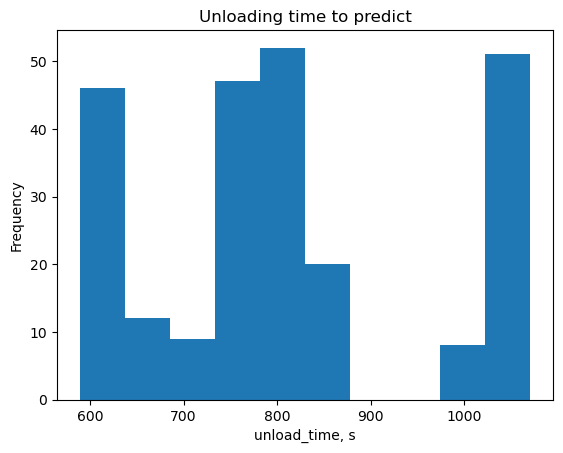

In [135]:
idx_unloaded_train = y_train.loc[y_train['unloaded'] == 1].index
print("idx_unloaded_train =", idx_unloaded_train)
X_train_unloaded = X_train.loc[idx_unloaded_train]
y_train_unloaded = y_train.loc[idx_unloaded_train]
plt.title('Unloading time to predict')
plt.hist(y_train_unloaded['unload_time'])
plt.xlabel('unload_time, s')
plt.ylabel('Frequency');

To choose independent variables for the linear regression model, let us first calculate the Pearson's correlation coefficient <i>R</i> for the dependent variable 'unload_time' with each independent variable in the training dataset.

In [136]:
print("Correlation R with 'unload_time':")
corrs = {} # dictionary of |correlation values| with y
for xv in X_train_unloaded.columns:
    R= np.corrcoef(X_train_unloaded[xv], y_train_unloaded['unload_time'])[0,1]
    #print(xv,R)
    if pd.isna(R): R = 0
    corrs[xv] = abs(R)
# Sort dictionary by values
corrs_keys = list(corrs.keys())
corrs_values = list(corrs.values())
sorted_value_index = np.flip(np.argsort(corrs_values)) # flip for descending order
corrs = {corrs_keys[i]: corrs_values[i] for i in sorted_value_index}
corrs

Correlation R with 'unload_time':


C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{'signal_time_mean': 0.7237808327694666,
 'signal_time_sd': 0.5799873160409421,
 'packet_sd': 0.4266446082257996,
 'temperature_mean': 0.4210329362921527,
 'nfpkt_mean': 0.39718936916656045,
 'bridge_61DDE8F31239': 0.34561790918879026,
 'bridge_2B9CA06C53B2': 0.3395784106457623,
 'signal_mean': 0.3319363669115478,
 'nfpkt_sd': 0.32767992435741317,
 'bridge_6EE5945E8B73': 0.2633584862069603,
 'bridge_3D9B5E166F18': 0.23411609303212824,
 'latest_F2862879ADE1': 0.20390211386001528,
 'bridge_F2862879ADE1': 0.19929229502343518,
 'oscillation_sd': 0.18033106084204523,
 'latest_93D44D27CAB1': 0.17805025550657697,
 'earliest_D088ED75B4E3': 0.1544621456583736,
 'bridge_93D44D27CAB1': 0.13230507883620352,
 'earliest_93D44D27CAB1': 0.12271606933395844,
 'earliest_575345CE2154': 0.12108245320937382,
 'earliest_3D9B5E166F18': 0.10899718684572396,
 'bridge_D088ED75B4E3': 0.10523466038306171,
 'latest_575345CE2154': 0.09836460170184386,
 'latest_61DDE8F31239': 0.09337408977223158,
 'latest_2B9CA06C53

All Pearson's correlation coefficients are small to medium.

In [145]:
# Table of OLS Linear Regression results for increasing number of x-variables
# Table header
print("| x | Adj. R^2 | AIC | BIC | const |", end='')
for xv in corrs.keys():
    print(f" {xv} |", end='')
print("\n|", end='')
for i in range(len(corrs.keys())+5):
    print(f" --- |", end='')
print('\n',end='')
# Add independent variables one by one
xvs = [] # List of independent variables to include in the Linear Regression model
for xv in corrs.keys():
    #print(xv)
    xvs.append(xv)
    #add constant to predictor variables
    x = sm.add_constant(X_train_unloaded[xvs])
    #fit linear regression model
    model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit()
    print(f"| {xv} | {model_linreg.rsquared_adj:5f} | {model_linreg.aic:.1f} | {model_linreg.bic:.1f} |", end='')
    for i in range(len(model_linreg.params)):
        print(f" {model_linreg.params[i]:5f} |", end='')
    print('\n',end='')

| x | Adj. R^2 | AIC | BIC | const | signal_time_mean | signal_time_sd | packet_sd | temperature_mean | nfpkt_mean | bridge_61DDE8F31239 | bridge_2B9CA06C53B2 | signal_mean | nfpkt_sd | bridge_6EE5945E8B73 | bridge_3D9B5E166F18 | latest_F2862879ADE1 | bridge_F2862879ADE1 | oscillation_sd | latest_93D44D27CAB1 | earliest_D088ED75B4E3 | bridge_93D44D27CAB1 | earliest_93D44D27CAB1 | earliest_575345CE2154 | earliest_3D9B5E166F18 | bridge_D088ED75B4E3 | latest_575345CE2154 | latest_61DDE8F31239 | latest_2B9CA06C53B2 | oscillation_mean | latest_671E77344434 | gateway1p | bridge_575345CE2154 | earliest_2B9CA06C53B2 | earliest_F2862879ADE1 | signal_sd | latest_D088ED75B4E3 | latest_6EE5945E8B73 | temperature_sd | packet_mean | latest_3D9B5E166F18 | earliest_61DDE8F31239 | dt_1 | bridge_671E77344434 | earliest_6EE5945E8B73 | earliest_671E77344434 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --

| latest_6EE5945E8B73 | 0.839323 | 2738.9 | 2857.9 | 211.859541 | 0.673102 | 0.167989 | 26.841880 | -95.276491 | 246.485156 | -102.110782 | 17.747422 | -52.672315 | -57.349401 | -268.219612 | -188.011706 | -33.969603 | 222.109783 | 21.423929 | 1.748901 | 62.229932 | 242.766104 | -8.287531 | 16.811512 | 74.938987 | 197.812375 | -25.311099 | 16.602576 | 36.476623 | -10.304106 | 39.111128 | -108.629867 | 27.522103 | 36.596627 | 11.570753 | 19.300323 | -3.865588 | 12.352916 |
| temperature_sd | 0.844589 | 2731.6 | 2854.1 | 213.527639 | 0.674992 | 0.191620 | 31.941447 | -62.921961 | 222.606790 | -95.975987 | -20.228961 | -46.047350 | -44.940013 | -268.671485 | -189.277184 | -32.829032 | 216.640473 | 22.730232 | 0.042886 | 57.506621 | 212.620400 | -14.001321 | 14.302423 | 73.774586 | 193.963076 | -27.407386 | 15.846787 | 39.185085 | 1.253509 | 42.419966 | -117.543178 | 11.527992 | 43.206171 | 10.801078 | 13.973221 | -1.577433 | 13.810455 | -76.099111 |
| packet_mean | 0.843931 | 2733.4 | 285

<b>Linear Regression results</b> for unloading time, <b>training</b> dataset. Each subsequent row has one additional independent variable included in the model. Variables are added in descending order of their <b>|R| with the dependent variable</b>. First column shows the added independent variable, next three columns show fit metrics, and the remaing columns show model coefficients.

| x | Adj. R^2 | AIC | BIC | const | signal_time_mean | signal_time_sd | packet_sd | temperature_mean | nfpkt_mean | bridge_61DDE8F31239 | bridge_2B9CA06C53B2 | signal_mean | nfpkt_sd | bridge_6EE5945E8B73 | bridge_3D9B5E166F18 | latest_F2862879ADE1 | bridge_F2862879ADE1 | oscillation_sd | latest_93D44D27CAB1 | earliest_D088ED75B4E3 | bridge_93D44D27CAB1 | earliest_93D44D27CAB1 | earliest_575345CE2154 | earliest_3D9B5E166F18 | bridge_D088ED75B4E3 | latest_575345CE2154 | latest_61DDE8F31239 | latest_2B9CA06C53B2 | oscillation_mean | latest_671E77344434 | gateway1p | bridge_575345CE2154 | earliest_2B9CA06C53B2 | earliest_F2862879ADE1 | signal_sd | latest_D088ED75B4E3 | latest_6EE5945E8B73 | temperature_sd | packet_mean | latest_3D9B5E166F18 | earliest_61DDE8F31239 | dt_1 | bridge_671E77344434 | earliest_6EE5945E8B73 | earliest_671E77344434 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| signal_time_mean | 0.521899 | 2976.6 | 2983.6 | 399.983159 | 0.582687 |
| signal_time_sd | 0.677074 | 2881.5 | 2892.0 | 352.377613 | 0.490971 | 0.453503 |
| packet_sd | 0.688319 | 2873.8 | 2887.8 | 330.015667 | 0.494509 | 0.356319 | 90.295159 |
| temperature_mean | 0.697188 | 2867.7 | 2885.2 | 387.449863 | 0.465994 | 0.339023 | 88.496943 | -84.378889 |
| nfpkt_mean | 0.761987 | 2809.7 | 2830.7 | 404.406508 | 0.455378 | 0.290877 | 30.830751 | -131.101570 | 237.278423 |
| bridge_61DDE8F31239 | 0.764158 | 2808.4 | 2832.9 | 421.054346 | 0.465094 | 0.253158 | 26.443095 | -123.556553 | 230.912825 | -200.367542 |
| bridge_2B9CA06C53B2 | 0.763234 | 2810.3 | 2838.4 | 424.206352 | 0.465655 | 0.247901 | 25.840782 | -124.284367 | 230.564431 | -186.671759 | -36.405302 |
| signal_mean | 0.773968 | 2799.9 | 2831.5 | 464.067468 | 0.488781 | 0.308029 | 48.238380 | -115.952263 | 201.348806 | -210.834530 | -112.723097 | -130.602620 |
| nfpkt_sd | 0.778692 | 2795.7 | 2830.7 | 446.828651 | 0.504170 | 0.285843 | 52.317785 | -111.989555 | 295.109888 | -169.488550 | -99.099919 | -107.988416 | -94.111737 |
| bridge_6EE5945E8B73 | 0.784145 | 2790.6 | 2829.1 | 462.838820 | 0.521457 | 0.245690 | 49.529773 | -107.361180 | 281.773522 | -216.363443 | -26.398313 | -106.834989 | -95.696601 | -271.369228 |
| bridge_3D9B5E166F18 | 0.824362 | 2741.0 | 2783.0 | 441.768157 | 0.617436 | 0.209564 | 48.225232 | -95.986447 | 268.300385 | -291.545252 | -81.768618 | -72.604151 | -96.561711 | -418.111418 | -355.038918 |
| latest_F2862879ADE1 | 0.828039 | 2736.8 | 2782.3 | 434.546270 | 0.634758 | 0.220612 | 45.296087 | -89.802591 | 260.007999 | -302.816975 | -97.207161 | -71.004698 | -86.246425 | -443.058887 | -382.347713 | -30.968856 |
| bridge_F2862879ADE1 | 0.833795 | 2729.4 | 2778.4 | 308.347053 | 0.684749 | 0.141335 | 39.493023 | -86.322498 | 236.871661 | -153.125497 | 52.296168 | -50.600192 | -79.110802 | -321.418134 | -280.845451 | -36.098408 | 148.589612 |
| oscillation_sd | 0.834446 | 2729.3 | 2781.9 | 306.079091 | 0.683053 | 0.135867 | 36.481151 | -81.970435 | 248.741473 | -155.026995 | 53.138285 | -46.982198 | -85.351733 | -326.060189 | -283.977095 | -35.209415 | 143.506241 | 29.271335 |
| latest_93D44D27CAB1 | 0.833848 | 2731.2 | 2787.2 | 308.928540 | 0.682295 | 0.135149 | 36.146254 | -82.033029 | 249.502580 | -160.573810 | 53.752844 | -46.595532 | -86.471577 | -325.270781 | -286.688255 | -35.257558 | 141.280831 | 28.793196 | -8.355482 |
| earliest_D088ED75B4E3 | 0.835257 | 2730.0 | 2789.5 | 309.685811 | 0.680779 | 0.126139 | 34.965733 | -83.883593 | 248.376067 | -138.771158 | 32.221949 | -46.313911 | -84.800887 | -320.449156 | -284.641692 | -36.843864 | 147.028845 | 28.540692 | -8.085477 | 77.190883 |
| bridge_93D44D27CAB1 | 0.837874 | 2727.0 | 2790.0 | 288.533469 | 0.675992 | 0.147399 | 33.132547 | -84.816883 | 248.336884 | -142.210539 | 56.889388 | -56.606064 | -78.530048 | -299.676189 | -265.515190 | -39.179205 | 167.957170 | 29.413624 | -20.832175 | 80.655030 | 225.254329 |
| earliest_93D44D27CAB1 | 0.837234 | 2728.9 | 2795.4 | 289.292755 | 0.675226 | 0.149296 | 32.795358 | -84.391914 | 249.262126 | -141.895425 | 59.869029 | -57.526307 | -79.481753 | -301.577790 | -265.339206 | -39.117125 | 166.859860 | 29.407591 | -21.848424 | 80.665262 | 233.812362 | -15.335389 |
| earliest_575345CE2154 | 0.836726 | 2730.6 | 2800.6 | 279.901971 | 0.678166 | 0.149269 | 33.557413 | -84.549070 | 245.696426 | -133.310834 | 67.863633 | -59.120221 | -76.446636 | -289.873790 | -258.341173 | -40.075446 | 176.227130 | 29.344793 | -20.983906 | 81.739162 | 238.926452 | -13.007294 | 7.337166 |
| earliest_3D9B5E166F18 | 0.836455 | 2731.9 | 2805.4 | 276.136817 | 0.677315 | 0.146941 | 32.708664 | -84.310193 | 246.724251 | -126.801269 | 72.492477 | -57.284573 | -75.594356 | -279.788928 | -257.169246 | -39.833788 | 180.547442 | 29.571199 | -20.898279 | 82.892828 | 239.069521 | -12.471527 | 7.771911 | 50.064360 |
| bridge_D088ED75B4E3 | 0.837867 | 2730.7 | 2807.7 | 226.554424 | 0.677226 | 0.135172 | 35.395261 | -82.740772 | 254.245556 | -80.432261 | 98.450377 | -43.083359 | -81.086874 | -273.035690 | -221.894019 | -39.135165 | 225.365443 | 31.362450 | -17.995371 | 71.463715 | 253.710040 | -19.978321 | 7.599312 | 46.816386 | 179.243381 |
| latest_575345CE2154 | 0.839730 | 2728.7 | 2809.3 | 264.404150 | 0.675626 | 0.155482 | 34.316266 | -87.046754 | 244.856739 | -126.440774 | 71.436041 | -45.762457 | -69.907531 | -316.677043 | -265.695260 | -43.569931 | 186.909786 | 27.051339 | -18.984869 | 69.197174 | 211.687521 | -15.023557 | 3.859347 | 72.022662 | 127.809577 | -32.435350 |
| latest_61DDE8F31239 | 0.839007 | 2730.7 | 2814.8 | 264.358926 | 0.675425 | 0.155721 | 34.372064 | -87.069420 | 244.913892 | -127.530484 | 71.212508 | -45.699167 | -69.975018 | -315.829063 | -265.480933 | -43.460685 | 186.832460 | 27.054694 | -18.878976 | 69.128304 | 211.792243 | -15.256587 | 3.780098 | 71.956636 | 128.205466 | -32.345169 | 0.882616 |
| latest_2B9CA06C53B2 | 0.839439 | 2731.0 | 2818.5 | 276.968922 | 0.676441 | 0.152666 | 32.148206 | -87.733103 | 243.525216 | -150.347186 | 12.220290 | -51.038713 | -68.108153 | -325.504532 | -264.474285 | -41.263907 | 177.814438 | 27.637366 | -15.219220 | 60.644881 | 212.318363 | -21.365326 | 3.343061 | 68.721412 | 114.305744 | -30.717983 | 5.238872 | 21.790136 |
| oscillation_mean | 0.838810 | 2732.8 | 2823.8 | 282.387150 | 0.675754 | 0.153229 | 32.703567 | -87.835330 | 244.841575 | -149.590762 | 13.300146 | -48.788156 | -68.489218 | -324.743161 | -264.564515 | -40.955630 | 178.100624 | 25.147442 | -15.611813 | 61.611060 | 210.703053 | -20.610007 | 3.315448 | 68.857026 | 117.333513 | -30.164622 | 5.188674 | 21.308801 | -11.421865 |
| latest_671E77344434 | 0.842366 | 2728.2 | 2822.7 | 255.547975 | 0.672151 | 0.171004 | 28.575549 | -90.892208 | 236.193116 | -161.241150 | 20.848342 | -48.277534 | -51.893480 | -287.953521 | -223.440396 | -34.750603 | 190.762198 | 20.128695 | -3.181201 | 53.388143 | 214.117262 | -16.887316 | 6.821676 | 64.462264 | 155.883850 | -23.080096 | 16.266818 | 31.763336 | -7.284994 | 34.557782 |
| gateway1p | 0.842421 | 2729.0 | 2827.0 | 260.136020 | 0.669181 | 0.174414 | 28.707294 | -91.254347 | 236.435140 | -167.469051 | 20.812517 | -49.488266 | -52.397845 | -293.360801 | -226.368503 | -35.112141 | 190.160883 | 19.833462 | -2.558730 | 52.127758 | 210.966288 | -16.712888 | 6.318162 | 64.042078 | 157.226465 | -23.931942 | 15.285855 | 31.358474 | -6.359235 | 37.089571 | -107.716781 |
| bridge_575345CE2154 | 0.841704 | 2731.0 | 2832.5 | 247.082433 | 0.669856 | 0.173480 | 29.225050 | -91.772176 | 235.276074 | -153.296138 | 33.691160 | -50.628009 | -51.260372 | -280.333689 | -212.985540 | -35.147583 | 203.592520 | 19.840946 | -2.452548 | 52.448872 | 224.790681 | -15.947692 | 6.033726 | 63.816985 | 171.511518 | -24.517664 | 15.026695 | 31.428068 | -6.327484 | 37.733916 | -108.873039 | 17.768557 |
| earliest_2B9CA06C53B2 | 0.841267 | 2732.5 | 2837.6 | 243.355477 | 0.671954 | 0.169465 | 29.365461 | -91.058349 | 235.340387 | -136.774834 | 9.211367 | -52.682275 | -51.184703 | -265.224572 | -207.324461 | -35.843503 | 209.113153 | 20.468953 | -1.772238 | 54.040950 | 225.126551 | -14.559178 | 6.182086 | 66.661246 | 174.748600 | -27.094306 | 15.088286 | 32.562945 | -7.389552 | 37.856031 | -109.108516 | 25.069136 | 25.353685 |
| earliest_F2862879ADE1 | 0.840879 | 2734.0 | 2842.5 | 224.274683 | 0.672187 | 0.170801 | 28.970824 | -91.888644 | 241.587387 | -118.881008 | 16.365480 | -51.763443 | -53.608908 | -248.994737 | -200.908929 | -35.381302 | 212.342927 | 20.908738 | -0.289507 | 64.582998 | 227.996815 | -4.922045 | 17.864678 | 78.610768 | 181.113768 | -26.424550 | 14.972354 | 33.304516 | -6.034121 | 37.578004 | -109.119363 | 24.998286 | 37.216602 | 12.324024 |
| signal_sd | 0.840484 | 2735.4 | 2847.5 | 219.296112 | 0.673807 | 0.168274 | 25.876053 | -95.140735 | 244.862664 | -123.276676 | 16.012460 | -50.957516 | -56.899721 | -253.372285 | -201.030803 | -34.967649 | 214.227399 | 20.556075 | 0.778429 | 62.029855 | 216.783099 | -5.669763 | 17.680384 | 77.780588 | 181.431440 | -26.489655 | 16.378400 | 34.961525 | -8.224508 | 37.839978 | -105.679808 | 17.374258 | 36.682085 | 11.446847 | 19.870706 |
| latest_D088ED75B4E3 | 0.839828 | 2737.3 | 2852.8 | 218.306653 | 0.675072 | 0.167633 | 25.538586 | -95.038953 | 246.800659 | -118.881579 | 17.586484 | -50.120840 | -58.948108 | -256.804250 | -203.927301 | -36.110994 | 217.085858 | 20.433072 | -1.141011 | 62.029804 | 224.044777 | -7.254367 | 17.401990 | 77.294574 | 194.767697 | -27.154382 | 14.844974 | 33.256865 | -10.077356 | 36.393515 | -106.854857 | 18.491087 | 36.564909 | 11.443892 | 19.760758 | -6.557764 |
| latest_6EE5945E8B73 | 0.839323 | 2738.9 | 2857.9 | 211.859541 | 0.673102 | 0.167989 | 26.841880 | -95.276491 | 246.485156 | -102.110782 | 17.747422 | -52.672315 | -57.349401 | -268.219612 | -188.011706 | -33.969603 | 222.109783 | 21.423929 | 1.748901 | 62.229932 | 242.766104 | -8.287531 | 16.811512 | 74.938987 | 197.812375 | -25.311099 | 16.602576 | 36.476623 | -10.304106 | 39.111128 | -108.629867 | 27.522103 | 36.596627 | 11.570753 | 19.300323 | -3.865588 | 12.352916 |
| temperature_sd | 0.844589 | 2731.6 | 2854.1 | 213.527639 | 0.674992 | 0.191620 | 31.941447 | -62.921961 | 222.606790 | -95.975987 | -20.228961 | -46.047350 | -44.940013 | -268.671485 | -189.277184 | -32.829032 | 216.640473 | 22.730232 | 0.042886 | 57.506621 | 212.620400 | -14.001321 | 14.302423 | 73.774586 | 193.963076 | -27.407386 | 15.846787 | 39.185085 | 1.253509 | 42.419966 | -117.543178 | 11.527992 | 43.206171 | 10.801078 | 13.973221 | -1.577433 | 13.810455 | -76.099111 |
| packet_mean | 0.843931 | 2733.4 | 2859.5 | 215.352969 | 0.674921 | 0.191043 | 33.442078 | -62.694606 | 220.925299 | -94.694290 | -18.999017 | -48.079321 | -44.459430 | -264.387667 | -186.929034 | -32.797982 | 219.336313 | 22.638048 | -0.584713 | 57.598981 | 213.355874 | -12.546387 | 13.929940 | 74.588351 | 194.964578 | -27.350038 | 15.491538 | 39.154053 | 1.903559 | 42.411492 | -121.483533 | 13.967638 | 43.515292 | 10.775129 | 13.924007 | -1.410543 | 13.466104 | -75.966632 | -7.406657 |
| latest_3D9B5E166F18 | 0.843931 | 2733.4 | 2859.5 | 198.655663 | 0.674921 | 0.191043 | 33.442078 | -62.694606 | 220.925299 | -94.694290 | -18.999017 | -48.079321 | -44.459430 | -264.387667 | -186.929034 | -16.100676 | 219.336313 | 22.638048 | 16.112593 | 57.598981 | 213.355874 | -12.546387 | 13.929940 | 74.588351 | 194.964578 | -10.652732 | 32.188844 | 55.851358 | 1.903559 | 59.108797 | -121.483533 | 13.967638 | 43.515292 | 10.775129 | 13.924007 | 15.286763 | 30.163410 | -75.966632 | -7.406657 | 16.697306 |
| earliest_61DDE8F31239 | 0.843272 | 2735.3 | 2864.8 | 202.604946 | 0.675486 | 0.189722 | 32.357171 | -62.007890 | 219.341400 | -94.040348 | -21.054445 | -46.853684 | -43.905716 | -268.604637 | -186.638405 | -15.482105 | 220.739479 | 23.026144 | 15.912494 | 51.628828 | 211.800736 | -18.019295 | 7.967449 | 68.167866 | 192.991655 | -10.008191 | 32.412600 | 56.375118 | 2.963854 | 59.581809 | -120.640931 | 13.944531 | 37.146867 | 4.656140 | 14.673472 | 16.298051 | 30.424096 | -76.704832 | -6.495862 | 17.091073 | -11.778222 |
| dt_1 | <b>0.845149</b> | 2733.2 | 2866.2 | 199.207181 | 0.679329 | 0.196667 | 34.378333 | -57.554230 | 199.698921 | -100.996412 | 18.712587 | -46.760526 | -34.463063 | -264.278656 | -189.361841 | -16.600948 | 226.031639 | 22.623826 | 11.135466 | 54.586097 | 211.593243 | -18.818512 | 5.831732 | 83.946416 | 171.703393 | -14.169829 | 31.172770 | 54.376026 | 5.425271 | 59.582784 | -136.311244 | 28.530827 | 36.197766 | 6.172796 | 11.101824 | 20.526938 | 34.321711 | -74.236815 | -8.244699 | 18.862263 | -13.704145 | -55.341390 |
| bridge_671E77344434 | 0.845149 | 2733.2 | 2866.2 | 190.364235 | 0.679329 | 0.196667 | 34.378333 | -57.554230 | 199.698921 | -91.170917 | 28.538082 | -46.760526 | -34.463063 | -254.453161 | -179.536346 | -17.583498 | 235.857134 | 22.623826 | 10.152917 | 54.586097 | 221.418738 | -18.818512 | 5.831732 | 83.946416 | 181.528888 | -15.152379 | 30.190221 | 53.393476 | 5.425271 | 58.600234 | -136.311244 | 38.356322 | 36.197766 | 6.172796 | 11.101824 | 19.544389 | 33.339162 | -74.236815 | -8.244699 | 17.879713 | -13.704145 | -55.341390 | 9.825495 |
| earliest_6EE5945E8B73 | 0.845149 | 2733.2 | 2866.2 | 187.009918 | 0.679329 | 0.196667 | 34.378333 | -57.554230 | 199.698921 | -91.543619 | 28.165380 | -46.760526 | -34.463063 | -254.825863 | -179.909048 | -17.956200 | 235.484432 | 22.623826 | 9.780215 | 58.685818 | 221.046036 | -14.718791 | 9.931453 | 88.046137 | 181.156186 | -15.525081 | 29.817519 | 53.020774 | 5.425271 | 58.227532 | -136.311244 | 37.983620 | 40.297488 | 10.272517 | 11.101824 | 19.171687 | 32.966460 | -74.236815 | -8.244699 | 17.507011 | -9.604424 | -55.341390 | 9.452793 | 4.099721 |
| earliest_671E77344434 | 0.845149 | 2733.2 | 2866.2 | 187.009918 | 0.679329 | 0.196667 | 34.378333 | -57.554230 | 199.698921 | -91.543619 | 28.165380 | -46.760526 | -34.463063 | -254.825863 | -179.909048 | -17.956200 | 235.484432 | 22.623826 | 9.780215 | 58.685818 | 221.046036 | -14.718791 | 9.931453 | 88.046137 | 181.156186 | -15.525081 | 29.817519 | 53.020774 | 5.425271 | 58.227532 | -136.311244 | 37.983620 | 40.297488 | 10.272517 | 11.101824 | 19.171687 | 32.966460 | -74.236815 | -8.244699 | 17.507011 | -9.604424 | -55.341390 | 9.452793 | 4.099721 | 0.000000 |



The best linear regression model (with highest adjusted $R^2 = 0.845149$) has 38 independent variables.

In [137]:
# Linear Regression model with optimal number of x-variables
xvs_opt = list(corrs.keys())[:38] # set optimal number of variables!
x = sm.add_constant(X_train_unloaded[xvs_opt]) #add constant to predictor variables
model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit() #fit linear regression model
print(model_linreg.summary()) #view model summary

                            OLS Regression Results                            
Dep. Variable:            unload_time   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     36.99
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           2.71e-72
Time:                        21:46:11   Log-Likelihood:                -1328.6
No. Observations:                 245   AIC:                             2733.
Df Residuals:                     207   BIC:                             2866.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   199.20

P-values > 0.05 show variables which likely do not contribute to explaining the unloading time, and thus could be removed from the model.

#### Test 'unload_timestamp' prediction on Training data

In [138]:
unload_time_pred_train = model_linreg.predict(sm.add_constant(X_train_unloaded[xvs_opt])) # Predict 'unload_time' for training dataset
print("Training MSE =", mean_squared_error(y_train_unloaded['unload_time'], unload_time_pred_train)) # Quality of linear fit, MSE training

Training MSE = 3003.887429997294


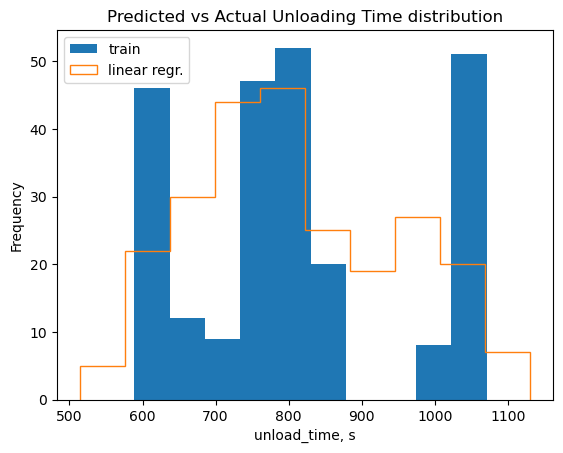

In [139]:
unload_time_pred_train = model_linreg.predict(sm.add_constant(X_train_unloaded[xvs_opt])) # Predict 'unload_time' for training dataset

plt.title('Predicted vs Actual Unloading Time distribution')
plt.hist(y_train_unloaded['unload_time'], label='train')
plt.hist(unload_time_pred_train, label='linear regr.', histtype='step')
plt.xlabel('unload_time, s')
plt.ylabel('Frequency')
plt.legend()
plt.show()

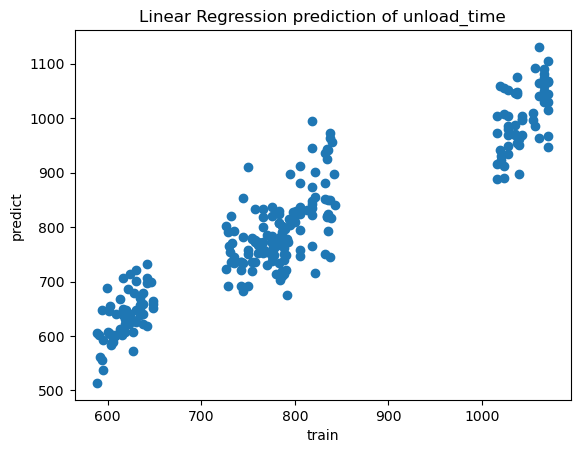

In [140]:
plt.title('Linear Regression prediction of unload_time')
plt.plot(y_train_unloaded['unload_time'], unload_time_pred_train, 'o')
plt.xlabel('train')
plt.ylabel('predict')
plt.show()

#### Test 'unload_timestamp' prediction on Validation data

In [141]:
idx_unloaded_val = y_val.loc[y_val['unloaded'] == 1].index
print(f"{len(idx_unloaded_val)} assets: {list(idx_unloaded_val)}")

50 assets: ['T2213', 'T2214', 'T2215', 'T2218', 'T2219', 'T2220', 'T2222', 'T2224', 'T2225', 'T2226', 'T2227', 'T2233', 'T2234', 'T2239', 'T2240', 'T2242', 'T2243', 'T2244', 'T2249', 'T2253', 'T2254', 'T2256', 'T2259', 'T2261', 'T2264', 'T2265', 'T2268', 'T2270', 'T2272', 'T2318', 'T2322', 'T2323', 'T2327', 'T2331', 'T2332', 'T2341', 'T2346', 'T2348', 'T2352', 'T2356', 'T2362', 'T2363', 'T2364', 'T2365', 'T2366', 'T2367', 'T2371', 'T2373', 'T2374', 'T2376']


In [142]:
X_val_unloaded = X_val.loc[idx_unloaded_val]
y_val_unloaded = y_val.loc[idx_unloaded_val]
X_val_unloaded

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,622.683118,230.257258,0.409392,0.915449,0.510229,0.310812,0.562388,0.528197,0.069889,...,0,0,0,0,0,0,0,1,0,0.161573
T2214,0.000000,790.214875,9.137127,0.333138,0.069401,0.443817,0.478738,0.312440,0.382671,0.000000,...,0,0,0,0,0,0,1,0,0,0.023007
T2215,0.000000,650.116533,185.958029,0.451916,0.974542,0.596947,0.470219,0.491206,0.422509,0.047525,...,0,0,0,0,0,1,0,0,0,0.411411
T2218,0.000000,500.889238,268.487207,0.646418,0.642489,0.635507,0.285237,0.700748,0.113219,0.192362,...,0,0,0,0,0,0,1,0,0,0.058294
T2219,0.040000,584.646480,257.445236,0.411702,0.355309,0.718205,0.398170,0.552811,0.220354,0.076040,...,0,0,0,0,0,0,0,1,0,0.154314
T2220,0.000000,391.855381,298.515942,0.657579,0.547975,0.635507,0.358728,0.674555,0.247777,0.158416,...,0,0,0,0,0,0,1,0,0,0.056043
T2222,0.000000,631.455667,248.116361,0.813768,0.661546,0.583104,0.845061,0.271186,0.000000,0.052805,...,0,0,0,0,0,0,1,0,0,0.890016
T2224,0.000000,592.624071,272.408483,0.384232,0.926435,0.593980,0.722708,0.467632,0.487405,0.033946,...,0,0,0,0,0,0,1,0,0,0.030908
T2225,0.000000,589.891526,242.975619,0.334389,0.538190,0.707320,0.340618,0.554895,0.439152,0.087546,...,0,0,0,0,0,0,1,0,0,0.191179


In [143]:
y_val_unloaded['unload_time'].describe()

count     50.000000
mean     737.907000
std       88.171236
min      598.327000
25%      635.827000
50%      788.327000
75%      811.327000
max      826.327000
Name: unload_time, dtype: float64

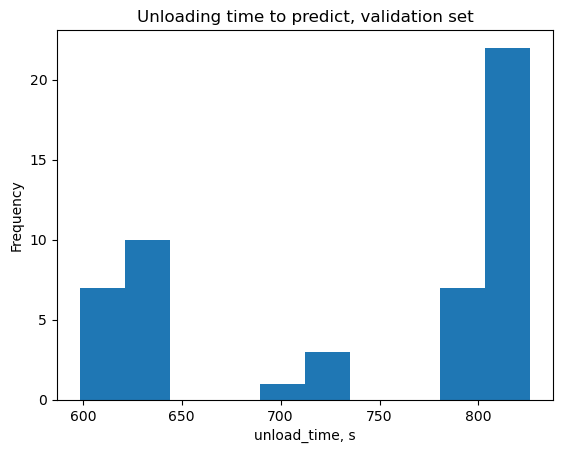

In [144]:
plt.title('Unloading time to predict, validation set')
plt.hist(y_val_unloaded['unload_time'], label='validation')
plt.xlabel('unload_time, s')
plt.ylabel('Frequency');

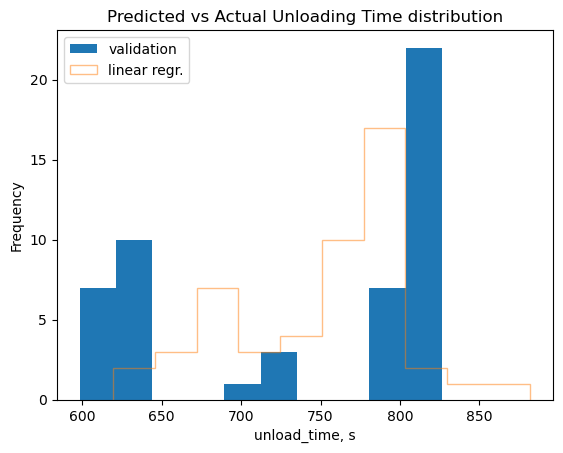

In [145]:
unload_time_pred_val = model_linreg.predict(sm.add_constant(X_val_unloaded[xvs_opt])) # Predict 'unload_time' for training dataset

plt.title('Predicted vs Actual Unloading Time distribution')
plt.hist(y_val_unloaded['unload_time'], label='validation')
plt.hist(unload_time_pred_val, label='linear regr.', histtype='step', alpha=0.5)
plt.xlabel('unload_time, s')
plt.ylabel('Frequency')
plt.legend()
plt.show()

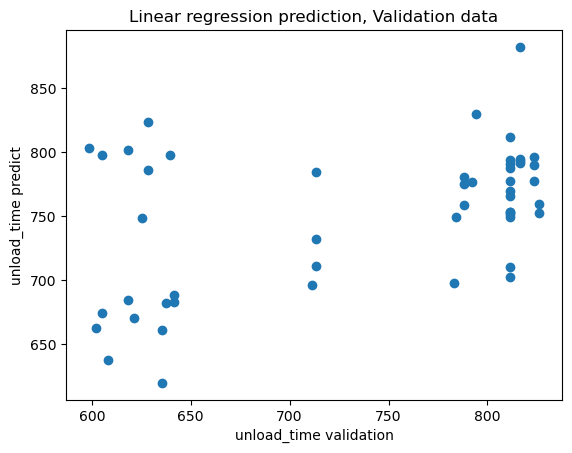

In [146]:
plt.title('Linear regression prediction, Validation data')
plt.plot(y_val_unloaded['unload_time'], unload_time_pred_val, 'o')
plt.xlabel('unload_time validation')
plt.ylabel('unload_time predict')
plt.show()

In [147]:
unload_time_pred_val - y_val['unload_time'] # Visual inspection of model errors

pixel_id
T2213    -29.558286
T2214     -7.739305
T2215    -13.530332
T2218     -0.101494
T2219    -58.032614
            ...    
T2367     41.285689
T2371     44.338676
T2373    158.410872
T2374     25.474849
T2376    -15.841423
Length: 63, dtype: float64

In [148]:
print("Validation MSE =", mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)) # Quality of linear fit, MSE validation, concise linear regression model

Validation MSE = 6352.449876895394


MSE for validation data is larger by the factor of ~2 compared to the training data.

#### Improvement of Linear Regression: Correlation with Model Error
Let us make the linear regression model more concise by modifying the way in which new independent variables are added. The first variable is added as before,- based on highest |R| with the dependent variable. Each subsequent independent variable is selected based on a highest |R| with the current model error. Hopefully, this will lead to a model of comparable quality on the training set and a higher quality on validation sets, while having less variables included.

In [149]:
# First x-variable with highest |R| with model error
xvs = [list(corrs.keys())[0]] # list of variables
print("First independent variable:", xvs)
xvs_rest = list(corrs.keys())[1:] # variables not yet in the model
#print("Remaining independent variables:", xvs_rest)
x = sm.add_constant(X_train_unloaded[xvs]) #add constant to predictor variables
model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit() #fit linear regression model
#print(model_linreg.params) #view model summary
corrs_err = {xvs[0]:list(corrs.values())[0]}
print("corrs_err =", corrs_err)

for i in range(len(xvs_rest)-1):
    # Next independent variable with highest |R| with model error
    model_linreg_err = model_linreg.predict(x) - y_train_unloaded['unload_time']
    Rabs_max = 0
    for xv in xvs_rest:
        R= np.corrcoef(X_train_unloaded[xv], model_linreg_err)[0,1]
        if pd.isna(R): R = 0
        if abs(R) > Rabs_max:
            Rabs_max = abs(R)
            xv_opt = xv
    if(len(xvs_rest)>0):
        xvs.append(xv_opt)
        print("Next independent variable:", xv_opt)
        print("|R| =", Rabs_max)
        corrs_err[xv_opt] = Rabs_max
        print("corrs_err =", corrs_err)
        
        xvs_rest.remove(xv_opt)
        print("Remaining independent variables:", xvs_rest)
        x = sm.add_constant(X_train_unloaded[xvs])
        #fit linear regression model
        model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit()
        
        print(model_linreg.params)
        print(model_linreg.summary()) #view model summary

First independent variable: ['signal_time_mean']
corrs_err = {'signal_time_mean': 0.7237808327694666}
Next independent variable: bridge_F2862879ADE1
|R| = 0.6685622575553402
corrs_err = {'signal_time_mean': 0.7237808327694666, 'bridge_F2862879ADE1': 0.6685622575553402}
Remaining independent variables: ['signal_time_sd', 'packet_sd', 'temperature_mean', 'nfpkt_mean', 'bridge_61DDE8F31239', 'bridge_2B9CA06C53B2', 'signal_mean', 'nfpkt_sd', 'bridge_6EE5945E8B73', 'bridge_3D9B5E166F18', 'latest_F2862879ADE1', 'oscillation_sd', 'latest_93D44D27CAB1', 'earliest_D088ED75B4E3', 'bridge_93D44D27CAB1', 'earliest_93D44D27CAB1', 'earliest_575345CE2154', 'earliest_3D9B5E166F18', 'bridge_D088ED75B4E3', 'latest_575345CE2154', 'latest_61DDE8F31239', 'latest_2B9CA06C53B2', 'oscillation_mean', 'latest_671E77344434', 'gateway1p', 'bridge_575345CE2154', 'earliest_2B9CA06C53B2', 'earliest_F2862879ADE1', 'signal_sd', 'latest_D088ED75B4E3', 'latest_6EE5945E8B73', 'temperature_sd', 'packet_mean', 'latest_3D9B

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\

const                  132.450738
signal_time_mean         0.714557
bridge_F2862879ADE1    379.223022
nfpkt_mean             174.786200
temperature_sd         -74.375522
latest_671E77344434     44.591035
latest_2B9CA06C53B2     42.853308
temperature_mean       -73.594725
bridge_D088ED75B4E3    264.782945
latest_F2862879ADE1    -26.782480
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            unload_time   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     135.1
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           1.12e-87
Time:                        21:47:27   Log-Likelihood:                -1354.2
No. Observations:                 245   AIC:                             2728.
Df Residuals:                     235   BIC:                             2763.
Df Model:    

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\

const                   14.941004
signal_time_mean         0.676674
bridge_F2862879ADE1    428.149594
nfpkt_mean             176.547242
temperature_sd         -76.148127
latest_671E77344434     43.374699
latest_2B9CA06C53B2     36.415270
temperature_mean       -62.017408
bridge_D088ED75B4E3    380.588468
latest_F2862879ADE1    -36.841496
bridge_93D44D27CAB1    367.894209
bridge_575345CE2154    208.450526
signal_time_sd           0.217732
latest_61DDE8F31239     20.023723
bridge_671E77344434    244.982902
dt_1                   -48.537584
latest_575345CE2154    -27.697026
bridge_2B9CA06C53B2    261.153111
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            unload_time   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     82.12
Date:                Sat, 10 Jun 2023   Prob (F-statistic

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\

Next independent variable: earliest_2B9CA06C53B2
|R| = 0.049790641380763966
corrs_err = {'signal_time_mean': 0.7237808327694666, 'bridge_F2862879ADE1': 0.6685622575553402, 'nfpkt_mean': 0.2872180769114947, 'temperature_sd': 0.260955090485833, 'latest_671E77344434': 0.1857429675142441, 'latest_2B9CA06C53B2': 0.1985078675151606, 'temperature_mean': 0.16617984482775627, 'bridge_D088ED75B4E3': 0.13617205438992477, 'latest_F2862879ADE1': 0.127524074651046, 'bridge_93D44D27CAB1': 0.11878488361741844, 'bridge_575345CE2154': 0.12422207044820817, 'signal_time_sd': 0.11584277138013654, 'latest_61DDE8F31239': 0.12158637996888516, 'bridge_671E77344434': 0.09389706474787708, 'dt_1': 0.08439514934057954, 'latest_575345CE2154': 0.07991163160845237, 'bridge_2B9CA06C53B2': 0.08159092517612919, 'earliest_3D9B5E166F18': 0.09261223875042746, 'gateway1p': 0.0797878750979237, 'earliest_D088ED75B4E3': 0.06942031768117542, 'earliest_61DDE8F31239': 0.061921706400869914, 'oscillation_sd': 0.059657186629484535, 

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\

Next independent variable: latest_93D44D27CAB1
|R| = 0.021766611880556622
corrs_err = {'signal_time_mean': 0.7237808327694666, 'bridge_F2862879ADE1': 0.6685622575553402, 'nfpkt_mean': 0.2872180769114947, 'temperature_sd': 0.260955090485833, 'latest_671E77344434': 0.1857429675142441, 'latest_2B9CA06C53B2': 0.1985078675151606, 'temperature_mean': 0.16617984482775627, 'bridge_D088ED75B4E3': 0.13617205438992477, 'latest_F2862879ADE1': 0.127524074651046, 'bridge_93D44D27CAB1': 0.11878488361741844, 'bridge_575345CE2154': 0.12422207044820817, 'signal_time_sd': 0.11584277138013654, 'latest_61DDE8F31239': 0.12158637996888516, 'bridge_671E77344434': 0.09389706474787708, 'dt_1': 0.08439514934057954, 'latest_575345CE2154': 0.07991163160845237, 'bridge_2B9CA06C53B2': 0.08159092517612919, 'earliest_3D9B5E166F18': 0.09261223875042746, 'gateway1p': 0.0797878750979237, 'earliest_D088ED75B4E3': 0.06942031768117542, 'earliest_61DDE8F31239': 0.061921706400869914, 'oscillation_sd': 0.059657186629484535, 'p

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Victoria\anaconda3\lib\site-packages\

Next independent variable: latest_D088ED75B4E3
|R| = 0.004943680885744991
corrs_err = {'signal_time_mean': 0.7237808327694666, 'bridge_F2862879ADE1': 0.6685622575553402, 'nfpkt_mean': 0.2872180769114947, 'temperature_sd': 0.260955090485833, 'latest_671E77344434': 0.1857429675142441, 'latest_2B9CA06C53B2': 0.1985078675151606, 'temperature_mean': 0.16617984482775627, 'bridge_D088ED75B4E3': 0.13617205438992477, 'latest_F2862879ADE1': 0.127524074651046, 'bridge_93D44D27CAB1': 0.11878488361741844, 'bridge_575345CE2154': 0.12422207044820817, 'signal_time_sd': 0.11584277138013654, 'latest_61DDE8F31239': 0.12158637996888516, 'bridge_671E77344434': 0.09389706474787708, 'dt_1': 0.08439514934057954, 'latest_575345CE2154': 0.07991163160845237, 'bridge_2B9CA06C53B2': 0.08159092517612919, 'earliest_3D9B5E166F18': 0.09261223875042746, 'gateway1p': 0.0797878750979237, 'earliest_D088ED75B4E3': 0.06942031768117542, 'earliest_61DDE8F31239': 0.061921706400869914, 'oscillation_sd': 0.059657186629484535, 'p

const                    195.414705
signal_time_mean           0.679329
bridge_F2862879ADE1      236.418298
nfpkt_mean               199.698921
temperature_sd           -74.236815
latest_671E77344434       59.161398
latest_2B9CA06C53B2       53.954640
temperature_mean         -57.554230
bridge_D088ED75B4E3      182.090051
latest_F2862879ADE1      -17.022335
bridge_93D44D27CAB1      221.979902
bridge_575345CE2154       38.917486
signal_time_sd             0.196667
latest_61DDE8F31239       30.751384
bridge_671E77344434       10.386658
dt_1                     -55.341390
latest_575345CE2154      -14.591215
bridge_2B9CA06C53B2       29.099245
earliest_3D9B5E166F18     77.773620
gateway1p               -136.311244
earliest_D088ED75B4E3     48.413301
earliest_61DDE8F31239    -19.876941
oscillation_sd            22.623826
packet_sd                 34.378333
signal_mean              -46.760526
earliest_2B9CA06C53B2     30.024970
bridge_61DDE8F31239      -90.609754
latest_6EE5945E8B73       33

C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Victoria\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [173]:
# Table of OLS Linear Regression results
# Table header
print("| x | Adj. R^2 | AIC | BIC | const |", end='')
for xv in corrs_err.keys():
    print(f" {xv} |", end='')
print("\n|", end='')
for i in range(len(corrs_err.keys())+5):
    print(f" --- |", end='')
print('\n',end='')
# Add independent variables one by one
xvs = [] # List of independent variables to include in the Linear Regression model
for xv in corrs_err.keys():
    #print(xv)
    xvs.append(xv)
    #add constant to predictor variables
    x = sm.add_constant(X_train_unloaded[xvs])
    #fit linear regression model
    model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit()
    print(f"| {xv} | {model_linreg.rsquared_adj:5f} | {model_linreg.aic:.1f} | {model_linreg.bic:.1f} |", end='')
    for i in range(len(model_linreg.params)):
        print(f" {model_linreg.params[i]:5f} |", end='')
    print('\n',end='')

| x | Adj. R^2 | AIC | BIC | const | signal_time_mean | bridge_F2862879ADE1 | nfpkt_mean | temperature_sd | latest_671E77344434 | latest_2B9CA06C53B2 | temperature_mean | bridge_D088ED75B4E3 | latest_F2862879ADE1 | bridge_93D44D27CAB1 | bridge_575345CE2154 | signal_time_sd | latest_61DDE8F31239 | bridge_671E77344434 | dt_1 | latest_575345CE2154 | bridge_2B9CA06C53B2 | earliest_3D9B5E166F18 | gateway1p | earliest_D088ED75B4E3 | earliest_61DDE8F31239 | oscillation_sd | packet_sd | signal_mean | earliest_2B9CA06C53B2 | bridge_61DDE8F31239 | latest_6EE5945E8B73 | bridge_6EE5945E8B73 | nfpkt_sd | earliest_93D44D27CAB1 | signal_sd | latest_93D44D27CAB1 | packet_mean | earliest_6EE5945E8B73 | oscillation_mean | latest_D088ED75B4E3 | earliest_575345CE2154 | bridge_3D9B5E166F18 | earliest_F2862879ADE1 | latest_3D9B5E166F18 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --

| latest_D088ED75B4E3 | 0.845893 | 2731.2 | 2860.7 | 34.726482 | 0.679441 | 415.486954 | 199.627499 | -74.215211 | 40.735105 | 35.516878 | -57.565576 | 360.766523 | -35.491488 | 400.769933 | 217.354257 | 0.196628 | 12.302291 | 189.393656 | -55.240459 | -32.951142 | 208.069765 | 77.775831 | -136.118738 | 48.453480 | -19.852707 | 22.621215 | 34.364327 | -46.773301 | 30.043020 | 88.381650 | 15.411476 | -74.682957 | -34.392071 | -24.890831 | 11.164269 | -7.675447 | -8.200512 | -6.125595 | 5.420134 | 1.674130 |
| earliest_575345CE2154 | 0.845149 | 2733.2 | 2866.2 | 34.880399 | 0.679329 | 415.393480 | 199.698921 | -74.236815 | 40.720521 | 35.513763 | -57.554230 | 361.065234 | -35.463211 | 400.955084 | 217.892668 | 0.196667 | 12.310508 | 189.361841 | -55.341390 | -33.032092 | 208.074428 | 77.773620 | -136.311244 | 48.413301 | -19.876941 | 22.623826 | 34.378333 | -46.760526 | 30.024970 | 88.365429 | 15.459449 | -74.916815 | -34.463063 | -24.991308 | 11.101824 | -7.726796 | -8.244699 | -6.17279

<b>Improved Linear Regression results</b> for unloading time, <b>training</b> dataset. Variables are added in descending order of their <b>|R| with the model error</b>.

| x | Adj. R^2 | AIC | BIC | const | signal_time_mean | bridge_F2862879ADE1 | nfpkt_mean | temperature_sd | latest_671E77344434 | latest_2B9CA06C53B2 | temperature_mean | bridge_D088ED75B4E3 | latest_F2862879ADE1 | bridge_93D44D27CAB1 | bridge_575345CE2154 | signal_time_sd | latest_61DDE8F31239 | bridge_671E77344434 | dt_1 | latest_575345CE2154 | bridge_2B9CA06C53B2 | earliest_3D9B5E166F18 | gateway1p | earliest_D088ED75B4E3 | earliest_61DDE8F31239 | oscillation_sd | packet_sd | signal_mean | earliest_2B9CA06C53B2 | bridge_61DDE8F31239 | latest_6EE5945E8B73 | bridge_6EE5945E8B73 | nfpkt_sd | earliest_93D44D27CAB1 | signal_sd | latest_93D44D27CAB1 | packet_mean | earliest_6EE5945E8B73 | oscillation_mean | latest_D088ED75B4E3 | earliest_575345CE2154 | bridge_3D9B5E166F18 | earliest_F2862879ADE1 | latest_3D9B5E166F18 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| signal_time_mean | 0.521899 | 2976.6 | 2983.6 | 399.983159 | 0.582687 |
| bridge_F2862879ADE1 | 0.766874 | 2801.7 | 2812.2 | 126.389472 | 0.737428 | 378.963544 |
| nfpkt_mean | 0.789997 | 2777.1 | 2791.1 | 144.584674 | 0.705884 | 320.665842 | 144.138806 |
| temperature_sd | 0.804184 | 2760.9 | 2778.4 | 161.322289 | 0.714000 | 342.690066 | 139.800283 | -106.775660 |
| latest_671E77344434 | 0.810445 | 2753.9 | 2774.9 | 148.885074 | 0.724522 | 340.476782 | 148.163255 | -108.106840 | 39.824526 |
| latest_2B9CA06C53B2 | 0.817590 | 2745.5 | 2770.0 | 130.441948 | 0.737790 | 351.309230 | 150.948954 | -110.805988 | 45.516096 | 51.195211 |
| temperature_mean | 0.824486 | 2737.0 | 2765.0 | 189.916650 | 0.694155 | 323.452889 | 173.747840 | -76.347953 | 46.168928 | 50.476784 | -82.168047 |
| bridge_D088ED75B4E3 | 0.829264 | 2731.2 | 2762.7 | 148.778263 | 0.697532 | 364.865122 | 176.971610 | -75.665677 | 48.137663 | 45.281480 | -79.842110 | 262.868525 |
| latest_F2862879ADE1 | 0.831832 | 2728.5 | 2763.5 | 132.450738 | 0.714557 | 379.223022 | 174.786200 | -74.375522 | 44.591035 | 42.853308 | -73.594725 | 264.782945 | -26.782480 |
| bridge_93D44D27CAB1 | 0.834231 | 2725.9 | 2764.4 | 110.037332 | 0.716677 | 398.684805 | 182.695155 | -68.415752 | 43.700590 | 43.451258 | -77.181455 | 276.304915 | -29.346283 | 204.079232 |
| bridge_575345CE2154 | 0.836991 | 2722.7 | 2764.7 | 72.527900 | 0.720181 | 429.295682 | 185.376510 | -64.752964 | 46.851247 | 48.697265 | -80.204819 | 341.354457 | -30.342370 | 282.149896 | 136.470502 |
| signal_time_sd | 0.842693 | 2714.9 | 2760.5 | 98.937253 | 0.668306 | 364.571212 | 187.969629 | -85.518919 | 53.796939 | 47.201513 | -67.779637 | 365.062623 | -28.598538 | 311.464602 | 119.739060 | 0.147054 |
| latest_61DDE8F31239 | 0.844646 | 2712.8 | 2761.8 | 94.310444 | 0.665817 | 362.523498 | 188.747289 | -83.054507 | 58.409158 | 51.362465 | -71.273197 | 369.253298 | -25.865472 | 314.398502 | 116.134868 | 0.162819 | 28.646038 |
| bridge_671E77344434 | 0.846257 | 2711.2 | 2763.7 | 73.383918 | 0.658044 | 380.451586 | 186.161462 | -85.005569 | 49.718612 | 51.817333 | -65.059931 | 381.174057 | -27.665049 | 346.376805 | 136.453409 | 0.184405 | 29.983790 | 208.543504 |
| dt_1 | 0.846789 | 2711.3 | 2767.3 | 75.539567 | 0.662238 | 382.335988 | 178.969888 | -82.137954 | 48.452158 | 50.760593 | -62.556282 | 371.459402 | -28.955135 | 336.441641 | 135.954832 | 0.185081 | 28.931543 | 210.607952 | -36.680592 |
| latest_575345CE2154 | 0.847421 | 2711.2 | 2770.7 | 73.553763 | 0.664160 | 384.437893 | 178.994596 | -82.248410 | 46.463039 | 49.680519 | -64.977152 | 367.206774 | -32.481134 | 334.134254 | 168.128564 | 0.190515 | 26.373184 | 216.142590 | -40.699281 | -22.736938 |
| bridge_2B9CA06C53B2 | 0.849657 | 2708.5 | 2771.5 | 14.941004 | 0.676674 | 428.149594 | 176.547242 | -76.148127 | 43.374699 | 36.415270 | -62.017408 | 380.588468 | -36.841496 | 367.894209 | 208.450526 | 0.217732 | 20.023723 | 244.982902 | -48.537584 | -27.697026 | 261.153111 |
| earliest_3D9B5E166F18 | 0.850410 | 2708.2 | 2774.7 | 13.735206 | 0.675555 | 431.287163 | 177.728021 | -75.187218 | 42.385626 | 35.516990 | -61.318303 | 373.115294 | -37.128002 | 365.404217 | 212.129802 | 0.216264 | 19.227298 | 252.779530 | -52.754323 | -32.918585 | 276.773151 | 89.916582 |
| gateway1p | 0.850827 | 2708.4 | 2778.5 | 14.202095 | 0.672905 | 436.023233 | 177.381934 | -75.838377 | 45.575256 | 34.588355 | -61.542313 | 378.827556 | -37.868198 | 365.761622 | 217.974160 | 0.219357 | 17.564700 | 248.531511 | -55.239512 | -34.277583 | 283.264259 | 90.398643 | -129.335413 |
| earliest_D088ED75B4E3 | 0.850948 | 2709.1 | 2782.7 | 17.621203 | 0.671946 | 436.486944 | 177.191493 | -74.965481 | 44.969012 | 32.121613 | -62.468759 | 366.180404 | -38.962556 | 368.288814 | 218.896323 | 0.212118 | 17.022915 | 244.106086 | -55.647592 | -34.172827 | 282.780562 | 92.033960 | -127.543301 | 47.174617 |
| earliest_61DDE8F31239 | 0.850878 | 2710.2 | 2787.2 | 20.002547 | 0.673244 | 434.211106 | 177.636091 | -75.398113 | 44.865547 | 32.821821 | -61.606802 | 361.715948 | -38.188219 | 362.937332 | 213.003133 | 0.211204 | 16.481126 | 234.244921 | -57.368241 | -33.199816 | 280.547547 | 90.992361 | -128.005810 | 45.862931 | -21.660035 |
| oscillation_sd | 0.850809 | 2711.2 | 2791.7 | 16.564994 | 0.672234 | 433.932360 | 180.426464 | -75.368447 | 43.709144 | 32.772577 | -58.686752 | 365.811442 | -37.845013 | 369.479811 | 215.158005 | 0.206363 | 16.083718 | 229.689895 | -57.611803 | -32.390905 | 282.201927 | 90.822969 | -126.108722 | 45.890635 | -21.905219 | 19.035435 |
| packet_sd | 0.851012 | 2711.7 | 2795.8 | 8.395144 | 0.673307 | 434.769875 | 172.445438 | -78.422694 | 43.666384 | 30.834612 | -55.995721 | 380.377768 | -37.495877 | 363.841074 | 217.877150 | 0.188415 | 16.240859 | 215.433159 | -59.080475 | -33.066351 | 297.927052 | 88.313864 | -127.989490 | 44.324760 | -20.159886 | 17.143823 | 24.906086 |
| signal_mean | <b>0.851709</b> | 2711.5 | 2799.0 | 31.626685 | 0.674873 | 423.583602 | 166.083334 | -73.760720 | 43.406149 | 32.550210 | -58.338031 | 358.115995 | -37.025008 | 388.630155 | 236.650131 | 0.214205 | 14.885332 | 197.371474 | -56.697583 | -34.371073 | 255.631404 | 82.311459 | -133.788989 | 47.003436 | -17.673369 | 16.189066 | 32.913714 | -48.023841 |
| earliest_2B9CA06C53B2 | 0.851492 | 2712.7 | 2803.7 | 37.611377 | 0.676979 | 419.919931 | 165.547757 | -75.254899 | 43.727763 | 34.404320 | -56.496383 | 354.101786 | -37.683563 | 382.439060 | 236.017772 | 0.208796 | 15.156678 | 189.302808 | -56.027777 | -37.494759 | 220.664612 | 84.460278 | -134.500319 | 48.039230 | -17.016934 | 17.204117 | 32.916770 | -51.271087 | 31.179864 |
| bridge_61DDE8F31239 | 0.851226 | 2714.0 | 2808.6 | 22.544275 | 0.680681 | 433.985113 | 165.808799 | -76.220955 | 42.221881 | 32.339551 | -58.098043 | 365.729448 | -39.313278 | 383.874560 | 245.244598 | 0.207016 | 11.462699 | 188.958275 | -55.982076 | -38.951327 | 203.092305 | 86.924529 | -133.269602 | 52.348467 | -19.110935 | 17.563595 | 33.553103 | -48.133072 | 34.456557 | 87.965642 |
| latest_6EE5945E8B73 | 0.850801 | 2715.6 | 2813.6 | 23.916749 | 0.679663 | 430.554207 | 167.279871 | -76.464405 | 43.712886 | 33.954824 | -58.246168 | 358.424553 | -38.145863 | 394.217092 | 243.418200 | 0.209057 | 12.535436 | 181.022950 | -57.027715 | -37.718163 | 190.192583 | 86.819393 | -134.562959 | 53.233847 | -18.975163 | 18.562330 | 34.684193 | -49.862805 | 35.638416 | 97.856581 | 11.001093 |
| bridge_6EE5945E8B73 | 0.850517 | 2716.9 | 2818.5 | 39.495339 | 0.679471 | 417.771309 | 165.451350 | -76.298186 | 44.807247 | 35.599052 | -57.997775 | 356.069239 | -37.255472 | 392.855066 | 232.030769 | 0.202592 | 11.629748 | 164.676636 | -56.559343 | -36.629233 | 193.668883 | 80.122441 | -136.686433 | 51.740753 | -18.565714 | 19.175340 | 34.856806 | -51.515319 | 31.394407 | 81.703242 | 17.009745 | -78.601697 |
| nfpkt_sd | 0.850314 | 2718.1 | 2823.2 | 34.780414 | 0.680845 | 417.122955 | 195.728666 | -74.159414 | 42.033548 | 34.408069 | -56.836829 | 364.907445 | -35.680124 | 386.476769 | 225.676649 | 0.194057 | 11.673217 | 183.782824 | -53.082425 | -33.512416 | 197.426346 | 76.818780 | -135.043823 | 50.460987 | -19.102808 | 21.919437 | 35.354921 | -43.104859 | 31.428057 | 93.626996 | 16.238414 | -79.427784 | -29.587719 |
| earliest_93D44D27CAB1 | 0.849794 | 2719.8 | 2828.4 | 36.827497 | 0.679345 | 414.156317 | 197.835006 | -74.543754 | 41.856758 | 35.487374 | -55.769083 | 367.438991 | -35.137125 | 396.226099 | 220.720804 | 0.196722 | 12.700073 | 186.975505 | -53.097509 | -32.350616 | 197.450003 | 75.618982 | -134.429104 | 49.521858 | -19.304607 | 22.163801 | 34.784650 | -43.608698 | 30.730405 | 92.328004 | 17.015911 | -85.540273 | -31.663509 | -23.253903 |
| signal_sd | 0.849248 | 2721.6 | 2833.6 | 32.075270 | 0.680240 | 415.482634 | 200.741689 | -73.993627 | 41.839167 | 36.512244 | -58.233648 | 368.037112 | -34.894552 | 390.428543 | 216.528042 | 0.194897 | 13.565353 | 187.597029 | -52.604215 | -32.522590 | 198.317305 | 75.551655 | -132.088492 | 48.212107 | -19.489975 | 22.205899 | 32.495639 | -43.251229 | 30.695144 | 89.638211 | 16.610880 | -87.269580 | -34.364350 | -23.619294 | 13.200585 |
| latest_93D44D27CAB1 | 0.848641 | 2723.4 | 2839.0 | 30.487059 | 0.679686 | 418.263802 | 200.851637 | -74.290127 | 40.270313 | 34.816055 | -57.635126 | 367.558056 | -35.672939 | 404.436319 | 220.562142 | 0.195835 | 12.256029 | 194.566942 | -54.442784 | -33.142535 | 209.110359 | 76.629154 | -131.230461 | 49.112682 | -19.740824 | 21.836836 | 32.253484 | -43.108831 | 29.932493 | 89.162038 | 15.385182 | -81.059830 | -35.300807 | -25.650197 | 12.333836 | -8.366514 |
| packet_mean | 0.848012 | 2725.3 | 2844.3 | 34.724861 | 0.679729 | 418.979560 | 198.996486 | -74.004592 | 40.213455 | 34.668333 | -57.448039 | 366.419741 | -35.740361 | 402.976628 | 220.497147 | 0.195274 | 11.843721 | 192.562944 | -54.712690 | -33.072958 | 208.585032 | 77.623070 | -135.142616 | 49.371155 | -18.950491 | 21.584738 | 33.863064 | -45.182568 | 30.336832 | 87.914068 | 14.977440 | -78.672965 | -34.735228 | -24.013253 | 12.366765 | -9.059504 | -7.560513 |
| earliest_6EE5945E8B73 | 0.847336 | 2727.2 | 2849.7 | 35.587801 | 0.679511 | 417.318503 | 201.129233 | -73.551501 | 40.185176 | 34.850175 | -57.964626 | 366.408481 | -35.713851 | 402.710589 | 218.548859 | 0.196358 | 11.933731 | 190.804526 | -54.911067 | -32.946871 | 209.866304 | 77.745194 | -135.533413 | 48.900444 | -19.283333 | 21.533193 | 34.389289 | -45.669239 | 30.333263 | 90.473140 | 15.139558 | -73.790558 | -35.383984 | -24.922091 | 11.644071 | -8.273071 | -7.992401 | -6.298165 |
| oscillation_mean | 0.846625 | 2729.2 | 2855.2 | 33.459439 | 0.679793 | 417.205049 | 200.237514 | -74.103988 | 40.293931 | 35.001697 | -57.609306 | 365.180467 | -35.840185 | 403.136010 | 218.484960 | 0.196442 | 11.892180 | 190.680098 | -55.049661 | -33.154084 | 209.678689 | 77.708421 | -136.245728 | 48.450572 | -19.699854 | 22.546317 | 34.237713 | -46.507023 | 30.022967 | 90.075612 | 14.948157 | -73.712095 | -34.993718 | -25.225248 | 11.161284 | -8.189086 | -8.162605 | -6.259320 | 4.937353 |
| latest_D088ED75B4E3 | 0.845893 | 2731.2 | 2860.7 | 34.726482 | 0.679441 | 415.486954 | 199.627499 | -74.215211 | 40.735105 | 35.516878 | -57.565576 | 360.766523 | -35.491488 | 400.769933 | 217.354257 | 0.196628 | 12.302291 | 189.393656 | -55.240459 | -32.951142 | 208.069765 | 77.775831 | -136.118738 | 48.453480 | -19.852707 | 22.621215 | 34.364327 | -46.773301 | 30.043020 | 88.381650 | 15.411476 | -74.682957 | -34.392071 | -24.890831 | 11.164269 | -7.675447 | -8.200512 | -6.125595 | 5.420134 | 1.674130 |
| earliest_575345CE2154 | 0.845149 | 2733.2 | 2866.2 | 34.880399 | 0.679329 | 415.393480 | 199.698921 | -74.236815 | 40.720521 | 35.513763 | -57.554230 | 361.065234 | -35.463211 | 400.955084 | 217.892668 | 0.196667 | 12.310508 | 189.361841 | -55.341390 | -33.032092 | 208.074428 | 77.773620 | -136.311244 | 48.413301 | -19.876941 | 22.623826 | 34.378333 | -46.760526 | 30.024970 | 88.365429 | 15.459449 | -74.916815 | -34.463063 | -24.991308 | 11.101824 | -7.726796 | -8.244699 | -6.172796 | 5.425271 | 1.664676 | -0.341064 |
| bridge_3D9B5E166F18 | 0.845149 | 2733.2 | 2866.2 | 212.011494 | 0.679329 | 238.262385 | 199.698921 | -74.236815 | 40.720521 | 35.513763 | -57.554230 | 183.934139 | -35.463211 | 223.823989 | 40.761573 | 0.196667 | 12.310508 | 12.230746 | -55.341390 | -33.032092 | 30.943332 | 77.773620 | -136.311244 | 48.413301 | -19.876941 | 22.623826 | 34.378333 | -46.760526 | 30.024970 | -88.765666 | 15.459449 | -252.047910 | -34.463063 | -24.991308 | 11.101824 | -7.726796 | -8.244699 | -6.172796 | 5.425271 | 1.664676 | -0.341064 | -177.131095 |
| earliest_F2862879ADE1 | 0.845149 | 2733.2 | 2866.2 | 201.172894 | 0.679329 | 237.058096 | 199.698921 | -74.236815 | 40.720521 | 35.513763 | -57.554230 | 182.729850 | -35.463211 | 222.619700 | 39.557284 | 0.196667 | 12.310508 | 11.026457 | -55.341390 | -33.032092 | 29.739044 | 89.816509 | -136.311244 | 60.456190 | -7.834052 | 22.623826 | 34.378333 | -46.760526 | 42.067859 | -89.969955 | 15.459449 | -253.252199 | -34.463063 | -12.948419 | 11.101824 | -7.726796 | -8.244699 | 5.870093 | 5.425271 | 1.664676 | 11.701825 | -178.335384 | 12.042889 |
| latest_3D9B5E166F18 | 0.845149 | 2733.2 | 2866.2 | 187.009918 | 0.679329 | 235.484432 | 199.698921 | -74.236815 | 58.227532 | 53.020774 | -57.554230 | 181.156186 | -17.956200 | 221.046036 | 37.983620 | 0.196667 | 29.817519 | 9.452793 | -55.341390 | -15.525081 | 28.165380 | 88.046137 | -136.311244 | 58.685818 | -9.604424 | 22.623826 | 34.378333 | -46.760526 | 40.297488 | -91.543619 | 32.966460 | -254.825863 | -34.463063 | -14.718791 | 11.101824 | 9.780215 | -8.244699 | 4.099721 | 5.425271 | 19.171687 | 9.931453 | -179.909048 | 10.272517 | 17.507011 |

As expected, the choice of independent variables based on the model error gives a slightly better model (adjusted $R^2 = 0.851709$) with less number of variables (24 instead 38).

In [150]:
# Improved Optimal Linear Regression model
xvs_opt = list(corrs_err.keys())[:24]
print(f"Optimal {len(xvs_opt)} independent variables: {xvs_opt}")
x = sm.add_constant(X_train_unloaded[xvs_opt]) #add constant to predictor variables
model_linreg = sm.OLS(y_train_unloaded['unload_time'], x).fit() #fit linear regression model
model_linreg.summary() #view model summary

Optimal 24 independent variables: ['signal_time_mean', 'bridge_F2862879ADE1', 'nfpkt_mean', 'temperature_sd', 'latest_671E77344434', 'latest_2B9CA06C53B2', 'temperature_mean', 'bridge_D088ED75B4E3', 'latest_F2862879ADE1', 'bridge_93D44D27CAB1', 'bridge_575345CE2154', 'signal_time_sd', 'latest_61DDE8F31239', 'bridge_671E77344434', 'dt_1', 'latest_575345CE2154', 'bridge_2B9CA06C53B2', 'earliest_3D9B5E166F18', 'gateway1p', 'earliest_D088ED75B4E3', 'earliest_61DDE8F31239', 'oscillation_sd', 'packet_sd', 'signal_mean']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            unload_time   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     59.39
Date:                Sat, 10 Jun 2023   Prob (F-statistic):           2.01e-82
Time:                        21:47:37   Log-Likelihood:                -1330.7
No. Observations:                 245   AIC:                             2711.
Df Residuals:                     220   BIC:                             2799.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    31.6267     51.634      0.613      0.541     -70.133     133.387
signal_time_mean          0.6749      0.033     20.683      0.000       0.611       0.739
bridge_F2862879ADE1     423.5836     45.263      9.358      0.000     334.380     512.787
nfpkt_mean              166.0833     26.585      6.247      0.000     113.690     218.477
temperature_sd          -73.7607     25.556     -2.886      0.004    -124.126     -23.395
latest_671E77344434      43.4061     13.826      3.139      0.002      16.158      70.654
latest_2B9CA06C53B2      32.5502     16.465      1.977      0.049       0.100      65.000
temperature_mean        -58.3380     24.909     -2.342      0.020    -107.429      -9.247
bridge_D088ED75B4E3     358.1160     97.433      3.676      0.000     166.095     550.137
latest_F2862879ADE1     -37.0250     12.477     -2.967      0.003     -61.616     -12.434
bridge_93D44D27CAB1     388.6302    103.370      3.760      0.000     184.908     592.353
bridge_575345CE2154     236.6501     68.511      3.454      0.001     101.629     371.671
signal_time_sd            0.2142      0.056      3.797      0.000       0.103       0.325
latest_61DDE8F31239      14.8853     14.733      1.010      0.313     -14.150      43.921
bridge_671E77344434     197.3715    113.888      1.733      0.084     -27.080     421.823
dt_1                    -56.6976     27.671     -2.049      0.042    -111.231      -2.164
latest_575345CE2154     -34.3711     16.735     -2.054      0.041     -67.352      -1.390
bridge_2B9CA06C53B2     255.6314    128.587      1.988      0.048       2.211     509.052
earliest_3D9B5E166F18    82.3115     61.385      1.341      0.181     -38.666     203.289
gateway1p              -133.7890    101.069     -1.324      0.187    -332.976      65.398
earliest_D088ED75B4E3    47.0034     43.343      1.084      0.279     -38.417     132.424
earliest_61DDE8F31239   -17.6734     22.958     -0.770      0.442     -62.919      27.572
oscillation_sd           16.1891     20.113      0.805      0.422     -23.450      55.828
packet_sd                32.9137     22.489      1.464      0.145     -11.408      77.235
signal_mean             -48.0238     33.631     -1.428      0.155    -114.304      18.256
==============================================================================
Omnibus:                        3.076   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.812
Skew:                          -0.180   Prob(JB):                        0.245
Kurtosis:                       3.381   Cond. No.                     3.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly 

#### Test 'unload_timestamp' prediction on Training data

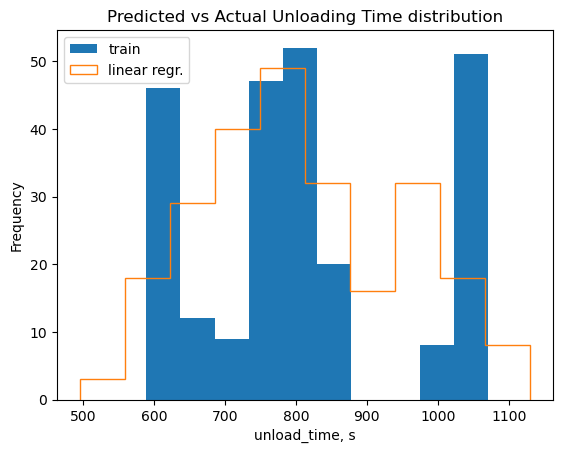

In [151]:
unload_time_pred_train = model_linreg.predict(sm.add_constant(X_train_unloaded[xvs_opt])) # Predict 'unload_time' for training dataset

plt.title('Predicted vs Actual Unloading Time distribution')
plt.hist(y_train_unloaded['unload_time'], label='train')
plt.hist(unload_time_pred_train, label='linear regr.', histtype='step')
plt.xlabel('unload_time, s')
plt.ylabel('Frequency')
plt.legend()
plt.show()

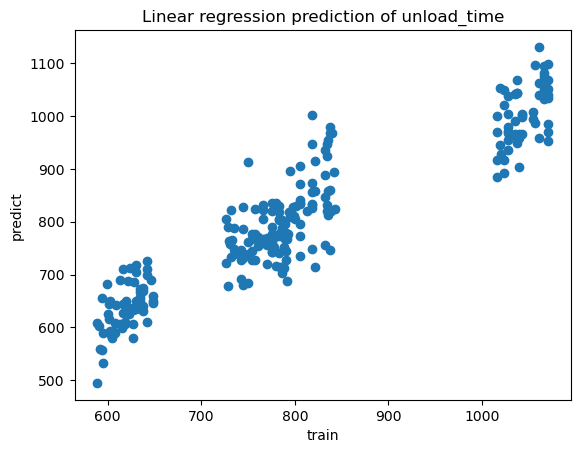

In [152]:
plt.title('Linear regression prediction of unload_time')
plt.plot(y_train_unloaded['unload_time'], unload_time_pred_train, 'o')
plt.xlabel('train')
plt.ylabel('predict')
plt.show()

In [153]:
unload_time_pred_train - y_train['unload_time'] # visually inspect model errors

pixel_id
T2213     -102.326953
T2213_2      2.170162
T2214        2.184688
T2214_2     30.552350
T2215      -20.482162
              ...    
T2375_2    -25.459418
T2376       24.998893
T2376_2     14.191201
T2377      -15.418938
T2377_2     -9.657488
Length: 325, dtype: float64

In [154]:
print("Training MSE =", mean_squared_error(y_train_unloaded['unload_time'], unload_time_pred_train)) # Quality of linear fit, MSE train

Training MSE = 3057.2942463147574


MSE for training data has slightly increased after changing the order of adding independent variables to the linear regression model.

#### Test 'unload_timestamp' prediction on Validation data

In [155]:
idx_unloaded_val = y_val.loc[y_val['unloaded'] == 1].index
print(f"{len(idx_unloaded_val)} assets: {list(idx_unloaded_val)}")

50 assets: ['T2213', 'T2214', 'T2215', 'T2218', 'T2219', 'T2220', 'T2222', 'T2224', 'T2225', 'T2226', 'T2227', 'T2233', 'T2234', 'T2239', 'T2240', 'T2242', 'T2243', 'T2244', 'T2249', 'T2253', 'T2254', 'T2256', 'T2259', 'T2261', 'T2264', 'T2265', 'T2268', 'T2270', 'T2272', 'T2318', 'T2322', 'T2323', 'T2327', 'T2331', 'T2332', 'T2341', 'T2346', 'T2348', 'T2352', 'T2356', 'T2362', 'T2363', 'T2364', 'T2365', 'T2366', 'T2367', 'T2371', 'T2373', 'T2374', 'T2376']


In [156]:
X_val_unloaded = X_val.loc[idx_unloaded_val]
y_val_unloaded = y_val.loc[idx_unloaded_val]
X_val_unloaded

,gateway1p,signal_time_mean,signal_time_sd,packet_mean,packet_sd,signal_mean,signal_sd,temperature_mean,temperature_sd,nfpkt_mean,...,latest_575345CE2154,latest_D088ED75B4E3,latest_F2862879ADE1,latest_2B9CA06C53B2,latest_3D9B5E166F18,latest_61DDE8F31239,latest_671E77344434,latest_6EE5945E8B73,latest_93D44D27CAB1,dt_1
pixel_id,,,,,,,,,,,,,,,,,,,,,
T2213,0.000000,622.683118,230.257258,0.409392,0.915449,0.510229,0.310812,0.562388,0.528197,0.069889,...,0,0,0,0,0,0,0,1,0,0.161573
T2214,0.000000,790.214875,9.137127,0.333138,0.069401,0.443817,0.478738,0.312440,0.382671,0.000000,...,0,0,0,0,0,0,1,0,0,0.023007
T2215,0.000000,650.116533,185.958029,0.451916,0.974542,0.596947,0.470219,0.491206,0.422509,0.047525,...,0,0,0,0,0,1,0,0,0,0.411411
T2218,0.000000,500.889238,268.487207,0.646418,0.642489,0.635507,0.285237,0.700748,0.113219,0.192362,...,0,0,0,0,0,0,1,0,0,0.058294
T2219,0.040000,584.646480,257.445236,0.411702,0.355309,0.718205,0.398170,0.552811,0.220354,0.076040,...,0,0,0,0,0,0,0,1,0,0.154314
T2220,0.000000,391.855381,298.515942,0.657579,0.547975,0.635507,0.358728,0.674555,0.247777,0.158416,...,0,0,0,0,0,0,1,0,0,0.056043
T2222,0.000000,631.455667,248.116361,0.813768,0.661546,0.583104,0.845061,0.271186,0.000000,0.052805,...,0,0,0,0,0,0,1,0,0,0.890016
T2224,0.000000,592.624071,272.408483,0.384232,0.926435,0.593980,0.722708,0.467632,0.487405,0.033946,...,0,0,0,0,0,0,1,0,0,0.030908
T2225,0.000000,589.891526,242.975619,0.334389,0.538190,0.707320,0.340618,0.554895,0.439152,0.087546,...,0,0,0,0,0,0,1,0,0,0.191179


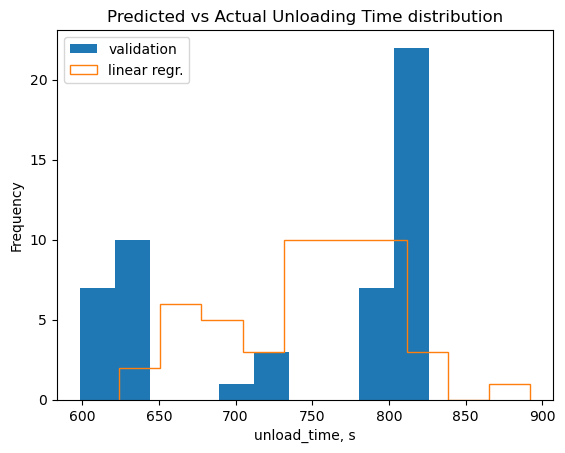

In [157]:
unload_time_pred_val = model_linreg.predict(sm.add_constant(X_val_unloaded[xvs_opt])) # Predict 'unload_time' for training dataset

plt.title('Predicted vs Actual Unloading Time distribution')
plt.hist(y_val_unloaded['unload_time'], label='validation')
plt.hist(unload_time_pred_val, label='linear regr.', histtype='step')
plt.xlabel('unload_time, s')
plt.ylabel('Frequency')
plt.legend()
plt.show()

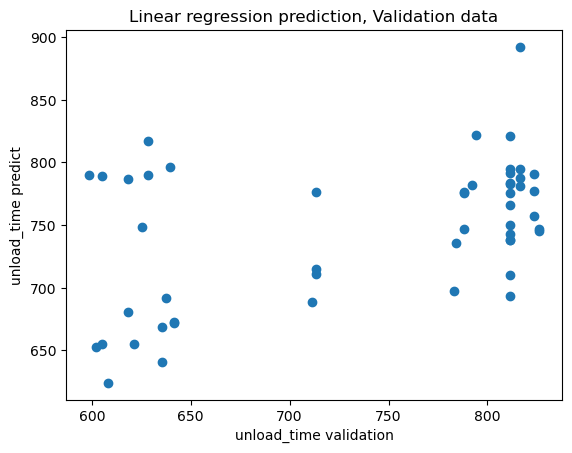

In [158]:
plt.title('Linear regression prediction, Validation data')
plt.plot(y_val_unloaded['unload_time'], unload_time_pred_val, 'o')
plt.xlabel('unload_time validation')
plt.ylabel('unload_time predict')
plt.show()

In [159]:
unload_time_pred_val - y_val['unload_time'] # Visual inspection of model errors

pixel_id
T2213    -41.652137
T2214    -11.828512
T2215    -12.892411
T2218      9.527429
T2219    -73.401877
            ...    
T2367     31.652532
T2371     54.267342
T2373    156.642251
T2374     33.379707
T2376      5.315618
Length: 63, dtype: float64

In [160]:
print("Validation MSE =", mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)) # Quality of linear fit, MSE validation, concise linear regression model

Validation MSE = 6231.639111918962


MSE for validation data is ~2x larger than for the training data, approximately same as for the worse linear regression model.

In [161]:
# Save the Linear Regression model
with open(r"model_linreg.pkl", "wb") as output_file:
    pickle.dump(model_linreg, output_file)

###  LASSO Regression

C:\Users\Victoria\AppData\Local\Temp\ipykernel_10328\2438986269.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_lasso.fit(X_train_unloaded, y_train_unloaded['unload_time']) # Fit the model using the training data
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.680e+05, tolerance: 5.602e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in skle

Optimal alpha = 3.59
Optimal MSE = 3561.213997968084


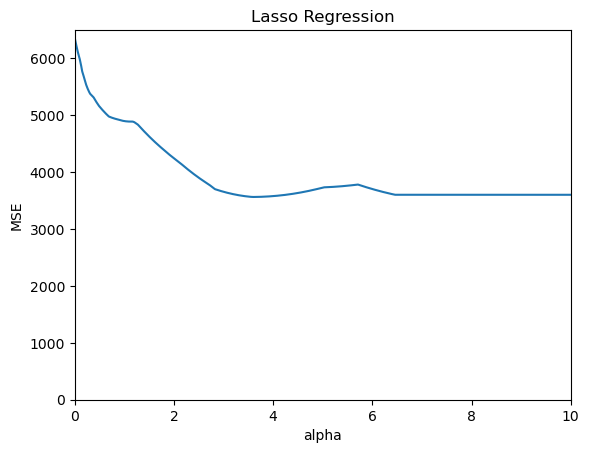

In [162]:
# Hyperparameter 'alpha' grid
alpha_lasso = []
mse_lasso = []
alpha_lasso_opt = 0
mse_opt = 1e15
for alpha in np.arange(0,10+0.01,0.01):
    model_lasso = Lasso(alpha=alpha, max_iter=10000) # Create Lasso regression object
    model_lasso.fit(X_train_unloaded, y_train_unloaded['unload_time']) # Fit the model using the training data
    y_pred_val = model_lasso.predict(X_val_unloaded) # Predict the target variable using the test data
    mse = mean_squared_error(y_val_unloaded['unload_time'], y_pred_val)
    alpha_lasso.append(alpha)
    mse_lasso.append(mse)
    if mse < mse_opt:
        mse_opt = mse
        alpha_lasso_opt = alpha
print("Optimal alpha =", alpha_lasso_opt)
print("Optimal MSE =", mse_opt)
plt.title('Lasso Regression')
plt.plot(alpha_lasso, mse_lasso)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.xlim(0,10)
plt.ylim(0,)
plt.show()

In [163]:
# Optimal Lasso Regression model!
print("alpha_lasso_opt =", alpha_lasso_opt)
model_lasso = Lasso(alpha=alpha_lasso_opt, max_iter=10000) # Create Lasso regression object, set 'alpha' to optimal value
model_lasso.fit(X_train_unloaded, y_train_unloaded['unload_time']) # Fit the model using the training data
unload_time_pred_val = model_lasso.predict(X_val_unloaded) # Predict the target variable using the test data
mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val) # Evaluate the model using mean squared error
print('Mean squared error:', mse)

# View the model coefficients
#print('Model coefficients:', model_lasso.coef_)
print(y_val_unloaded['unload_time'].name + "= ")
print(f"{model_lasso.coef_[0]}*{X_train.columns[0]}")
for i in range(1, len(X_train.columns)):
     if model_lasso.coef_[i] > 0:
          print(f"+{model_lasso.coef_[i]}*{X_train.columns[i]}")
     elif model_lasso.coef_[i] < 0:
          print(f"-{-model_lasso.coef_[i]}*{X_train.columns[i]}")

alpha_lasso_opt = 3.59
Mean squared error: 3561.213997968084
unload_time= 
0.0*gateway1p
+0.5585268132298254*signal_time_mean
+0.31639238225282484*signal_time_sd
+74.26423624856065*nfpkt_mean
+98.81202232102451*bridge_F2862879ADE1
-3.8648218166530834*latest_3D9B5E166F18
+11.210928915081492*latest_671E77344434


In [212]:
def adjR2(y_true, y_pred, k, prn=True):
    '''Adjusted R squared for K independent variables.
    Inputs:
    k - number of predictors (intercept excluded). E.g., k = len(lasso_cv.coef_)'''
    # Calculate R-squared for LassoCV model
    r2 = r2_score(y_true, y_pred)
    # R-squared is the regular coefficient of determination (explained variance) of the model.
    if prn: print("R-squared:", r2)
    
    # Calculate adjusted R-squared for LassoCV model
    n = len(y_true)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    if prn: print("Adjusted R-squared:", adj_r2)
    return adj_r2
    #The adjusted R-squared formula penalizes the R-squared value for including more predictors in the model.

In [172]:
r2_score(y_val_unloaded['unload_time'], unload_time_pred_val)

0.5325683300500779

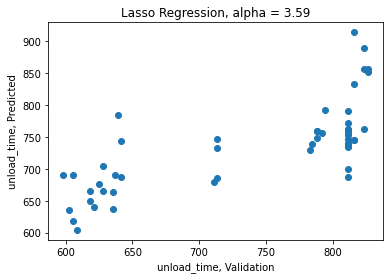

In [197]:
plt.title('Lasso Regression, alpha = '+str(alpha_lasso_opt))
plt.plot(y_val_unloaded['unload_time'], unload_time_pred_val, 'o')
plt.xlabel('unload_time, Validation')
plt.ylabel('unload_time, Predicted')
plt.show()

In [198]:
print("Validation MSE =", mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)) # Quality of linear fit, MSE validation, concise linear regression model

Validation MSE = 3561.2139979680833


In [177]:
adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 6) # y_true, y_predicted, number_variables

R-squared: 0.5325683300500779
Adjusted R-squared: 0.46734530633613525


0.46734530633613525

Lasso Regression gives a much better prediction than Linear Regression.

In [199]:
# Save the best LASSO regression model
with open(r"model_lasso.pkl", "wb") as output_file:
    pickle.dump(model_lasso, output_file)

### Polynomial Regression Using ML
The set and the order in which variables are added is extremely important for the polynomial regression model.

In [298]:
# Polynomial Regression Using ML

# Train polynomial regression model for increasing number of variables, added one by one as in X_train
xvs = X_train_unloaded.columns # all features

# Train polynomial regression model for the same x-variables as in the best LASSO model
#xvs = ['gateway1p','signal_time_mean','signal_time_sd','nfpkt_mean','bridge_F2862879ADE1','latest_3D9B5E166F18','latest_671E77344434']

# The best found combination of variables
xvs = ['gateway1p','signal_time_mean','signal_time_sd','bridge_F2862879ADE1'] # See how addition of 'nfpkt_mean' upsets the quality

#for i in range(1, X_train_unloaded.shape[1]+1):
for i in range(1, 11):
    # Create polynomial features
    model_polyregml = PolynomialFeatures(degree=2, include_bias=False) # Choose polynomial degree
    X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[xvs[:i]])) # powers 1, 2, ..., degree of the first i x-vars

    # Train polynomial regression model
    reg = LinearRegression()
    reg.fit(X_poly, y_train_unloaded['unload_time'])

    # Make predictions on test set
    X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[xvs[:i]])) # powers of first i x-vars from validation dataset
    unload_time_pred_val = reg.predict(X_val_poly)

    # Evaluate model performance
    mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
    adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, i)
    
    print("Mean squared error for %d variables: %.4f\n" % (i, mse))

R-squared: -0.8139759654593131
Adjusted R-squared: -0.8517671314063822
Mean squared error for 1 variables: 13820.1089

R-squared: -0.11582915767829882
Adjusted R-squared: -0.16331124949439668
Mean squared error for 2 variables: 8501.1493

R-squared: 0.6807575914682904
Adjusted R-squared: 0.6599374343901354
Mean squared error for 3 variables: 2432.2069

R-squared: -99.89695505817399
Adjusted R-squared: -108.86557328556722
Mean squared error for 4 variables: 768701.9768

R-squared: -49.28633510672799
Adjusted R-squared: -55.000691368856174
Mean squared error for 5 variables: 383115.6766

R-squared: -1469.6171412642368
Adjusted R-squared: -1674.819533068549
Mean squared error for 6 variables: 11204166.6960

R-squared: -31556.0759825589
Adjusted R-squared: -36815.58864631872
Mean squared error for 7 variables: 240423377.2523

R-squared: -435.7511218530814
Adjusted R-squared: -520.9708529463655
Mean squared error for 8 variables: 3327468.6093

R-squared: -116.47526575297454
Adjusted R-squar

<b>Polynomial Regression Using ML</b> with varied polynomial degree. MSE was minimized by varying the number of x-variables from the fixed set `xvs`.

| degree | variables | Adj. R^2 | MSE |
| --- | --- | --- | --- |
| 1 | 3 | 0.49271851824184454 | 3628.1957 |
| 2 | 3 | 0.6313590976842839 | 2636.6058 |
| 3 | 3 | 0.6613719639548461 | 2421.9468 |
| <b>4</b> | 3 | <b>0.70121606105886</b>   | <b>2136.9725</b> |
| 5 | 3 | 0.6599374343901354 | 2432.2069 |
| 6 | 3 | 0.680158230314539 | 2287.5830 |
| 7 | 2 | -0.005748785448408622 | 7349.7274 |
| 8 | 2 | -0.02787740793922766 | 7511.4371 |
| 9 | 2 | -0.046923358658647274 | 7650.6195 |
| 10 | 3 | 0.15046297312493206 | 6076.0873 |

The best set of three x-variables is 'gateway1p', 'signal_time_mean', and 'signal_time_sd'. Polynomial Regression ML model diverges with addition of more variables.
Taking the same set of x-variables as in the optimized LASSO model does not change the above results.
To illustrate the importance of the order in which x-variables are added, and to further minimize the MSE, consider

In [335]:
# Train polynomial regression model for increasing number of x-vars from the best found set
#xvs = ['gateway1p','signal_time_mean','signal_time_sd','bridge_F2862879ADE1']

# See how extra x-variable can upset the model if added before reaching the optimal number of variables
#xvs = ['gateway1p','signal_time_mean','signal_time_sd','nfpkt_mean','bridge_F2862879ADE1']

# Move extra x-variable beyond the optimal number of variables to avoid model degradation
xvs = ['gateway1p','signal_time_mean','signal_time_sd','bridge_F2862879ADE1','nfpkt_mean']

#for i in range(1, X_train_unloaded.shape[1]+1):
for i in range(1, 11):
    # Create polynomial features
    model_polyregml = PolynomialFeatures(degree=2, include_bias=False) # Choose polynomial degree
    X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[xvs[:i]])) # powers 1, 2, ..., degree of the first i x-vars

    # Train polynomial regression model
    reg = LinearRegression()
    reg.fit(X_poly, y_train_unloaded['unload_time'])

    # Make predictions on test set
    X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[xvs[:i]])) # powers of first i x-vars from validation dataset
    unload_time_pred_val = reg.predict(X_val_poly)

    # Evaluate model performance
    mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
    adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, i)
    
    print("Mean squared error for %d variables: %.4f\n" % (i, mse))

R-squared: -0.7311538078951472
Adjusted R-squared: -0.7672195122262959
Mean squared error for 1 variables: 13189.1131

R-squared: 0.07457521497186792
Adjusted R-squared: 0.03519543688556448
Mean squared error for 2 variables: 7050.5186

R-squared: 0.6539289488464706
Adjusted R-squared: 0.6313590976842839
Mean squared error for 3 variables: 2636.6058

R-squared: 0.7547493914495631
Adjusted R-squared: 0.7329493373561909
Mean squared error for 4 variables: 1868.4868

R-squared: -0.2433621804426267
Adjusted R-squared: -0.38465333731110696
Mean squared error for 5 variables: 9472.7831

R-squared: -0.2433621804426267
Adjusted R-squared: -0.41685457771369094
Mean squared error for 6 variables: 9472.7831

R-squared: -0.2433621804426267
Adjusted R-squared: -0.4505892105163978
Mean squared error for 7 variables: 9472.7831

R-squared: -0.2433621804426267
Adjusted R-squared: -0.4859694351631392
Mean squared error for 8 variables: 9472.7831

R-squared: -0.2433621804426267
Adjusted R-squared: -0.523

Even lower MSE is obtained by varying the set of x-variables.

In [349]:
dill.dump_session('DS_interview_v2.db')
#dill.load_session('DS_interview_v2.db')

#### Search for optimal set of x-variables
Now let us try each x-variable, one by one, with polynomial degree optimized based on lowest MSE of predictions with validation data.

In [335]:
# Train polynomial regression model for each of the x-variables, with varied polynomial degree
xvs = list(X_train_unloaded.columns) # all features
mse_df_polyregml_1 = pd.DataFrame(columns=["x","degree","adjR2","mse"]) # results dataframe
#print("| x | degree | adjR2 | mse |")
#print("| --- | --- | --- | --- |")
mse_min_allxv = 1e16 # minimal MSE across all x-vars
for xv in xvs: # each x-variable
    mse_min = 1e16
    for degree in range(1, 20): # polynomial degrees grid
        # Create polynomial features
        model_polyregml = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[xv]).reshape(-1, 1)) # powers 1, 2, ..., degree of the xv-variable
        # Train polynomial regression model
        reg = LinearRegression()
        reg.fit(X_poly, y_train_unloaded['unload_time'])
        # Make predictions on test set
        X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[xv]).reshape(-1, 1)) # powers of xv-variable from validation dataset
        unload_time_pred_val = reg.predict(X_val_poly)
        
        # Evaluate model performance
        mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
        adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 1, prn=False)
        if mse < mse_min:
            mse_min = mse
            degree_opt = degree
            adjr2_opt = adjr2
            reg_opt = reg
    #print(f"| {xv} | {degree_opt} | {adjr2_opt} | {mse_min} |")
    mse_df_polyregml_1.loc[len(mse_df_polyregml_1)] = [xv, degree_opt, adjr2_opt, mse_min]
    if mse_min < mse_min_allxv:
        mse_min_allxv = mse_min
        xv_opt = xv # optimal additional x-variable
        reg_opt_allxv = reg_opt
print(f"Lowest-MSE x-variable: {xv_opt}:")
print("Intercept =", reg_opt_allxv.intercept_)
print("Coefficients =", reg_opt_allxv.coef_)
mse_df_polyregml_1.sort_values('mse', axis=0, ascending=True, inplace=True)
mse_df_polyregml_1

Lowest-MSE x-variable: signal_time_sd:
Intercept = 735.9305830980828
Coefficients = [-8.55950959e-13 -5.02847098e-10 -1.33493139e-08 -8.81492824e-07
  9.32725507e-09 -3.59213987e-11  6.05080570e-14 -3.77602094e-17]


,x,degree,adjR2,mse
2,signal_time_sd,8,0.162570,6249.904438
1,signal_time_mean,2,0.007239,7409.172610
12,oscillation_sd,2,-0.425101,10635.816225
17,bridge_3D9B5E166F18,2,-0.600899,11947.830773
13,bridge_575345CE2154,3,-0.637063,12217.730235
11,oscillation_mean,7,-0.637276,12219.320624
23,earliest_D088ED75B4E3,1,-0.646982,12291.755196
6,signal_sd,1,-0.666238,12435.471435
35,latest_3D9B5E166F18,3,-0.667893,12447.816310
31,latest_575345CE2154,1,-0.674831,12499.599275


In [339]:
# Train polynomial regression model with 2 x-variables, 1st one is lowest-MSE; varied polynomial degree
xv1 = mse_df_polyregml_1['x'].iloc[0] #lowest-MSE x-variable
if xv1 in xvs: xvs.remove(xv1) # remove a list item by value

mse_df_polyregml_2 = pd.DataFrame(columns=["x","degree","adjR2","mse"]) # results dataframe
#print("| x | degree | adjR2 | mse |")
#print("| --- | --- | --- | --- |")
mse_min_allxv = 1e16 # minimal MSE across all x-vars
for xv in xvs: # each x-variable
    mse_min = 1e16
    for degree in range(1, 20): # polynomial degrees grid
        # Create polynomial features
        model_polyregml = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[[xv1,xv]])) # powers 1, 2, ..., degree of the xv-variable
        # Train polynomial regression model
        reg = LinearRegression()
        reg.fit(X_poly, y_train_unloaded['unload_time'])
        # Make predictions on test set
        X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[[xv1,xv]])) # powers of xv-variable from validation dataset
        unload_time_pred_val = reg.predict(X_val_poly)
        
        # Evaluate model performance
        mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
        adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 2, prn=False)
        if mse < mse_min:
            mse_min = mse
            degree_opt = degree
            adjr2_opt = adjr2
            reg_opt = reg
    #print(f"| {[xv1,xv]} | {degree_opt} | {adjr2_opt} | {mse_min} |")
    mse_df_polyregml_2.loc[len(mse_df_polyregml_2)] = [[xv1,xv], degree_opt, adjr2_opt, mse_min]
    if mse_min < mse_min_allxv:
        mse_min_allxv = mse_min
        xv_opt = xv # optimal additional x-variable
        reg_opt_allxv = reg_opt
print('2nd variable is '+xv_opt+':')
print("Intercept =", reg_opt_allxv.intercept_)
print("Coefficients =", reg_opt_allxv.coef_)
mse_df_polyregml_2.sort_values('mse', axis=0, ascending=True, inplace=True)
mse_df_polyregml_2

2nd variable is signal_time_mean:
Intercept = -776.3970577482286
Coefficients = [ 1.10545115e+01  3.29587602e-01 -6.09374806e-03 -3.10641085e-02
  9.52677930e-03 -9.45100357e-06  1.89906121e-05  2.92678625e-05
 -1.43199644e-05 -2.81274097e-08  3.71957870e-08 -1.85170950e-08
 -9.63348415e-09  6.21585123e-09]


,x,degree,adjR2,mse
1,"[signal_time_sd, signal_time_mean]",4,0.722954,2024.576891
16,"[signal_time_sd, bridge_3D9B5E166F18]",7,0.326769,4919.779060
14,"[signal_time_sd, bridge_F2862879ADE1]",7,0.252819,5460.185575
21,"[signal_time_sd, earliest_575345CE2154]",8,0.248129,5494.458534
23,"[signal_time_sd, earliest_F2862879ADE1]",8,0.197124,5867.192962
19,"[signal_time_sd, bridge_6EE5945E8B73]",8,0.186674,5943.558212
18,"[signal_time_sd, bridge_671E77344434]",7,0.179385,5996.821359
34,"[signal_time_sd, latest_3D9B5E166F18]",9,0.178698,6001.842457
11,"[signal_time_sd, oscillation_sd]",9,0.169246,6070.913966
26,"[signal_time_sd, earliest_61DDE8F31239]",9,0.168524,6076.194528


In [342]:
# Train polynomial regression model with 2 x-variables, 1st one is lowest-MSE; varied polynomial degree
xv2 = mse_df_polyregml_2['x'].iloc[0][1] #2nd lowest-MSE x-variable
if xv2 in xvs: xvs.remove(xv2) # remove xv2 from the list of remaining x-variables xvs

mse_df_polyregml_3 = pd.DataFrame(columns=["x","degree","adjR2","mse"]) # results dataframe
#print("| x | degree | adjR2 | mse |")
#print("| --- | --- | --- | --- |")
for xv in xvs: # each x-variable
    mse_min = 1e16
    for degree in range(1, 20): # polynomial degrees grid
        # Create polynomial features
        model_polyregml = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[[xv1,xv2,xv]])) # powers 1, 2, ..., degree of the xv-variable
        # Train polynomial regression model
        reg = LinearRegression()
        reg.fit(X_poly, y_train_unloaded['unload_time'])
        # Make predictions on test set
        X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[[xv1,xv2,xv]])) # powers of xv-variable from validation dataset
        unload_time_pred_val = reg.predict(X_val_poly)
        
        # Evaluate model performance
        mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
        adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 3, prn=False)
        if mse < mse_min:
            mse_min = mse
            degree_opt = degree
            adjr2_opt = adjr2
            reg_opt = reg
    #print(f"| {[xv1,xv]} | {degree_opt} | {adjr2_opt} | {mse_min} |")
    mse_df_polyregml_3.loc[len(mse_df_polyregml_3)] = [[xv1,xv2,xv], degree_opt, adjr2_opt, mse_min]
    if mse_min < mse_min_allxv:
        mse_min_allxv = mse_min
        xv_opt = xv # optimal additional x-variable
        reg_opt_allxv = reg_opt
print('\n3rd variable is '+xv_opt+':')
print("Intercept =", reg_opt_allxv.intercept_)
print("Coefficients =", reg_opt_allxv.coef_)
mse_df_polyregml_3.sort_values('mse', axis=0, ascending=True, inplace=True)
mse_df_polyregml_3


3rd variable is latest_3D9B5E166F18:
Intercept = -743.3495326325227
Coefficients = [ 9.55224474e+00  9.49887333e-02  3.44268283e+02 -1.08513972e-03
 -2.74047355e-02 -4.99676091e-01  1.02182497e-02 -1.63270403e+00
  3.43563410e+02 -1.09918047e-06  1.62581828e-06 -1.55171434e-03
  2.81560839e-05  2.93241034e-03 -5.09645782e-01 -1.52014313e-05
  3.29309528e-03 -1.62422678e+00  3.43562577e+02 -2.29705296e-08
  2.56507320e-08 -7.13237421e-06 -6.28126188e-09  1.06726875e-05
 -2.51627548e-03 -1.04834059e-08 -5.58338373e-06  2.53936307e-03
 -5.43776521e-01  6.60280909e-09 -1.77907948e-06  2.09998750e-03
 -1.62422668e+00  3.43562577e+02]


,x,degree,adjR2,mse
33,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.784425,1541.843920
35,"[signal_time_sd, signal_time_mean, latest_671E...",4,0.739322,1864.429057
25,"[signal_time_sd, signal_time_mean, earliest_61...",4,0.736002,1888.173533
17,"[signal_time_sd, signal_time_mean, bridge_671E...",4,0.733666,1904.883059
0,"[signal_time_sd, signal_time_mean, gateway1p]",5,0.730959,1924.244050
15,"[signal_time_sd, signal_time_mean, bridge_3D9B...",3,0.726751,1954.343882
28,"[signal_time_sd, signal_time_mean, earliest_93...",5,0.718591,2012.700629
24,"[signal_time_sd, signal_time_mean, earliest_3D...",4,0.717577,2019.955763
21,"[signal_time_sd, signal_time_mean, earliest_D0...",4,0.717278,2022.094253
26,"[signal_time_sd, signal_time_mean, earliest_67...",4,0.716930,2024.579997


In [346]:
# Best Polynomial Regression ML model
#xvs_try = ['signal_time_mean','signal_time_sd','bridge_F2862879ADE1','gateway1p']
xvs_try = ['signal_time_sd', 'signal_time_mean', 'latest_3D9B5E166F18']
# Create polynomial features
degree=4
model_polyregml = PolynomialFeatures(degree=degree, include_bias=False) # Optimal polynomial degree!
X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[xvs_try]))
# Train polynomial regression model
reg = LinearRegression()
reg.fit(X_poly, y_train_unloaded['unload_time'])

# Make predictions on test set
X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[xvs_try])) # powers of first i x-vars from validation dataset
y_pred_val = reg.predict(X_val_poly)

# Evaluate model performance
mse = mean_squared_error(y_val_unloaded['unload_time'], y_pred_val)
adjr2 = adjR2(y_val_unloaded['unload_time'], y_pred_val, i)
print("Mean squared error for %d variables: %.4f\n" % (len(xvs_try),mse))

print(f"Parameters of the Linear Regression using Polynomial degree {degree} of features:")
print("Intercept =", reg.intercept_)
print("Coefs =", reg.coef_)

R-squared: 0.797623316429515
Adjusted R-squared: -0.10182861055041825
Mean squared error for 3 variables: 1541.8439

Parameters of the Linear Regression using Polynomial degree 4 of features:
Intercept = -743.3495326325227
Coefs = [ 9.55224474e+00  9.49887333e-02  3.44268283e+02 -1.08513972e-03
 -2.74047355e-02 -4.99676091e-01  1.02182497e-02 -1.63270403e+00
  3.43563410e+02 -1.09918047e-06  1.62581828e-06 -1.55171434e-03
  2.81560839e-05  2.93241034e-03 -5.09645782e-01 -1.52014313e-05
  3.29309528e-03 -1.62422678e+00  3.43562577e+02 -2.29705296e-08
  2.56507320e-08 -7.13237421e-06 -6.28126188e-09  1.06726875e-05
 -2.51627548e-03 -1.04834059e-08 -5.58338373e-06  2.53936307e-03
 -5.43776521e-01  6.60280909e-09 -1.77907948e-06  2.09998750e-03
 -1.62422668e+00  3.43562577e+02]


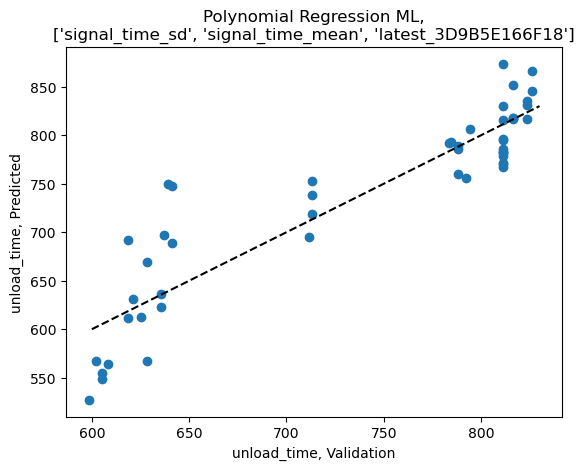

In [348]:
plt.title('Polynomial Regression ML,\n'+str(xvs_try))
plt.plot(y_val_unloaded['unload_time'], y_pred_val, 'o')
plt.xlabel('unload_time, Validation')
plt.ylabel('unload_time, Predicted')
plt.plot(np.linspace(600, 830, 10),np.linspace(600, 830, 10), '--', c='k')
plt.show()

This seems to be the best model.

In [349]:
# Save the best Polynomial Regression ML model
with open(r"model_polyregml.pkl", "wb") as output_file:
    pickle.dump(reg, output_file) # save linear regression on polynomial features

In [ ]:
#reg.intercept_ = -743.3495326325227
#reg.coef_ = np.array([ 9.55224474e+00,  9.49887333e-02,  3.44268283e+02, -1.08513972e-03,
#       -2.74047355e-02, -4.99676091e-01,  1.02182497e-02, -1.63270403e+00,
#        3.43563410e+02, -1.09918047e-06,  1.62581828e-06, -1.55171434e-03,
#        2.81560839e-05,  2.93241034e-03, -5.09645782e-01, -1.52014313e-05,
#        3.29309528e-03, -1.62422678e+00,  3.43562577e+02, -2.29705296e-08,
#        2.56507320e-08, -7.13237421e-06, -6.28126188e-09,  1.06726875e-05,
#       -2.51627548e-03, -1.04834059e-08, -5.58338373e-06,  2.53936307e-03,
#       -5.43776521e-01,  6.60280909e-09, -1.77907948e-06,  2.09998750e-03,
#       -1.62422668e+00,  3.43562577e+02])

In [354]:
# Train polynomial regression model with 2 x-variables, 1st one is lowest-MSE; varied polynomial degree
#xvs = ['gateway1p', 'packet_mean', 'packet_sd', 'signal_mean', 'signal_sd', 'temperature_mean', 'temperature_sd', 'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd', 'bridge_575345CE2154', 'bridge_D088ED75B4E3', 'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18', 'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73', 'bridge_93D44D27CAB1', 'earliest_575345CE2154', 'earliest_D088ED75B4E3', 'earliest_F2862879ADE1', 'earliest_2B9CA06C53B2', 'earliest_3D9B5E166F18', 'earliest_61DDE8F31239', 'earliest_671E77344434', 'earliest_6EE5945E8B73', 'earliest_93D44D27CAB1', 'latest_575345CE2154', 'latest_D088ED75B4E3', 'latest_F2862879ADE1', 'latest_2B9CA06C53B2', 'latest_3D9B5E166F18', 'latest_61DDE8F31239', 'latest_671E77344434', 'latest_6EE5945E8B73', 'latest_93D44D27CAB1', 'dt_1']
xv3 = mse_df_polyregml_3['x'].iloc[0][2] #3rd lowest-MSE x-variable
if xv3 in xvs: xvs.remove(xv3) # remove xv3 from the list of remaining x-variables xvs

mse_df_polyregml_4 = pd.DataFrame(columns=["x","degree","adjR2","mse"]) # results dataframe
#print("| x | degree | adjR2 | mse |")
#print("| --- | --- | --- | --- |")
for xv in xvs: # each x-variable
    mse_min = 1e16
    for degree in range(1, 20): # polynomial degrees grid
        # Create polynomial features
        model_polyregml = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[[xv1,xv2,xv3,xv]])) # powers 1, 2, ..., degree of the xv-variable
        # Train polynomial regression model
        reg = LinearRegression()
        reg.fit(X_poly, y_train_unloaded['unload_time'])
        # Make predictions on test set
        X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[[xv1,xv2,xv3,xv]])) # powers of xv-variable from validation dataset
        unload_time_pred_val = reg.predict(X_val_poly)
        
        # Evaluate model performance
        mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
        adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 4, prn=False)
        if mse < mse_min:
            mse_min = mse
            degree_opt = degree
            adjr2_opt = adjr2
            reg_opt = reg
    #print(f"| {[xv1,xv]} | {degree_opt} | {adjr2_opt} | {mse_min} |")
    mse_df_polyregml_4.loc[len(mse_df_polyregml_4)] = [[xv1,xv2,xv3,xv], degree_opt, adjr2_opt, mse_min]
    if mse_min < mse_min_allxv:
        mse_min_allxv = mse_min
        xv_opt = xv # optimal additional x-variable
        reg_opt_allxv = reg_opt
print('\n4th variable is '+xv_opt+':')
print("Intercept =", reg_opt_allxv.intercept_)
print("Coefficients =", reg_opt_allxv.coef_)
mse_df_polyregml_4.sort_values('mse', axis=0, ascending=True, inplace=True)
mse_df_polyregml_4


4th variable is earliest_671E77344434:
Intercept = 705.857667585093
Coefficients = [ 1.59399724e-05 -4.36543881e-06  7.33106608e-07 -1.78864153e-06
 -6.00456881e-07  6.18914011e-07 -4.38502485e-07 -4.52669444e-07
 -4.46635637e-07  3.87409639e-09  7.07180466e-08 -1.51982624e-07
  3.07301633e-09  6.27559620e-08  3.51516244e-06  2.76997378e-06
 -2.85613077e-08  9.12653843e-13 -5.73963590e-06 -4.19907876e-08
 -1.66465491e-13 -2.09768042e-10  6.39454931e-14  8.85041020e-14
 -4.51791414e-05 -4.54263414e-08  2.16081697e-13 -3.48625645e-10
  1.87064504e-14 -3.31495246e-14 -1.43006861e-12  1.33244448e-14
  1.64123552e-17  2.08572483e-17 -4.46667711e-06  6.01088203e-06
 -2.35561777e-06  1.27332875e-18 -2.38394908e-06 -4.01861121e-06
  5.55463031e-18 -2.85614032e-08  1.25310054e-17 -6.74407633e-18
  3.47405559e-07 -3.72568024e-06  7.11507676e-20 -4.19909440e-08
  0.00000000e+00  0.00000000e+00 -2.09296334e-10  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.97350024e-07  3.59436221e-06
  0.00

,x,degree,adjR2,mse
26,"[signal_time_sd, signal_time_mean, latest_3D9B...",7,0.801724,1387.286503
28,"[signal_time_sd, signal_time_mean, latest_3D9B...",5,0.788189,1481.986076
21,"[signal_time_sd, signal_time_mean, latest_3D9B...",5,0.786451,1494.147022
32,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.772865,1589.206820
36,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.771552,1598.391887
13,"[signal_time_sd, signal_time_mean, latest_3D9B...",3,0.765440,1641.159175
34,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.754127,1720.310546
0,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.748082,1762.605243
25,"[signal_time_sd, signal_time_mean, latest_3D9B...",3,0.745290,1782.144024
33,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.741207,1810.709165


In [385]:
# Best Polynomial Regression ML model
xvs_try = ['signal_time_sd', 'signal_time_mean', 'latest_3D9B5E166F18', 'earliest_671E77344434']
# Create polynomial features
degree=7
model_polyregml = PolynomialFeatures(degree=degree, include_bias=False) # Optimal polynomial degree!
X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[xvs_try]))
# Train polynomial regression model
reg = LinearRegression()
reg.fit(X_poly, y_train_unloaded['unload_time'])

# Make predictions on test set
X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[xvs_try])) # powers of first i x-vars from validation dataset
y_pred_val = reg.predict(X_val_poly)

# Evaluate model performance
mse = mean_squared_error(y_val_unloaded['unload_time'], y_pred_val)
adjr2 = adjR2(y_val_unloaded['unload_time'], y_pred_val, i)
print("Mean squared error for %d variables: %.4f\n" % (len(xvs_try),mse))

print(f"Parameters of the Linear Regression using Polynomial degree {degree} of features:")
print("Intercept =", reg.intercept_)
print("Coefs =", reg.coef_)

R-squared: 0.8179099467085615
Adjusted R-squared: 0.008620820968834986
Mean squared error for 4 variables: 1387.2865

Parameters of the Linear Regression using Polynomial degree 7 of features:
Intercept = 705.857667585093
Coefs = [ 1.59399724e-05 -4.36543881e-06  7.33106608e-07 -1.78864153e-06
 -6.00456881e-07  6.18914011e-07 -4.38502485e-07 -4.52669444e-07
 -4.46635637e-07  3.87409639e-09  7.07180466e-08 -1.51982624e-07
  3.07301633e-09  6.27559620e-08  3.51516244e-06  2.76997378e-06
 -2.85613077e-08  9.12653843e-13 -5.73963590e-06 -4.19907876e-08
 -1.66465491e-13 -2.09768042e-10  6.39454931e-14  8.85041020e-14
 -4.51791414e-05 -4.54263414e-08  2.16081697e-13 -3.48625645e-10
  1.87064504e-14 -3.31495246e-14 -1.43006861e-12  1.33244448e-14
  1.64123552e-17  2.08572483e-17 -4.46667711e-06  6.01088203e-06
 -2.35561777e-06  1.27332875e-18 -2.38394908e-06 -4.01861121e-06
  5.55463031e-18 -2.85614032e-08  1.25310054e-17 -6.74407633e-18
  3.47405559e-07 -3.72568024e-06  7.11507676e-20 -4.199

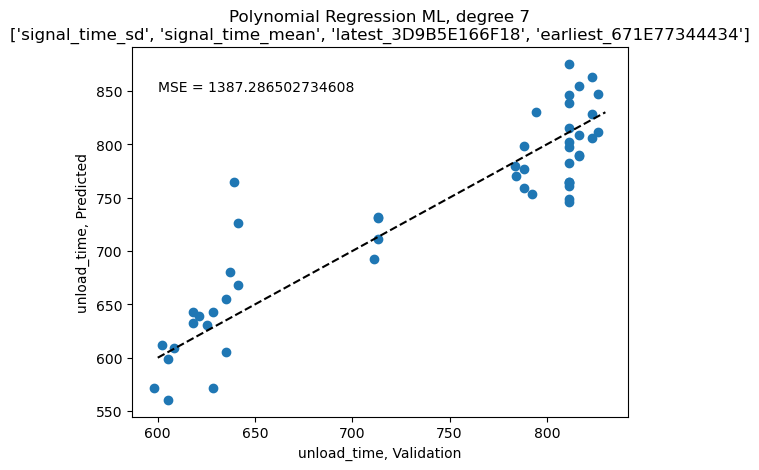

In [386]:
plt.title('Polynomial Regression ML, degree '+str(degree)+'\n'+str(xvs_try))
plt.plot(y_val_unloaded['unload_time'], y_pred_val, 'o')
plt.xlabel('unload_time, Validation')
plt.ylabel('unload_time, Predicted')
plt.plot(np.linspace(600, 830, 10),np.linspace(600, 830, 10), '--', c='k')
plt.text(600,850,'MSE = '+str(mse))
plt.show()

In [387]:
# Save the best Polynomial Regression ML model
with open(r"model_polyregml.pkl", "wb") as output_file:
    pickle.dump(reg, output_file) # save linear regression on polynomial features

In [361]:
# Train polynomial regression model with 2 x-variables, 1st one is lowest-MSE; varied polynomial degree
#xvs = ['gateway1p', 'packet_mean', 'packet_sd', 'signal_mean', 'signal_sd', 'temperature_mean', 'temperature_sd', 'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd', 'bridge_575345CE2154', 'bridge_D088ED75B4E3', 'bridge_F2862879ADE1', 'bridge_2B9CA06C53B2', 'bridge_3D9B5E166F18', 'bridge_61DDE8F31239', 'bridge_671E77344434', 'bridge_6EE5945E8B73', 'bridge_93D44D27CAB1', 'earliest_575345CE2154', 'earliest_D088ED75B4E3', 'earliest_F2862879ADE1', 'earliest_2B9CA06C53B2', 'earliest_3D9B5E166F18', 'earliest_61DDE8F31239', 'earliest_671E77344434', 'earliest_6EE5945E8B73', 'earliest_93D44D27CAB1', 'latest_575345CE2154', 'latest_D088ED75B4E3', 'latest_F2862879ADE1', 'latest_2B9CA06C53B2', 'latest_61DDE8F31239', 'latest_671E77344434', 'latest_6EE5945E8B73', 'latest_93D44D27CAB1', 'dt_1']
xv4 = mse_df_polyregml_4['x'].iloc[0][3] #4th lowest-MSE x-variable
if xv4 in xvs: xvs.remove(xv4) # remove xv4 from the list of remaining x-variables xvs

mse_df_polyregml_5 = pd.DataFrame(columns=["x","degree","adjR2","mse"]) # results dataframe
#print("| x | degree | adjR2 | mse |")
#print("| --- | --- | --- | --- |")
for xv in xvs: # each x-variable
    mse_min = 1e16
    for degree in range(1, 20): # polynomial degrees grid
        # Create polynomial features
        model_polyregml = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = model_polyregml.fit_transform(np.array(X_train_unloaded[[xv1,xv2,xv3,xv4,xv]])) # powers 1, 2, ..., degree of the xv-variable
        # Train polynomial regression model
        reg = LinearRegression()
        reg.fit(X_poly, y_train_unloaded['unload_time'])
        # Make predictions on test set
        X_val_poly = model_polyregml.transform(np.array(X_val_unloaded[[xv1,xv2,xv3,xv4,xv]])) # powers of xv-variable from validation dataset
        unload_time_pred_val = reg.predict(X_val_poly)
        
        # Evaluate model performance
        mse = mean_squared_error(y_val_unloaded['unload_time'], unload_time_pred_val)
        adjr2 = adjR2(y_val_unloaded['unload_time'], unload_time_pred_val, 5, prn=False)
        if mse < mse_min:
            mse_min = mse
            degree_opt = degree
            adjr2_opt = adjr2
            reg_opt = reg
    #print(f"| {[xv1,xv]} | {degree_opt} | {adjr2_opt} | {mse_min} |")
    mse_df_polyregml_5.loc[len(mse_df_polyregml_5)] = [[xv1,xv2,xv3,xv4,xv], degree_opt, adjr2_opt, mse_min]
    if mse_min < mse_min_allxv:
        mse_min_allxv = mse_min
        xv_opt = xv # optimal additional x-variable
        reg_opt_allxv = reg_opt
print('\n4th variable is '+xv_opt+':')
print("Intercept =", reg_opt_allxv.intercept_)
print("Coefficients =", reg_opt_allxv.coef_)
mse_df_polyregml_5.sort_values('mse', axis=0, ascending=True, inplace=True)
mse_df_polyregml_5


4th variable is earliest_671E77344434:
Intercept = 705.857667585093
Coefficients = [ 1.59399724e-05 -4.36543881e-06  7.33106608e-07 -1.78864153e-06
 -6.00456881e-07  6.18914011e-07 -4.38502485e-07 -4.52669444e-07
 -4.46635637e-07  3.87409639e-09  7.07180466e-08 -1.51982624e-07
  3.07301633e-09  6.27559620e-08  3.51516244e-06  2.76997378e-06
 -2.85613077e-08  9.12653843e-13 -5.73963590e-06 -4.19907876e-08
 -1.66465491e-13 -2.09768042e-10  6.39454931e-14  8.85041020e-14
 -4.51791414e-05 -4.54263414e-08  2.16081697e-13 -3.48625645e-10
  1.87064504e-14 -3.31495246e-14 -1.43006861e-12  1.33244448e-14
  1.64123552e-17  2.08572483e-17 -4.46667711e-06  6.01088203e-06
 -2.35561777e-06  1.27332875e-18 -2.38394908e-06 -4.01861121e-06
  5.55463031e-18 -2.85614032e-08  1.25310054e-17 -6.74407633e-18
  3.47405559e-07 -3.72568024e-06  7.11507676e-20 -4.19909440e-08
  0.00000000e+00  0.00000000e+00 -2.09296334e-10  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.97350024e-07  3.59436221e-06
  0.00

,x,degree,adjR2,mse
27,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.774427,1543.204241
21,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.769753,1575.182480
31,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.767614,1589.813594
35,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.766363,1598.374642
13,"[signal_time_sd, signal_time_mean, latest_3D9B...",3,0.760109,1641.158530
25,"[signal_time_sd, signal_time_mean, latest_3D9B...",6,0.750343,1707.967782
33,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.748615,1719.791289
0,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.742580,1761.076121
32,"[signal_time_sd, signal_time_mean, latest_3D9B...",4,0.735385,1810.301417
24,"[signal_time_sd, signal_time_mean, latest_3D9B...",3,0.730797,1841.692078


After adding 5th x-variable, the minimal MSE grows to 1543.204241.

## Evaluation

This section will be used to evaluate your model on the hidden test set. 

All cells are clearly marked if they should or should not be altered.

In [ ]:
#DO NOT ALTER - LOAD THE DATA FOR TEST PREDICTION

#import final test set
test = '../ds_interview_unload_test.csv' 
test_df = pd.read_csv(test)

In [ ]:
#MODIFY THIS CELL

#Data Cleaning, Pre-processing, and Feature Engineering
#Please drop in any code/functions needed to process the test set into the correct format for inference.

### Preparation of Hidden Test data
<b>Assumptions:</b>
* Hidden test dataset does not contain `test` column, all data are from the same test.
* NaN values are present only in `unload_timestamp` column when an asset is not unloaded.
* `gatewayId` values are ['GW0CDC7EDB200C', 'GW0CDC7EDB0708'].
* `bridgeId` values are same as in the validation dataset.

In [411]:
test_df = pd.read_csv(valid) # REMOVE AFTER DONE !!!
test_df

,pixel_id,timestamp,gatewayId,bridgeId,zone_name,packet_counter,signal_strength,temperature,nfpkt,interal_oscillation,unload_timestamp
0,T2213,1683907258755,GW0CDC7EDB200C,2B9CA06C53B2,FastSorter,0,75,24.5,0,1847.3325,1.683907e+12
1,T2213,1683907280502,GW0CDC7EDB200C,3D9B5E166F18,FastSorter,20,62,25.5,0,1888.6328,1.683907e+12
2,T2213,1683906597138,GW0CDC7EDB200C,575345CE2154,GMReceiving,185,75,23.5,0,1873.4827,1.683907e+12
3,T2213,1683906683931,GW0CDC7EDB200C,575345CE2154,GMReceiving,194,75,24.0,0,1870.4827,1.683907e+12
4,T2213,1683906708671,GW0CDC7EDB200C,575345CE2154,GMReceiving,196,74,24.0,0,1872.4827,1.683907e+12
...,...,...,...,...,...,...,...,...,...,...,...
1216,T2374,1683907117186,GW0CDC7EDB200C,F2862879ADE1,GMReceiving,183,77,23.5,0,2736.4988,1.683907e+12
1217,T2376,1683907110657,GW0CDC7EDB200C,671E77344434,FastSorter,189,82,24.0,0,1851.9285,1.683907e+12
1218,T2376,1683907141602,GW0CDC7EDB200C,671E77344434,FastSorter,218,68,23.5,6,1871.4827,1.683907e+12
1219,T2376,1683907110657,GW0CDC7EDB200C,D088ED75B4E3,GMReceiving,189,77,24.0,0,1851.9285,1.683907e+12


In [412]:
print("The earliest time to subtract:")
time_earliest_test = np.min(test_df['timestamp'])
print(f"time_earliest_test = {time_earliest_test} = '{ms2datetime(time_earliest_test)}'")

# Subtract the earliest time in hidden test set, rescale ms -> s
test_df['timestamp'] = 1e-3*(test_df['timestamp'] - time_earliest_test)
test_df.rename(columns = {'timestamp':'signal_time'}, inplace = True)

test_df.fillna(0, inplace=True) # NaN testues are present only in `unload_timestamp` column when an asset is not unloaded
test_df['unload_time'] = [1e-3*(x - time_earliest_test) if x != 0 else 0 for x in test_df['unload_timestamp']]
#test_df['unload_time'].value_counts()

The earliest time to subtract:
time_earliest_test = 1683906481673 = '2023-05-12 11:48:01.673'


In [413]:
test_df.drop(columns=['zone_name','unload_timestamp'], inplace=True) # Drop unused columns
# 'signal_time' will be used to generate event-based features
# Encode categorical values
gatewayIds = ['GW0CDC7EDB200C', 'GW0CDC7EDB0708']
test_df.loc[test_df['gatewayId']==gatewayIds[0], 'gatewayId'] = 0 # 'GW0CDC7EDB200C'
test_df.loc[test_df['gatewayId']==gatewayIds[1], 'gatewayId'] = 1 # 'GW0CDC7EDB0708'
test_df.rename(columns = {'gatewayId':'gateway'}, inplace = True) # rename column

In [414]:
# Feature Engineering
col_names = ['pixel_id','gateway1p','signal_time_mean','signal_time_sd','packet_mean','packet_sd','signal_mean','signal_sd', 'temperature_mean', 'temperature_sd',
    'nfpkt_mean', 'nfpkt_sd', 'oscillation_mean', 'oscillation_sd']
bridgeIds = ['575345CE2154', 'D088ED75B4E3', 'F2862879ADE1', '2B9CA06C53B2', '3D9B5E166F18', '61DDE8F31239', '671E77344434', '6EE5945E8B73', '93D44D27CAB1']
var_names_bridges = [
 'bridge_575345CE2154',
 'bridge_D088ED75B4E3',
 'bridge_F2862879ADE1',
 'bridge_2B9CA06C53B2',
 'bridge_3D9B5E166F18',
 'bridge_61DDE8F31239',
 'bridge_671E77344434',
 'bridge_6EE5945E8B73',
 'bridge_93D44D27CAB1']
for i in var_names_bridges:
    col_names.append(i)
for i in var_names_bridges: # earliest bridge for a given asset
    col_names.append(i.replace('bridge','earliest'))
for i in var_names_bridges: # latest bridge for a given asset
    col_names.append(i.replace('bridge','latest'))
col_names.append('dt_1')
#col_names.append('dt_last')
col_names.append('unload_time')
col_names.append('unloaded')

In [415]:
label_binarizer = LabelBinarizer().fit(bridgeIds)
test_df[var_names_bridges] = label_binarizer.transform(test_df['bridgeId'])
test_df.drop(['bridgeId'], axis=1, inplace=True)

In [416]:
test_df['unloaded'] = [1 if i != 0 else 0 for i in test_df['unload_time']] # Label

In [417]:
X = pd.DataFrame(columns=col_names)
pixel_ids_test = test_df['pixel_id'].unique()
print(f"{len(pixel_ids_test)} assets: {pixel_ids_test}")
for pixel_id in pixel_ids_test:
    pixel_df = test_df.loc[test_df['pixel_id'] == pixel_id] # all records for this asset
    nr = pixel_df.shape[0] # number of records for this asset
    gateway1proportion = np.sum(pixel_df['gateway'])/nr
    signal_time_mean = np.mean(pixel_df['signal_time'])
    signal_time_sd = np.std(pixel_df['signal_time'])
    packet_mean = np.mean(pixel_df['packet_counter'])
    packet_sd = np.std(pixel_df['packet_counter'])
    signal_mean = np.mean(pixel_df['signal_strength'])
    signal_sd = np.std(pixel_df['signal_strength'])
    temperature_mean = np.mean(pixel_df['temperature'])
    temperature_sd = np.std(pixel_df['temperature'])
    nfpkt_mean = np.mean(pixel_df['nfpkt'])
    nfpkt_sd = np.std(pixel_df['nfpkt'])
    oscillation_mean = np.mean(pixel_df['interal_oscillation'])
    oscillation_sd = np.std(pixel_df['interal_oscillation'])
    rec = [pixel_id, gateway1proportion, signal_time_mean, signal_time_sd, packet_mean, packet_sd, signal_mean, signal_sd, temperature_mean, temperature_sd,
        nfpkt_mean, nfpkt_sd, oscillation_mean, oscillation_sd]
    # Proportions of bridges
    for vn in var_names_bridges:
        vn_proportion = pixel_df[vn].sum()/nr
        rec.append(vn_proportion)
    # Event based features
    # Earliest bridge 0/1
    pixel_df = pixel_df.sort_values(by = ['signal_time'], ascending = [True]) # sort asset records by signal time
    bridge_0 = pixel_df.iloc[0][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_0:
        rec.append(bl)
    # Latest bridge 0/1
    bridge_last = pixel_df.iloc[-1][var_names_bridges].values # take earliest record, bridge labels 0/1
    for bl in bridge_last:
        rec.append(bl)
    # Time from earliest signal 0 to the next signal 1
    if nr > 1:
        dt_1 = pixel_df.iloc[1]['signal_time'] - pixel_df.iloc[0]['signal_time']
        #dt_last = pixel_df.iloc[-1]['signal_time'] - pixel_df.iloc[0]['signal_time']
    else:
        dt_1 = 0
        #dt_last = 0
    rec.append(dt_1)
    #rec.append(dt_last)
    rec.append(pixel_df['unload_time'].iloc[0]) # all values of 'unload_time' are same for the same asset
    rec.append(pixel_df['unloaded'].iloc[0]) # all values of 'unloaded' are same for the same asset
    X.loc[len(X)] = rec
X.index = X['pixel_id'] # Set index to 'pixel_id'
X.drop(columns='pixel_id', inplace=True)
X.shape

63 assets: ['T2213' 'T2214' 'T2215' 'T2218' 'T2219' 'T2220' 'T2222' 'T2224' 'T2225'
 'T2226' 'T2227' 'T2233' 'T2234' 'T2239' 'T2240' 'T2242' 'T2243' 'T2244'
 'T2249' 'T2253' 'T2254' 'T2256' 'T2259' 'T2261' 'T2264' 'T2265' 'T2268'
 'T2270' 'T2272' 'T2276' 'T2284' 'T2286' 'T2290' 'T2292' 'T2293' 'T2294'
 'T2301' 'T2304' 'T2305' 'T2306' 'T2310' 'T2312' 'T2318' 'T2322' 'T2323'
 'T2327' 'T2331' 'T2332' 'T2341' 'T2346' 'T2348' 'T2352' 'T2356' 'T2362'
 'T2363' 'T2364' 'T2365' 'T2366' 'T2367' 'T2371' 'T2373' 'T2374' 'T2376']


(63, 43)

In [418]:
# Load trained scaler of mean and sd values
scaler_file = open("scaler_mean_sd.pkl", 'rb') # open a file, where you stored the pickled scaler
scaler = pickle.load(scaler_file)
scaler_file.close()

# Normalization of mean and sd values to [0,1]:
X.loc[:, mean_sd_cols] = scaler.transform(X[mean_sd_cols])

In [419]:
X_test = X.drop(['unloaded','unload_time'], axis=1) # drop y-labels and unused column

In [420]:
y_test = X[['unloaded','unload_time']] # labels
y_test.value_counts()

unloaded  unload_time
0         0.000          13
1         811.327        13
          816.327         4
          823.327         3
          788.327         3
          713.327         3
          628.327         2
          635.327         2
          641.327         2
          618.327         2
          605.327         2
          826.327         2
          625.327         1
          637.327         1
          639.327         1
          598.327         1
          711.327         1
          621.327         1
          783.327         1
          784.327         1
          792.327         1
          794.327         1
          608.327         1
          602.327         1
dtype: int64

In [421]:
# Verification
print(X_test.columns == X_val.columns)
if np.mean(X_test.columns == X_val.columns) == 1:
    print("Verification passed: X_test and X_val have same columns")

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Verification passed: X_test and X_val have same columns


In [422]:
#MODIFY THIS CELL

#Run model / apply heuristics
#Please drop in any code needed to apply your algorithms to the test set.
#If you are using a model with weights, ensure this is sent in your final submission and the weight imports are done here.

### Predict binary unloading label for hidden test set

In [423]:
# Load the best binary classifier!
with open(r"model_decision_tree.pkl", "rb") as input_file:
    model_decision_tree = pickle.load(input_file)
model_decision_tree

DecisionTreeClassifier(max_depth=5, random_state=46)

In [424]:
print("Predict if assets are unloaded:")
y_pred_test = model_decision_tree.predict(X_test)
print("y_pred_test =", y_pred_test)
unique, counts = np.unique(y_pred_test, return_counts=True)
dict(zip(unique, counts)) # number of non-unloaded (0) and unloaded (1)

Predict if assets are unloaded:
y_pred_test = [1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


{0: 14, 1: 49}

In [425]:
idx_unloaded_test = np.where(y_pred_test == 1)[0]
print("idx_unloaded_test =", idx_unloaded_test) # indexes starting from 0
X_test_unloaded = X_test.iloc[idx_unloaded_test]
print("X_test_unloaded.shape =", X_test_unloaded.shape) # verify number of records

idx_unloaded_test = [ 0  1  2  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 61
 62]
X_test_unloaded.shape = (49, 41)


### Predict unloading time for hidden test set

In [426]:
# Read the best regression model: Polynomial Regression ML
with open(r"model_polyregml.pkl", "rb") as input_file:
    reg = pickle.load(input_file)
print("Parameters of the Linear Regression on Polynomial Features, degree 7, 4 x-vars:")
print("Intercept =", reg.intercept_)
print("Coefficients =", reg.coef_)

Parameters of the Linear Regression on Polynomial Features, degree 7:
Intercept = 705.857667585093
Coefficients = [ 1.59399724e-05 -4.36543881e-06  7.33106608e-07 -1.78864153e-06
 -6.00456881e-07  6.18914011e-07 -4.38502485e-07 -4.52669444e-07
 -4.46635637e-07  3.87409639e-09  7.07180466e-08 -1.51982624e-07
  3.07301633e-09  6.27559620e-08  3.51516244e-06  2.76997378e-06
 -2.85613077e-08  9.12653843e-13 -5.73963590e-06 -4.19907876e-08
 -1.66465491e-13 -2.09768042e-10  6.39454931e-14  8.85041020e-14
 -4.51791414e-05 -4.54263414e-08  2.16081697e-13 -3.48625645e-10
  1.87064504e-14 -3.31495246e-14 -1.43006861e-12  1.33244448e-14
  1.64123552e-17  2.08572483e-17 -4.46667711e-06  6.01088203e-06
 -2.35561777e-06  1.27332875e-18 -2.38394908e-06 -4.01861121e-06
  5.55463031e-18 -2.85614032e-08  1.25310054e-17 -6.74407633e-18
  3.47405559e-07 -3.72568024e-06  7.11507676e-20 -4.19909440e-08
  0.00000000e+00  0.00000000e+00 -2.09296334e-10  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.97350

In [427]:
model_polyregml = PolynomialFeatures(degree=7, include_bias=False) # Optimal polynomial degree from training!
xvs = ['signal_time_sd', 'signal_time_mean', 'latest_3D9B5E166F18', 'earliest_671E77344434'] # x-variables included in the model
X_test_poly = model_polyregml.fit_transform(np.array(X_test_unloaded[xvs])) # Polynomial terms: powers 1-2 and products of xvs x-vars from hidden test dataset
y_pred_test = reg.predict(X_test_poly) # Predictions of unload time, scaled

In [445]:
time_earliest_test

1683906481673

In [449]:
1000*y_test.loc[y_test['unload_time'] != 0, 'unload_time'] + time_earliest_test # Test unload times

pixel_id
T2213    1.683907e+12
T2214    1.683907e+12
T2215    1.683907e+12
T2218    1.683907e+12
T2219    1.683907e+12
T2220    1.683907e+12
T2222    1.683907e+12
T2224    1.683907e+12
T2225    1.683907e+12
T2226    1.683907e+12
T2227    1.683907e+12
T2233    1.683907e+12
T2234    1.683907e+12
T2239    1.683907e+12
T2240    1.683907e+12
T2242    1.683907e+12
T2243    1.683907e+12
T2244    1.683907e+12
T2249    1.683907e+12
T2253    1.683907e+12
T2254    1.683907e+12
T2256    1.683907e+12
T2259    1.683907e+12
T2261    1.683907e+12
T2264    1.683907e+12
T2265    1.683907e+12
T2268    1.683907e+12
T2270    1.683907e+12
T2272    1.683907e+12
T2318    1.683907e+12
T2322    1.683907e+12
T2323    1.683907e+12
T2327    1.683907e+12
T2331    1.683907e+12
T2332    1.683907e+12
T2341    1.683907e+12
T2346    1.683907e+12
T2348    1.683907e+12
T2352    1.683907e+12
T2356    1.683907e+12
T2362    1.683907e+12
T2363    1.683907e+12
T2364    1.683907e+12
T2365    1.683907e+12
T2366    1.683907e+12
T

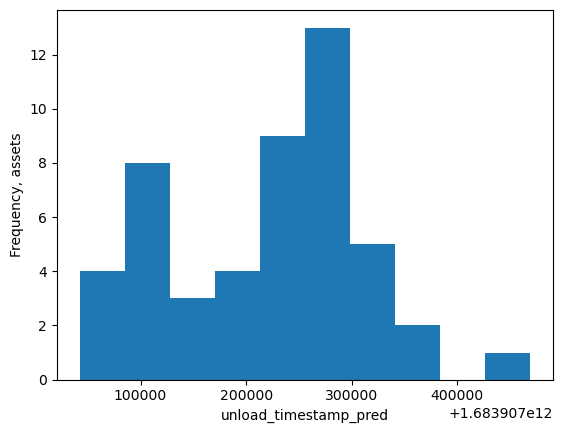

In [460]:
unload_timestamp_pred = 1000*y_pred_test + time_earliest_test # Unscale predictions
plt.hist(unload_timestamp_pred)
plt.xlabel('unload_timestamp_pred')
plt.ylabel('Frequency, assets');

In [429]:
unload_timestamp_pred

array([1.68390728e+12, 1.68390726e+12, 1.68390724e+12, 1.68390725e+12,
       1.68390730e+12, 1.68390732e+12, 1.68390728e+12, 1.68390725e+12,
       1.68390725e+12, 1.68390726e+12, 1.68390723e+12, 1.68390733e+12,
       1.68390729e+12, 1.68390734e+12, 1.68390729e+12, 1.68390731e+12,
       1.68390729e+12, 1.68390734e+12, 1.68390727e+12, 1.68390727e+12,
       1.68390724e+12, 1.68390728e+12, 1.68390736e+12, 1.68390726e+12,
       1.68390725e+12, 1.68390733e+12, 1.68390724e+12, 1.68390729e+12,
       1.68390747e+12, 1.68390712e+12, 1.68390712e+12, 1.68390705e+12,
       1.68390711e+12, 1.68390711e+12, 1.68390712e+12, 1.68390709e+12,
       1.68390704e+12, 1.68390708e+12, 1.68390709e+12, 1.68390705e+12,
       1.68390719e+12, 1.68390721e+12, 1.68390721e+12, 1.68390717e+12,
       1.68390715e+12, 1.68390721e+12, 1.68390716e+12, 1.68390714e+12,
       1.68390709e+12])

### Format final predictions
* They should exist as a dataframe containing 3 columns: "pixel_id", "unload_pred", "unload_timestamp_pred".
* Dataframe should be named "final_pred_df".

In [430]:
final_pred_df = pd.DataFrame(columns = ['pixel_id','unload_timestamp_pred','unload_pred'])
final_pred_df['pixel_id'] = X_test.index
final_pred_df['unload_pred'] = [0]*len(X_test.index)
final_pred_df['unload_timestamp_pred'] = ['']*len(X_test.index)
j = 0 # index in prediction values
for i in idx_unloaded_test:
    final_pred_df.loc[i, 'unload_pred'] = 1
    final_pred_df.loc[i, 'unload_timestamp_pred'] = unload_timestamp_pred[j]
    j += 1 # next prediction value index
final_pred_df # see output

,pixel_id,unload_timestamp_pred,unload_pred
0,T2213,1683907279849.779053,1
1,T2214,1683907258186.378418,1
2,T2215,1683907241084.174561,1
3,T2218,1683907245908.386719,1
4,T2219,1683907296950.498535,1
...,...,...,...
58,T2367,1683907208180.17627,1
59,T2371,1683907162392.521973,1
60,T2373,,0
61,T2374,1683907136469.469971,1


In [431]:
final_pred_df.to_csv('final_pred_df.csv', index=False)

In [432]:
#DO NOT ALTER - USE THIS TO TEST IF YOUR PREDICTION CONTAINS REQUIRED COLUMNS

import unittest
class TestPredResult(unittest.TestCase):
    def setUp(self, target_df):
        self.expected = ["pixel_id", "unload_pred", "unload_timestamp_pred"]
        self.result = list(target_df.columns)
    def test_count_eq(self):
        self.assertCountEqual(self.result, self.expected)

check_columns = TestPredResult()
check_columns.setUp(final_pred_df)
check_columns.test_count_eq()

In [433]:
#DO NOT ALTER - EVALUATION FUNCTIONS

from sklearn.metrics import (
  f1_score, 
  precision_score, 
  recall_score, 
  accuracy_score)
from sklearn import metrics
import seaborn as sns

def metric_eval(y_true, y_pred):

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average="weighted")
  recall = recall_score(y_true, y_pred, average="weighted")
  f1 = f1_score(y_true, y_pred, average="weighted")
  print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1 score: {f1}")

  confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, display_labels = [False, True])
  # cm_display.ax_.set_title("Confusion Matrix (cutoff = 0.5)")
  return accuracy, precision, recall, f1, cm_display

def compare_pred_true(
  compare_result_df: pd.DataFrame,
  true_label_colname: str = 'unload',
  true_time_colname: str = "unload_timestamp",
  pred_label_colname: str = 'unload_pred',
  pred_time_colname: str = "unload_timestamp_pred", 
):

  compare_df = compare_result_df.copy()
  # confusion matrix
  accuracy, _, _, _, cm_display = metric_eval(
    compare_df[true_label_colname] , compare_df[pred_label_colname]
  )

  # time error
  compare_df["error_minute"] = (
    compare_df[pred_time_colname] - compare_df[true_time_colname]
  )/ 1000 / 60
  compare_df['error_minute_abs'] = np.abs(compare_df["error_minute"])

  extreme_error = compare_df[compare_df["error_minute_abs"] > 20].copy()
  correct_pred = compare_df[compare_df[true_label_colname] == compare_df[pred_label_colname]].copy()
  neg_pred = compare_df[compare_df.error_minute < -1].copy()


  print(
    f"""
    out of {len(compare_df)} cases, 
    {len(correct_pred)} ({accuracy * 100:.2f}%) predicted correctly
    {len(neg_pred)} ({len(neg_pred)/len(compare_df) * 100:.2f}%) determined unload before actual time
    {len(extreme_error)} ({len(extreme_error)/len(compare_df) * 100:.2f}%) with extreme error larger than +/-10 minutes
    """
  )

  # plot side by side
  fig, ax = plt.subplots(1, 2, figsize = (10, 4))
  cm_display.plot(ax = ax[0])
  ax[0].set_title("Confusion Matrix")

  sns.histplot(compare_df["error_minute"], stat = "probability", ax = ax[1])
  ax[1].set_title("Time Error in Minutes")
  ax[1].set_ylim(0, 1.2)
  ax[1].set_xlim(-20, 20)

  return compare_df

In [ ]:
#DO NOT ALTER - APPLY THE EVALUATION FUNCTIONS ON TOP OF PREDICITON
# load true result
truth = '../ds_interview_unload_results.csv'
truth_df = pd.read_csv(truth)

# join with the prediction result and evaluate
compare_df = truth_df.merge(final_pred_df, how='left', on = ['pixel_id'])
compare_result = compare_pred_true(compare_result_df = compare_df)